# Predicting the NBA All-Stars with Machine Learning

The goal of this analysis is to predict the NBA All-Stars for a specific year by applying machine learning algorithms on NBA player performance data and All-Star selection data from other years. The analysis is based on the [Scikit-learn](http://scikit-learn.org) machine learning package, NBA data are taken from [basketball-reference.com](https://www.basketball-reference.com).

## Import modules and libraries:

In [1]:
import NBAanalysissetup # See NBAanalysissetup.py

from NBAanalysissetup import MyModel, MyCM

import numpy             as np
import pandas            as pd
import matplotlib.pyplot as plt
import seaborn           as sns

import copy
import operator
import sys
import time

from sklearn.preprocessing import StandardScaler, MinMaxScaler, RobustScaler

from sklearn.decomposition         import PCA
from sklearn.mixture               import GaussianMixture
from sklearn.cluster               import KMeans, SpectralClustering

from sklearn.neighbors             import KNeighborsClassifier
from sklearn.linear_model          import LogisticRegression, SGDClassifier, PassiveAggressiveClassifier
from sklearn.svm                   import LinearSVC
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.gaussian_process      import GaussianProcessClassifier
from sklearn.naive_bayes           import GaussianNB
from sklearn.tree                  import DecisionTreeClassifier
from sklearn.ensemble              import RandomForestClassifier, ExtraTreesClassifier 
from sklearn.ensemble              import GradientBoostingClassifier, AdaBoostClassifier
from sklearn.ensemble              import BaggingClassifier, VotingClassifier
from sklearn.neural_network        import MLPClassifier

from xgboost                       import XGBClassifier

from sklearn.model_selection import cross_validate, LeaveOneGroupOut, validation_curve

from sklearn.metrics import adjusted_rand_score, adjusted_mutual_info_score, normalized_mutual_info_score
from sklearn.metrics import homogeneity_completeness_v_measure
from sklearn.metrics import fowlkes_mallows_score, silhouette_score, calinski_harabaz_score
from sklearn.metrics import confusion_matrix, roc_curve, precision_recall_curve, auc, classification_report
#from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score, roc_auc_score
from sklearn.metrics import brier_score_loss

from sklearn.utils.validation import column_or_1d
from sklearn.calibration      import CalibratedClassifierCV, calibration_curve

from bokeh.models   import ColumnDataSource
from bokeh.plotting import figure
from bokeh.io       import show, output_notebook
from bokeh.layouts  import layout
from bokeh.palettes import Category20

output_notebook()

tools = "pan,wheel_zoom,box_zoom,reset,save".split(',')

import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)
warnings.filterwarnings("ignore", category=FutureWarning)
warnings.filterwarnings("ignore", category=UserWarning)

%load_ext watermark
%watermark -a "Author: gmalim" 
print("")
%watermark -u -n
print("")
%watermark -v -p numpy,pandas,sklearn,xgboost,matplotlib,seaborn,bokeh
print("")
%watermark -m

start = time.time()

Loading BokehJS ...

Author: gmalim

last updated: Wed May 02 2018

CPython 3.6.5
IPython 6.3.1

numpy 1.14.3
pandas 0.22.0
sklearn 0.19.1
xgboost 0.71
matplotlib 2.2.2
seaborn 0.8.1
bokeh 0.12.15

compiler   : GCC 4.2.1 Compatible Apple LLVM 8.0.0 (clang-800.0.42.1)
system     : Darwin
release    : 15.6.0
machine    : x86_64
processor  : i386
CPU cores  : 2
interpreter: 64bit


## User input

Enter the first and last year for which data has been scraped, and choose the year you want to predict (*test_year*). The years that are not selected are used for cross-validation and training of the ML algorithms. NBA data from 2000-2018 from [basketball-reference.com](https://www.basketball-reference.com) have been saved as csv-files in the **data** directory of this repository using the scraper functions in [*NBAanalysissetup.py*](NBAanalysissetup.py). Data from other years can be obtained by using [*Basketball_Reference_scraper.py*](Basketball_Reference_scraper.py).

In [2]:
first_year = 2010 # Enter first year for which data has been scraped
last_year  = 2018 # Enter last year for which data has been scraped
test_year  = 2018 # Enter any year for which data has been scraped

# Check if All-Stars have been selected for test_year:
 
shellcommand = "wc -l data/NBA_allstars_{}-{}.csv | awk '{{print $1}}'".format(test_year-1, test_year)
n = !{shellcommand}
n = int(n[0])
test_year_truth_is_known = False if n == 1 else True

if test_year_truth_is_known:
    print("--> Test year = {} (All-Stars have been selected)".format(test_year))
else:
    print("--> Test year = {} (All-Stars have not been selected yet)".format(test_year))

train_years = list(range(first_year, last_year+1))

train_years.remove(test_year)

first_train_year = train_years[0]
last_train_year  = train_years[-1]
    
if (first_train_year < test_year < last_train_year):
    print("--> Train years = {}-{} except {}".format(first_train_year, last_train_year, test_year))
else:
    print("--> Train years = {}-{}".format(first_train_year, last_train_year))

--> Test year = 2018 (All-Stars have been selected)
--> Train years = 2010-2017


Choose whether you want to include advanced players statistics (e.g. *PER*, *VORP*, etc.) in the model or not:

In [3]:
includeadvancedstats = True # Enter True or False

if includeadvancedstats:
    print("--> Advanced statistics included")
else:
    print("--> Advanced statistics not included")

--> Advanced statistics included


Choose the minimum number of games a player has to have started per season to be included in the analysis:

In [4]:
min_num_games = 41 # Enter any integer between 0 and 82

print("--> Minimum number of games for each player =", min_num_games)

--> Minimum number of games for each player = 41


## Data processing

Load NBA player performance data and All-Star selection data:

In [5]:
df_train, df_test = NBAanalysissetup.loaddata_allyears(train_years, test_year, includeadvancedstats, target='allstar')

--> Loading train year 2009-2010 ...
--> Loading train year 2010-2011 ...
--> Loading train year 2011-2012 ...
--> Loading train year 2012-2013 ...
--> Loading train year 2013-2014 ...
--> Loading train year 2014-2015 ...
--> Loading train year 2015-2016 ...
--> Loading train year 2016-2017 ...
--> Loading test  year 2017-2018 ...


Print table of All-Stars in *test_year*:

In [6]:
if test_year_truth_is_known:
    print("--> All-Stars {} :".format(test_year))
    #df_tmp = df_train[(df_train['YEAR'] == print_year) & (df_train['AS'] > 0.5)]
    df_tmp = df_test[df_test['AS'] == 1]
    cm = sns.diverging_palette(240, 10, n=9, as_cmap=True)
    df_tmp_style = df_tmp.style.background_gradient(cmap=cm, axis=0)
    display(df_tmp_style)
else:
    print("--> The NBA All-Stars for {} have not been selected yet".format(test_year))

--> All-Stars 2018 :


Select only players which have started at least *min_num_games* number of games in a season:

In [7]:
print("--> # of players in train set =", df_train.shape[0])
print("--> # of players in test  set =", df_test .shape[0])
print("")

df_train = df_train[(((df_train['GS'] >= min_num_games) & (df_train['YEAR'] >= 1982)) | \
                     ((df_train['G']  >= min_num_games) & (df_train['YEAR'] <  1982)))]
df_test  = df_test [(((df_test ['GS'] >= min_num_games) & (df_test ['YEAR'] >= 1982)) | \
                     ((df_test ['G']  >= min_num_games) & (df_test ['YEAR'] <  1982)))]

print("--> # of players in train set =", df_train.shape[0])
print("--> # of players in test  set =", df_test .shape[0])

# Reset dataframe indices:

df_train = df_train.reset_index(drop=True)
df_test  = df_test .reset_index(drop=True)

--> # of players in train set = 3775
--> # of players in test  set = 540

--> # of players in train set = 1104
--> # of players in test  set = 141


NaN handling:

In [8]:
print("--> # of players with NaNs in train set =", df_train.shape[0] - df_train.dropna().shape[0])
print("--> # of players with NaNs in test  set =", df_test .shape[0] - df_test .dropna().shape[0])
print("")

# Replace NaNs with 0s in the following columns:

df_train[['FG%', '3P%', '2P%', 'FT%', 'eFG%']] = df_train[['FG%', '3P%', '2P%', 'FT%', 'eFG%']].fillna(value=0)
df_test [['FG%', '3P%', '2P%', 'FT%', 'eFG%']] = df_test [['FG%', '3P%', '2P%', 'FT%', 'eFG%']].fillna(value=0)

if (includeadvancedstats):
    df_train[['TS%', '3PAr', 'FTr']] = df_train[['TS%', '3PAr', 'FTr']].fillna(value=0)
    df_test [['TS%', '3PAr', 'FTr']] = df_test [['TS%', '3PAr', 'FTr']].fillna(value=0)
    
print("--> # of players with NaNs in train set =", df_train.shape[0] - df_train.dropna().shape[0])
print("--> # of players with NaNs in test  set =", df_test .shape[0] - df_test .dropna().shape[0])
#print("")

# Remove remaining players with NaNs, if necessary:

if (df_train.shape[0] - df_train.dropna().shape[0] != 0):
    #print("--> Players in train set with NaNs:")
    #print(df_train[df_train.isnull().any(axis=1)])
    #print("")
    df_train.dropna(inplace=True)
    print("--> # of players with NaNs in train set =", df_train.shape[0] - df_train.dropna().shape[0])

if (df_test.shape[0] - df_test.dropna().shape[0] != 0):
    #print("--> Players in test set with NaNs:")
    #print(df_test[df_test.isnull().any(axis=1)])
    #print("")
    df_test.dropna(inplace=True)
    print("--> # of players with NaNs in test  set =", df_test.shape[0] - df_test.dropna().shape[0])
    
# Reset dataframe indices:

df_train = df_train.reset_index(drop=True)
df_test  = df_test .reset_index(drop=True)

--> # of players with NaNs in train set = 56
--> # of players with NaNs in test  set = 4

--> # of players with NaNs in train set = 0
--> # of players with NaNs in test  set = 0


Check number of All-Stars in dataframes:

In [9]:
# Check All-Star data in data files:

all_years = train_years[:]
all_years.append(test_year)

n_AS_dict = {} 

for year in all_years:
    shellcommand = "wc -l data/NBA_allstars_{}-{}.csv | awk '{{print $1}}'".format(year-1, year)
    n = !{shellcommand}
    n_AS_dict[year] = int(n[0]) - 1 # Don't count header
    
# Check All-Star data in dataframes:

for train_year in train_years:
    n_AS_df  = df_train[(df_train['YEAR'] == train_year) & (df_train['AS'] > 0.5)].shape[0]
    n_AS_tot = n_AS_dict[train_year]
    n_tot    = df_train[(df_train['YEAR'] == train_year)].shape[0]
    print("--> Train year {}: {} out of {} All-Stars in analysis (Total # of players = {})".format(
        train_year, n_AS_df, n_AS_tot, n_tot))
    
n_AS_df  = df_test[df_test['AS'] > 0.5].shape[0]
n_AS_tot = n_AS_dict[test_year]
n_tot    = df_test.shape[0]
print("--> Test  year {}: {:2d} out of {:2d} All-Stars in analysis (Total # of players = {})".format(
    test_year, n_AS_df, n_AS_tot, n_tot))

--> Train year 2010: 27 out of 28 All-Stars in analysis (Total # of players = 142)
--> Train year 2011: 24 out of 25 All-Stars in analysis (Total # of players = 143)
--> Train year 2012: 24 out of 25 All-Stars in analysis (Total # of players = 118)
--> Train year 2013: 24 out of 25 All-Stars in analysis (Total # of players = 143)
--> Train year 2014: 24 out of 25 All-Stars in analysis (Total # of players = 143)
--> Train year 2015: 25 out of 28 All-Stars in analysis (Total # of players = 133)
--> Train year 2016: 26 out of 26 All-Stars in analysis (Total # of players = 143)
--> Train year 2017: 25 out of 25 All-Stars in analysis (Total # of players = 139)
--> Test  year 2018: 28 out of 28 All-Stars in analysis (Total # of players = 141)


Prepare data and create Feature Matrix (*X*) and Target Vector (*y*) dataframes:

In [10]:
# Feature Matrix dataframes:

X_train = df_train.drop(['AS', 'YEAR'], axis=1) # AS and YEAR are dropped: AS is the target variable,
X_test  = df_test .drop(['AS', 'YEAR'], axis=1) # YEAR is only used for cross-validation (see below). 

X_list = [X_train, X_test]

for X in X_list:
    
    # Remove redundant features:
    
    # - Features with no predictive power 
    # - Features that are correlated with other features
    # - Features that measure the same performance skill
    
    X.drop(['Player', 'Pos', 'Tm', 'Age', 'TC',     
            'FG', 'FGA', 'FG%', '2P', '2PA', '2P%', 
            '3P', '3PA', '3P%', 'FT', 'FTA', 'FT%', 
            'ORB', 'DRB', 'PF'],                    
           axis=1, inplace=True)

    if includeadvancedstats:
        X.drop(['3PAr', 'FTr', 'ORB%', 'DRB%', 'TOV%', 'WS', 'WS/48', 'BPM', 
                'eFG%', 'TRB', 'AST', 'STL', 'BLK', 'TOV'], 
               axis=1, inplace=True) 
    
    # Scale total-type features by MP/48:
    
    X[['PTS']] = X[['PTS']].div(X['MP'].values, axis=0)
    X[['PTS']] = X[['PTS']].multiply(48, axis=0)
    X.rename(columns={'PTS': 'PTS/48'}, inplace=True)
    
    if includeadvancedstats:
        X[['OWS', 'DWS']] = \
        X[['OWS', 'DWS']].div(X['MP'].values, axis=0)
        X[['OWS', 'DWS']] = X[['OWS', 'DWS']].multiply(48, axis=0)
        X.rename(columns={'OWS': 'OWS/48', 'DWS': 'DWS/48'}, inplace=True)
    else:
        X[['TRB', 'AST', 'STL', 'BLK']] = X[['TRB', 'AST', 'STL', 'BLK']].div(X['MP'].values, axis=0)
        X[['TRB', 'AST', 'STL', 'BLK']] = X[['TRB', 'AST', 'STL', 'BLK']].multiply(48, axis=0)
        X.rename(columns={'TRB': 'TRB/48', 'AST': 'AST/48', 'STL': 'STL/48', 
                          'BLK': 'BLK/48', 'TOV': 'TOV/48'}, inplace=True)

    # Scale MP by G:

    X['MP'] = X['MP'].div(X['G'], axis=0)
    X.rename(columns={'MP': 'MP/G'}, inplace=True)
            
# Target Vector dataframes:

y_train = df_train['AS'] # target = AS, a binary variable that indicates All-Star selection status
y_test  = df_test ['AS']

n_players_train = X_train.shape[0]
n_players_test  = X_test .shape[0]
n_features = X_train.shape[1] # equals X_test.shape[1]

print("--> Train data set : # of players = {:4}, # of features = {}".format(n_players_train, n_features))
print("--> Test  data set : # of players = {:4}, # of features = {}".format(n_players_test,  n_features))
print("")
print("--> Model features : ", end = '')
print(*X_train.columns, sep=', ')

--> Train data set : # of players = 1104, # of features = 17
--> Test  data set : # of players =  141, # of features = 17

--> Model features : G, GS, MP/G, PTS/48, PER, TS%, TRB%, AST%, STL%, BLK%, USG%, OWS/48, DWS/48, OBPM, DBPM, VORP, TW


Print table of test data:

In [11]:
X_tmp = copy.deepcopy(X_test)

feature_names = X_tmp.columns

df_tmp = pd.DataFrame(data=X_tmp, columns=feature_names)
if test_year_truth_is_known:
    df_tmp['AS']     = y_test
df_tmp['Player'] = df_test['Player']

if test_year_truth_is_known:
    df_tmp = df_tmp[['Player', 'AS', *feature_names]]
    df_tmp = df_tmp[df_tmp['AS'] > 0.5]
    df_tmp.drop('AS', axis=1, inplace=True)
else:
    df_tmp = df_tmp[['Player', *feature_names]]
    
pd.set_option('precision', 3)
#pd.set_option('display.float_format', '{:6.3f}'.format) # doesn't seem to work with display(df)
cm = sns.diverging_palette(240, 10, n=9, as_cmap=True)
df_tmp_style = df_tmp.style.background_gradient(cmap=cm, axis=0)
display(df_tmp_style)

Scale feature dataframes to accommodate ML algorithms:

In [12]:
feature_names = X_train.columns # This is no longer available after transformation with Scalers

X_scaler = StandardScaler(with_mean=True, with_std=True) # Scaler with zero mean and unit variance
#X_scaler = MinMaxScaler(feature_range=(0, 1)) # Scales features to range 0 to 1 (or -1 to 1 if there are negative values)
#X_scaler = RobustScaler() # Similar method to the MinMaxScaler but more robust to outliers

X_train = X_scaler.fit_transform(X_train) # Fit scaler to training data and transform X_train
X_test  = X_scaler.transform(X_test)      # Transform X_test  using fitted scaler

Print table of scaled test data:

In [13]:
X_tmp = copy.deepcopy(X_test)

df_tmp = pd.DataFrame(data=X_tmp, columns=feature_names)
if test_year_truth_is_known:
    df_tmp['AS']     = y_test
df_tmp['Player'] = df_test['Player']

if test_year_truth_is_known:
    df_tmp = df_tmp[['Player', 'AS', *feature_names]]
    df_tmp = df_tmp[df_tmp['AS'] > 0.5]
    df_tmp.drop('AS', axis=1, inplace=True)
else:
    df_tmp = df_tmp[['Player', *feature_names]]
    
cm = sns.diverging_palette(240, 10, n=9, as_cmap=True)
df_tmp_style = df_tmp.style.background_gradient(cmap=cm, axis=0)
display(df_tmp_style)

Plot distributions of training data features (for All-Stars and non-All-Stars separately, if available):

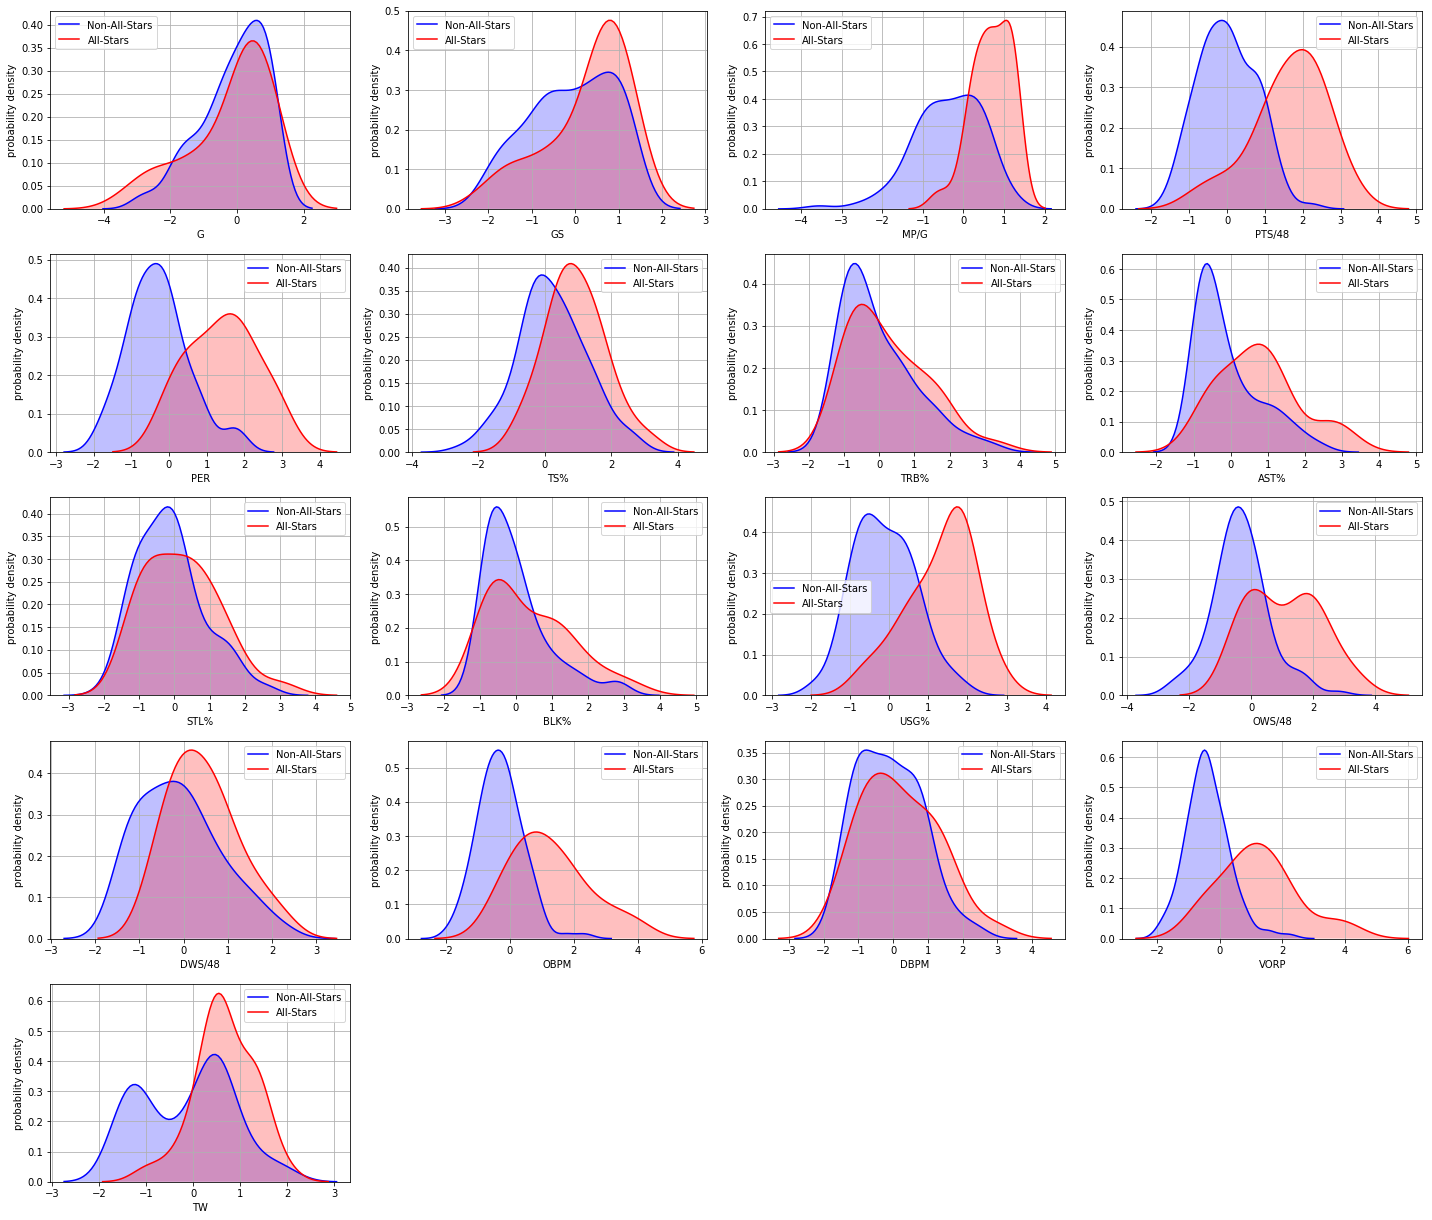

In [14]:
X_tmp = copy.deepcopy(X_test)

df_tmp = pd.DataFrame(data=X_tmp, columns=feature_names)
df_tmp['AS'] = y_test
df_AS  = df_tmp[df_tmp['AS'] == 1]
df_NAS = df_tmp[df_tmp['AS'] == 0]
df_AS  = df_AS .drop('AS', axis=1)
df_NAS = df_NAS.drop('AS', axis=1)

color=iter(plt.cm.tab20(np.linspace(0, 1, len(df_AS.columns))))    

plt.figure(figsize=(20, 20))

for ifeature, feature in enumerate(df_AS.columns):

    plt.subplot(6, 4, ifeature+1)

    if test_year_truth_is_known:
        sns.kdeplot(df_NAS[feature], shade=True, color="b", label='Non-All-Stars')
    else:        
        sns.kdeplot(df_NAS[feature], shade=True, color="b")
    sns.kdeplot(df_AS [feature], shade=True, color="r", label='All-Stars')
    
    plt.xlabel(feature)
    plt.ylabel('probability density')
    plt.grid(True)
    plt.tight_layout()

## Unsupervised Learning: PCA & Clustering

Use Principal Component Analysis for dimensionality reduction and plot the results:

--> The amount of variance explained by each of the eigen vectors of the covariance matrix of X_train:


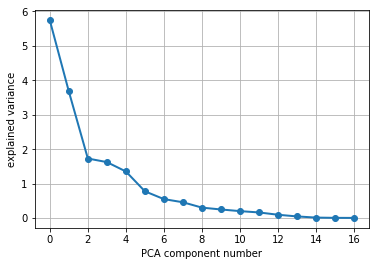

--> Training data in the PCA0-PCA1-PCA2-PCA3 space, where PCA components are ordered by the
    amount of variance they have in the data with respect to the target variable:


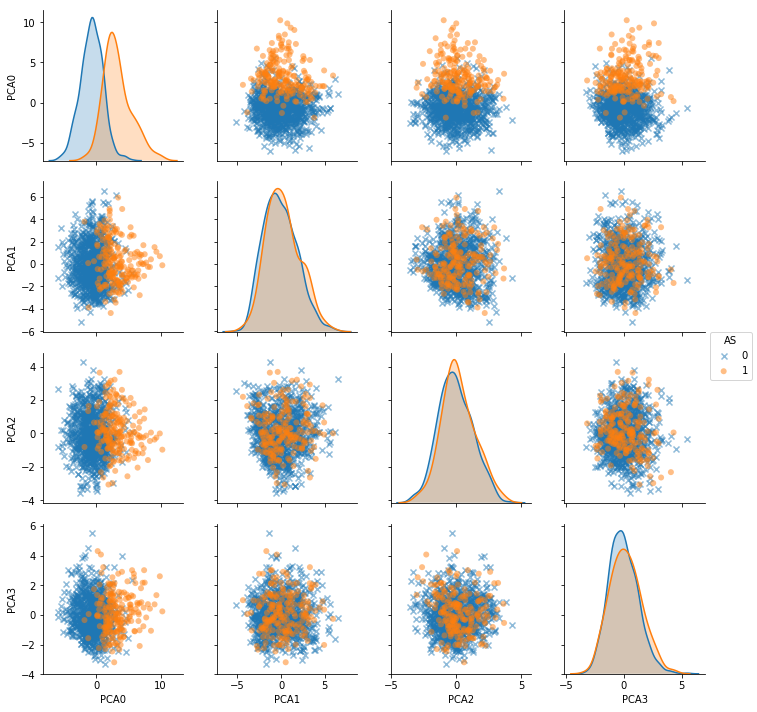

In [15]:
PCA_model = PCA(svd_solver='full') # Instantiate PCA model with hyperparameters

PCA_model.fit(X_train)                                   # Fit model to data (unsupervised: y is not specified)

print("--> The amount of variance explained by each of the eigen vectors of the covariance matrix of X_train:")

plt.plot(PCA_model.explained_variance_, linewidth=2, marker='o')
#plt.axis('tight')
plt.xlabel('PCA component number')
plt.ylabel('explained variance')
plt.grid(True)
plt.show()

X_train_PCA = PCA_model.transform(X_train) # Transform the data to the PCA basis (which are linearly uncorrelated variables)
X_test_PCA  = PCA_model.transform(X_test)  # Transform the data to the PCA basis (which are linearly uncorrelated variables)

df_train['PCA0'] = X_train_PCA[:, 0] # PCA0 is the principal component that has     maximum variance in the data
df_train['PCA1'] = X_train_PCA[:, 1] # PCA1 is the principal component that has 2nd-maximum variance in the data
df_train['PCA2'] = X_train_PCA[:, 2] # etc.
df_train['PCA3'] = X_train_PCA[:, 3]

print("--> Training data in the PCA0-PCA1-PCA2-PCA3 space, where PCA components are ordered by the")
print("    amount of variance they have in the data with respect to the target variable:")

plotvariables = ['PCA0', 'PCA1', 'PCA2', 'PCA3']
_ = sns.pairplot(df_train, vars=plotvariables, hue="AS", diag_kind="kde", diag_kws=dict(shade=True),
                 markers = ['x','o'], plot_kws=dict(edgecolor="none", alpha=0.5))

Apply clustering algorithms to training data, plot clusters and calculate performance scores:

--> KMeans clusters:


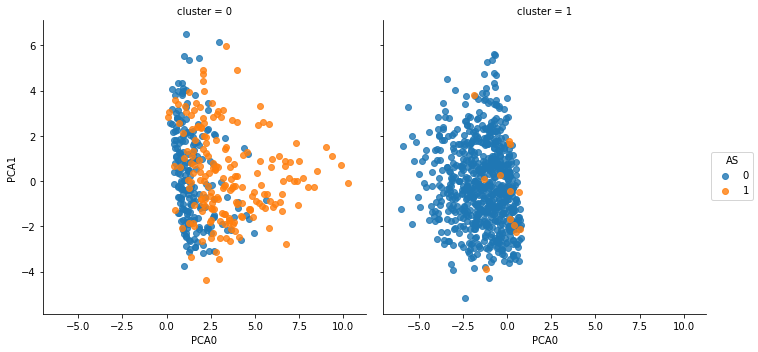

--> Gaussian Mixture clusters:


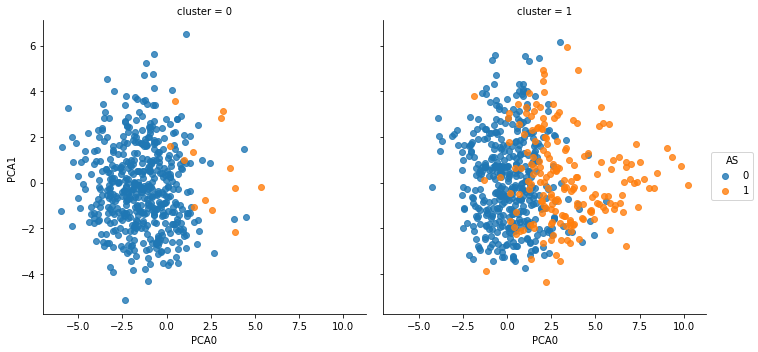

--> Spectral Clustering clusters:


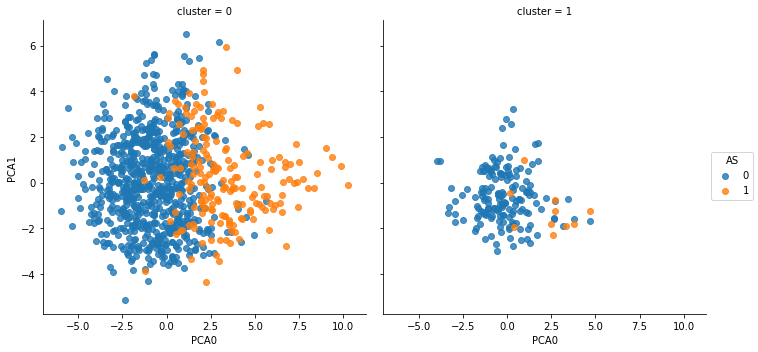


--> Clustering performance scores for all models:


KMeans  Gaussian Mixture  Spectral Clustering  \
Adjusted Rand Score             0.326             0.043               -0.077   
Adjusted Mutual Info Score      0.251             0.114                0.024   
Normalized Mutual Info Score    0.297             0.139                0.026   
Homogeneity Score               0.350             0.168                0.025   
Completeness Score              0.252             0.115                0.027   
V-Measure Score                 0.293             0.136                0.026   
Fowlkes-Mallows Score           0.743             0.614                0.697   
Silhouette Score                0.186             0.081               -0.072   
Calinski-Harabaz Score        277.517           122.718               19.614   

                             (Random) (Perfect)  
Adjusted Rand Score                 0         1  
Adjusted Mutual Info Score          0         1  
Normalized Mutual Info Score        0         1  
Homogeneity Score                   0         1  
Completeness Score                  0         1  
V-Measure Score                     0         1  
Fowlkes-Mallows Score               0         1  
Silhouette Score                 N.A.      N.A.  
Calinski-Harabaz Score           N.A.      N.A.

In [16]:
cluster_models = []

estimator_name = 'KMeans'
estimator = KMeans(n_clusters=2, init='random')                      # Instantiate model with hyperparameters
cluster_models.append((estimator_name, estimator))

estimator_name = 'Gaussian Mixture'
estimator = GaussianMixture(n_components=2, covariance_type='full')  # Instantiate model with hyperparameters
cluster_models.append((estimator_name, estimator))

estimator_name = 'Spectral Clustering'
estimator = SpectralClustering(n_clusters=2)                         # Instantiate model with hyperparameters
cluster_models.append((estimator_name, estimator))

cluster_score_names = ['Adjusted Rand Score', 'Adjusted Mutual Info Score', 'Normalized Mutual Info Score',
                       'Homogeneity Score', 'Completeness Score', 'V-Measure Score',
                       'Fowlkes-Mallows Score', 'Silhouette Score', 'Calinski-Harabaz Score']

df_clusterscores = pd.DataFrame()

for model in cluster_models:
                      
    model[1].fit(X_train)                                # Fit model to data (unsupervised: y is not specified)
    
    if hasattr(model[1], 'labels_'):                     # Determine cluster labels
        y_prediction = model[1].labels_.astype(np.int)
    else:
        y_prediction = model[1].predict(X_train)

    df_train['cluster'] = y_prediction

    print("-->", model[0], "clusters:")
    sns.lmplot("PCA0", "PCA1", data=df_train, hue='AS', col='cluster', fit_reg=False)
    plt.show()

    # Calculate clustering performance scores based on the truth (i.e. y_train)
    
    adjusted_rand_s          = adjusted_rand_score               (y_train, y_prediction)
    adjusted_mutual_info_s   = adjusted_mutual_info_score        (y_train, y_prediction)
    normalized_mutual_info_s = normalized_mutual_info_score      (y_train, y_prediction)
    fowlkes_mallows_s        = fowlkes_mallows_score             (y_train, y_prediction)
    hcv                      = homogeneity_completeness_v_measure(y_train, y_prediction)    
    homogeneity_s            = hcv[0]
    completeness_s           = hcv[1]
    v_measure_s              = hcv[2]

    # Calculate clustering performance scores based on the clusters themselves (i.e. y_train is not specified)
    
    silhouette_s       = silhouette_score      (X_train, y_prediction, metric='euclidean')
    calinski_harabaz_s = calinski_harabaz_score(X_train, y_prediction)
        
    df_clusterscores.loc[cluster_score_names[0], model[0]] = adjusted_rand_s
    df_clusterscores.loc[cluster_score_names[1], model[0]] = adjusted_mutual_info_s
    df_clusterscores.loc[cluster_score_names[2], model[0]] = normalized_mutual_info_s
    df_clusterscores.loc[cluster_score_names[3], model[0]] = homogeneity_s
    df_clusterscores.loc[cluster_score_names[4], model[0]] = completeness_s
    df_clusterscores.loc[cluster_score_names[5], model[0]] = v_measure_s
    df_clusterscores.loc[cluster_score_names[6], model[0]] = fowlkes_mallows_s
    df_clusterscores.loc[cluster_score_names[7], model[0]] = silhouette_s
    df_clusterscores.loc[cluster_score_names[8], model[0]] = calinski_harabaz_s

df_clusterscores['(Random)' ] = 0
df_clusterscores['(Perfect)'] = 1

df_clusterscores.loc['Silhouette Score',       '(Random)' ] = 'N.A.'
df_clusterscores.loc['Silhouette Score',       '(Perfect)'] = 'N.A.'
df_clusterscores.loc['Calinski-Harabaz Score', '(Random)' ] = 'N.A.'
df_clusterscores.loc['Calinski-Harabaz Score', '(Perfect)'] = 'N.A.'
    
print("")
print("--> Clustering performance scores for all models:")
display(df_clusterscores)

#### Conclusion: 

The unsupervised learning algorithms tested in this analysis are unable to identify the NBA All-Stars and non-All-Stars as two clearly separated clusters.

## Supervised Learning: Classification

Select ML classifiers, set hyper-parameters and instantiate models:

In [17]:
rseed = 666 # Set random_state of model (where applicable) to specific seed, to tune hyper-parameters

models = []

estimator_name = 'K-Nearest Neighbours Classifier'
n_n = 5
w   = 'uniform' # 'distance'
estimator = KNeighborsClassifier(n_neighbors=n_n, weights=w)
models.append(MyModel(estimator_name, estimator))

estimator_name = 'Logistic Regression Classifier'
C = 0.05  # A smaller value for C results in more regularization (variance reduction due to noise in data)
p = 'l2' # penalty="l1" enables Lasso regularization (i.e. sparsity)  => Feature selection 
#          penalty="l2" enables Ridge regularization (i.e. shrinkage) => Coefficient suppression
estimator = LogisticRegression(C=C, penalty=p)
models.append(MyModel(estimator_name, estimator))

#estimator_name = 'Support Vector Machine Classifier'
estimator_name = 'Linear Support Vector Machine Classifier'
#k = 'rbf' # 'linear' # 'poly', 'rbf'
#d = 3 # for kernel='poly'
C = 1
p = 'l2'
#estimator = SVC(kernel=k, degree=d, probability=True, C=C, random_state=rseed)
estimator = LinearSVC(C=C, penalty=p, dual=False)
models.append(MyModel(estimator_name, estimator))

estimator_name = 'Stochastic Gradient Descent Classifier'
l = 'squared_hinge' # 'log', 'modified_huber', 'hinge', 'perceptron'
p = 'l2'
estimator = SGDClassifier(loss=l, penalty=p, random_state=rseed)
models.append(MyModel(estimator_name, estimator))

#estimator_name = 'Quadratic Discriminant Analysis Classifier'
estimator_name = 'Linear Discriminant Analysis Classifier'
#estimator = QuadraticDiscriminantAnalysis()
so = 'svd' # 'lsqr', 'eigen' (if 'svd', shrinkage should be None)
sh = None # 'auto' 
estimator = LinearDiscriminantAnalysis(solver=so, shrinkage=sh)
models.append(MyModel(estimator_name, estimator))

estimator_name = 'Passive Aggressive Classifier'
C = 0.01
l = 'squared_hinge' # 'hinge'
estimator = PassiveAggressiveClassifier(C=C, loss=l, random_state=rseed)
models.append(MyModel(estimator_name, estimator))

'''
estimator_name = 'Perceptron Classifier'
p   = 'l2' # 'l1', 'elasticnet'
a   = 0.0001 # regularization factor
m_i = 5 # maximum number of passes over the training data (aka epochs) 
estimator = Perceptron(penalty=p, alpha=a, max_iter=m_i, random_state=rseed)
models.append(MyModel(estimator_name, estimator))
'''

estimator_name = 'Neural Network Classifier'
a = 0.0001 # regularization factor
estimator = MLPClassifier(alpha=a, #hidden_layer_sizes=(100, 100, 100, 100, 100), 
                          activation='relu', solver='adam', random_state=rseed)
models.append(MyModel(estimator_name, estimator))

estimator_name = 'Gaussian Process Classifier' # (CV is slowwwwwwww)
estimator = GaussianProcessClassifier(random_state=rseed)
models.append(MyModel(estimator_name, estimator))

estimator_name = 'Gaussian Naive Bayes Classifier'
estimator = GaussianNB()
models.append(MyModel(estimator_name, estimator))

estimator_name = 'Decision Tree Classifier'
m_d = None   # i.e. nodes are expanded until leafs are pure 
m_f = 'auto' # The number of features to consider when looking for the best split. 
#              'auto' => max_features=sqrt(n_features) 
estimator = DecisionTreeClassifier(max_depth=m_d, max_features=m_f, random_state=rseed)
models.append(MyModel(estimator_name, estimator))

estimator_name = 'Bagged Decision Tree Classifier'
n_e = 100
m_d = None
m_f = 'auto'
dtc = DecisionTreeClassifier(max_depth=m_d, max_features=m_f, random_state=rseed)
estimator = BaggingClassifier(base_estimator=dtc, n_estimators=n_e, random_state=rseed)
models.append(MyModel(estimator_name, estimator))

estimator_name = 'Random Forest Classifier'
n_e = 100
m_d = None
m_f = 'auto'
estimator = RandomForestClassifier(n_estimators=n_e, max_depth=m_d, max_features=m_f, random_state=rseed)
models.append(MyModel(estimator_name, estimator))

estimator_name = 'Extra Randomized Forest Classifier'
n_e = 100
m_d = None
m_f = 'auto'
estimator = ExtraTreesClassifier(n_estimators=n_e, max_depth=m_d, max_features=m_f, random_state=rseed)
models.append(MyModel(estimator_name, estimator))

estimator_name = 'Adaptive Boosted Decision Tree Classifier'
n_e = 100
l_l = 0.1
estimator = AdaBoostClassifier(n_estimators=n_e, learning_rate=l_l, random_state=rseed)
models.append(MyModel(estimator_name, estimator))

estimator_name = 'Gradient Boosted Decision Tree Classifier'
n_e = 100
m_d = 3
l_l = 0.1
estimator = GradientBoostingClassifier(n_estimators=n_e, max_depth=m_d, learning_rate=l_l, random_state=rseed)
models.append(MyModel(estimator_name, estimator))

estimator_name = 'Extreme Gradient Boosted Decision Tree Classifier'
n_e = 100
m_d = 3
l_r = 0.1
estimator = XGBClassifier(n_estimators=n_e, max_depth=m_d, learning_rate=l_r, random_state=rseed)
models.append(MyModel(estimator_name, estimator))

print("--> ML classifiers implemented in this analysis:")
print("")

model_names = []

for counter, model in enumerate(models, 0):
    print("{:2} : {}".format(counter, model.estimator_name))
    #print("     Model parameters : ", mymodel.estimator.get_params())
    model_names.append(model.estimator_name)

--> ML classifiers implemented in this analysis:

 0 : K-Nearest Neighbours Classifier
 1 : Logistic Regression Classifier
 2 : Linear Support Vector Machine Classifier
 3 : Stochastic Gradient Descent Classifier
 4 : Linear Discriminant Analysis Classifier
 5 : Passive Aggressive Classifier
 6 : Neural Network Classifier
 7 : Gaussian Process Classifier
 8 : Gaussian Naive Bayes Classifier
 9 : Decision Tree Classifier
10 : Bagged Decision Tree Classifier
11 : Random Forest Classifier
12 : Extra Randomized Forest Classifier
13 : Adaptive Boosted Decision Tree Classifier
14 : Gradient Boosted Decision Tree Classifier
15 : Extreme Gradient Boosted Decision Tree Classifier


## Cross-validation

Cross-validate the model using training data and the *LeaveOneGroupOut* cross-validation scheme in which a group is defined as a single NBA season:

In [18]:
logo = LeaveOneGroupOut()

cv_groups = df_train['YEAR'] # Players in the same group (i.e. a single NBA season) have identical YEAR variables

Calculate and plot validation curves for specific models:

--> Plotting validation curves for Logistic Regression Classifier :


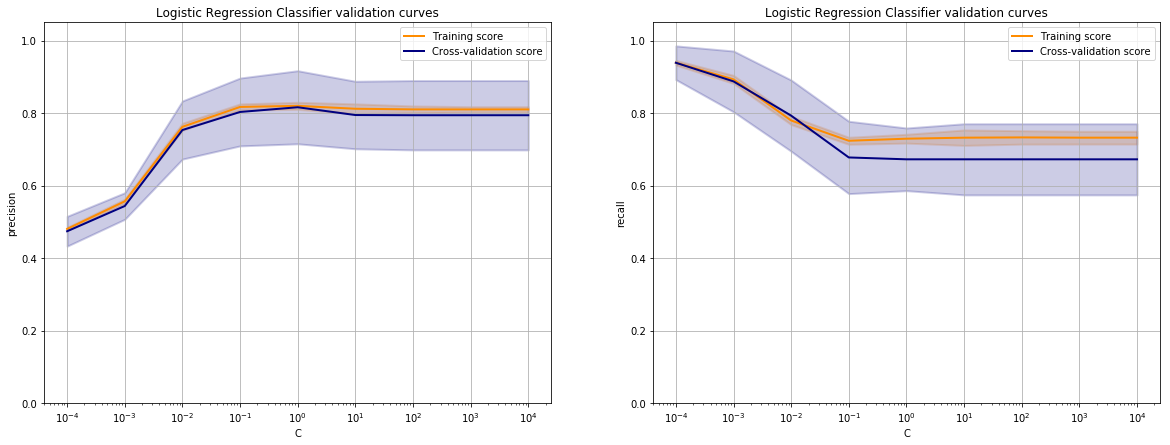

In [19]:
model = models[1]

classifier = model.estimator

print("--> Plotting validation curves for", model.estimator_name, ":")

min_logspace = -4
max_logspace =  4
param_range = np.logspace(min_logspace, max_logspace, (abs(min_logspace)+abs(max_logspace)+1))
#param_range = [2,4,6,8,10] #[3, 7, 11, 15]
#param_name = 'n_neighbors'
#param_name = 'alpha'
param_name = 'C'
#param_name = 'max_depth'

plt.figure(figsize=(20, 7))

plt.subplot(1, 2, 1)

scoring_metric = 'precision'

cv_logo = logo.split(X_train, y_train, groups=cv_groups)

train_scores, test_scores = validation_curve(classifier, X_train, y_train, param_name=param_name, 
                                             param_range=param_range, cv=cv_logo, scoring=scoring_metric)

train_scores_mean = np.mean(train_scores, axis=1)
train_scores_std  = np.std (train_scores, axis=1)
test_scores_mean  = np.mean(test_scores,  axis=1)
test_scores_std   = np.std (test_scores,  axis=1)

plt.title("{} validation curves".format(model.estimator_name))
plt.xlabel(param_name)
plt.ylabel(scoring_metric)
plt.ylim(0.0, 1.05)
plt.semilogx(param_range, train_scores_mean, label="Training score", color="darkorange", lw=2)
#plt.plot(param_range, train_scores_mean, label="Training score", color="darkorange", lw=2)
plt.fill_between(param_range, train_scores_mean - train_scores_std, train_scores_mean + train_scores_std, 
                 alpha=0.2, color="darkorange", lw=2)
plt.semilogx(param_range, test_scores_mean, label="Cross-validation score", color="navy", lw=2)
#plt.plot(param_range, test_scores_mean, label="Cross-validation score", color="navy", lw=2)
plt.fill_between(param_range, test_scores_mean - test_scores_std, test_scores_mean + test_scores_std, 
                 alpha=0.2, color="navy", lw=2)
plt.grid(True)
plt.legend(loc="best");

plt.subplot(1, 2, 2)

scoring_metric = 'recall'

cv_logo = logo.split(X_train, y_train, groups=cv_groups)

train_scores, test_scores = validation_curve(classifier, X_train, y_train, param_name=param_name, 
                                             param_range=param_range, cv=cv_logo, scoring=scoring_metric)

train_scores_mean = np.mean(train_scores, axis=1)
train_scores_std  = np.std (train_scores, axis=1)
test_scores_mean  = np.mean(test_scores,  axis=1)
test_scores_std   = np.std (test_scores,  axis=1)

plt.title("{} validation curves".format(model.estimator_name))
plt.xlabel(param_name)
plt.ylabel(scoring_metric)
plt.ylim(0.0, 1.05)
plt.semilogx(param_range, train_scores_mean, label="Training score", color="darkorange", lw=2)
#plt.plot(param_range, train_scores_mean, label="Training score", color="darkorange", lw=2)
plt.fill_between(param_range, train_scores_mean - train_scores_std, train_scores_mean + train_scores_std, 
                 alpha=0.2, color="darkorange", lw=2)
plt.semilogx(param_range, test_scores_mean, label="Cross-validation score", color="navy", lw=2)
#plt.plot(param_range, test_scores_mean, label="Cross-validation score", color="navy", lw=2)
plt.fill_between(param_range, test_scores_mean - test_scores_std, test_scores_mean + test_scores_std, 
                 alpha=0.2, color="navy", lw=2)
plt.grid(True)
plt.legend(loc="best");

Calculate classification scores:

In [20]:
X_train = np.array(X_train) # To accommodate X_train = X_training[train_index] and X_test = X_training[test_index]
y_train = np.array(y_train) # To accommodate y_train = y_training[train_index] and y_test = y_training[test_index]

cv_scores = []

for model in models:
    
    model.reset()
    
    classifier      = model.estimator
    classifier_name = model.estimator_name
    
    PRE_cvgroups = []
    REC_cvgroups = []
    F1_cvgroups  = []
    ACC_cvgroups = []
    FPR_cvgroups = []
    
    FPR_ROC_cvgroups = []
    TPR_ROC_cvgroups = []
    AUC_ROC_cvgroups = []
    PRE_PR_cvgroups  = []
    REC_PR_cvgroups  = []
    AUC_PR_cvgroups  = []
    
    cv_importances  = []
    cv_coefficients = []
    cv_y_test       = []
    cv_y_score      = []

    #print("--> Cross-validating", classifier_name, "...")
    
    for train_index, test_index in logo.split(X_train, y_train, groups=cv_groups):

        X_cvtrain = X_train[train_index]
        X_cvtest  = X_train[test_index]
        y_cvtrain = y_train[train_index]
        y_cvtest  = y_train[test_index]
                       
        classifier.fit(X_cvtrain, y_cvtrain)
    
        y_cvprediction = classifier.predict(X_cvtest) 
        y_cvtruth      = y_cvtest.tolist()
        
        CM = MyCM(confusion_matrix(y_cvtruth, y_cvprediction))
        
        PRE_cvgroups.append(CM.precision)
        REC_cvgroups.append(CM.recall)
        F1_cvgroups .append(CM.f1)
        ACC_cvgroups.append(CM.accuracy)
        FPR_cvgroups.append(CM.fpr)
        
        if hasattr(classifier, "feature_importances_"):
            cv_importances.append(classifier.feature_importances_)
            
        if hasattr(classifier, "coef_"):
            cv_coefficients.append(classifier.coef_.ravel())
            
        if hasattr(classifier, 'predict_proba'):
            y_cvscore = classifier.predict_proba(X_cvtest)[:, 1]
        else:
            y_cvscore = classifier.decision_function(X_cvtest)
            y_cvscore = (y_cvscore - y_cvscore.min()) / (y_cvscore.max() - y_cvscore.min())
        
        cv_y_test .append(y_cvtest )
        cv_y_score.append(y_cvscore)
        
        fpr, tpr, thresholds_roc = roc_curve             (y_cvtest, y_cvscore)
        pre, rec, thresholds_pr  = precision_recall_curve(y_cvtest, y_cvscore)

        roc_auc = auc(fpr, tpr)
        pr_auc  = auc(rec, pre)
        
        rec = rec[::-1] # reverse list
        pre = pre[::-1] # reverse list
        
        FPR_ROC_cvgroups.append(fpr)
        TPR_ROC_cvgroups.append(tpr)
        AUC_ROC_cvgroups.append(roc_auc)
        PRE_PR_cvgroups.append(pre)
        REC_PR_cvgroups.append(rec)
        AUC_PR_cvgroups.append(pr_auc)
        
    model.PRE_cvgroups = PRE_cvgroups
    model.REC_cvgroups = REC_cvgroups
    model.F1_cvgroups  = F1_cvgroups
    model.ACC_cvgroups = ACC_cvgroups
    model.FPR_cvgroups = FPR_cvgroups

    model.FPR_ROC_cvgroups = FPR_ROC_cvgroups
    model.TPR_ROC_cvgroups = TPR_ROC_cvgroups
    model.AUC_ROC_cvgroups = AUC_ROC_cvgroups
    model.PRE_PR_cvgroups  = PRE_PR_cvgroups
    model.REC_PR_cvgroups  = REC_PR_cvgroups
    model.AUC_PR_cvgroups  = AUC_PR_cvgroups
    
    model.cv_importances  = cv_importances
    model.cv_coefficients = cv_coefficients
    model.cv_y_test       = cv_y_test
    model.cv_y_score      = cv_y_score
    
    cv_scores.append({'Estimator'      : classifier_name, 
                      'Precision mean' : (np.mean(model.PRE_cvgroups)*100).round(1),
                      'Precision std'  : (np.std (model.PRE_cvgroups)*100).round(1),
                      'Recall mean'    : (np.mean(model.REC_cvgroups)*100).round(1),
                      'Recall std'     : (np.std (model.REC_cvgroups)*100).round(1),
                      'F1 mean'        : (np.mean(model.F1_cvgroups )*100).round(1),
                      'F1 std'         : (np.std (model.F1_cvgroups )*100).round(1),
                      'Accuracy mean'  : (np.mean(model.ACC_cvgroups)*100).round(1),
                      'Accuracy std'   : (np.std (model.ACC_cvgroups)*100).round(1),
                      'FPR mean'       : (np.mean(model.FPR_cvgroups)*100).round(1),
                      'FPR std'        : (np.std (model.FPR_cvgroups)*100).round(1)})
    
#print("")
print("--> Classification scores for all models (mean and std over all years):")

columnorder = ['Estimator', 'Precision mean', 'Precision std', 'Recall mean', 'Recall std', 
               'F1 mean', 'F1 std', 'Accuracy mean', 'Accuracy std', 'FPR mean', 'FPR std']

df_cv_scores = pd.DataFrame(cv_scores, columns=columnorder)
cm = sns.light_palette("green", as_cmap=True)
subset_scores = ['Precision mean', 'Recall mean', 'F1 mean']
df_cv_scores_style = df_cv_scores.style.background_gradient(subset=subset_scores, cmap=cm, axis=0)
display(df_cv_scores_style)

--> Classification scores for all models (mean and std over all years):


 Plot the Receiver Operating Characteristic curves for all models:

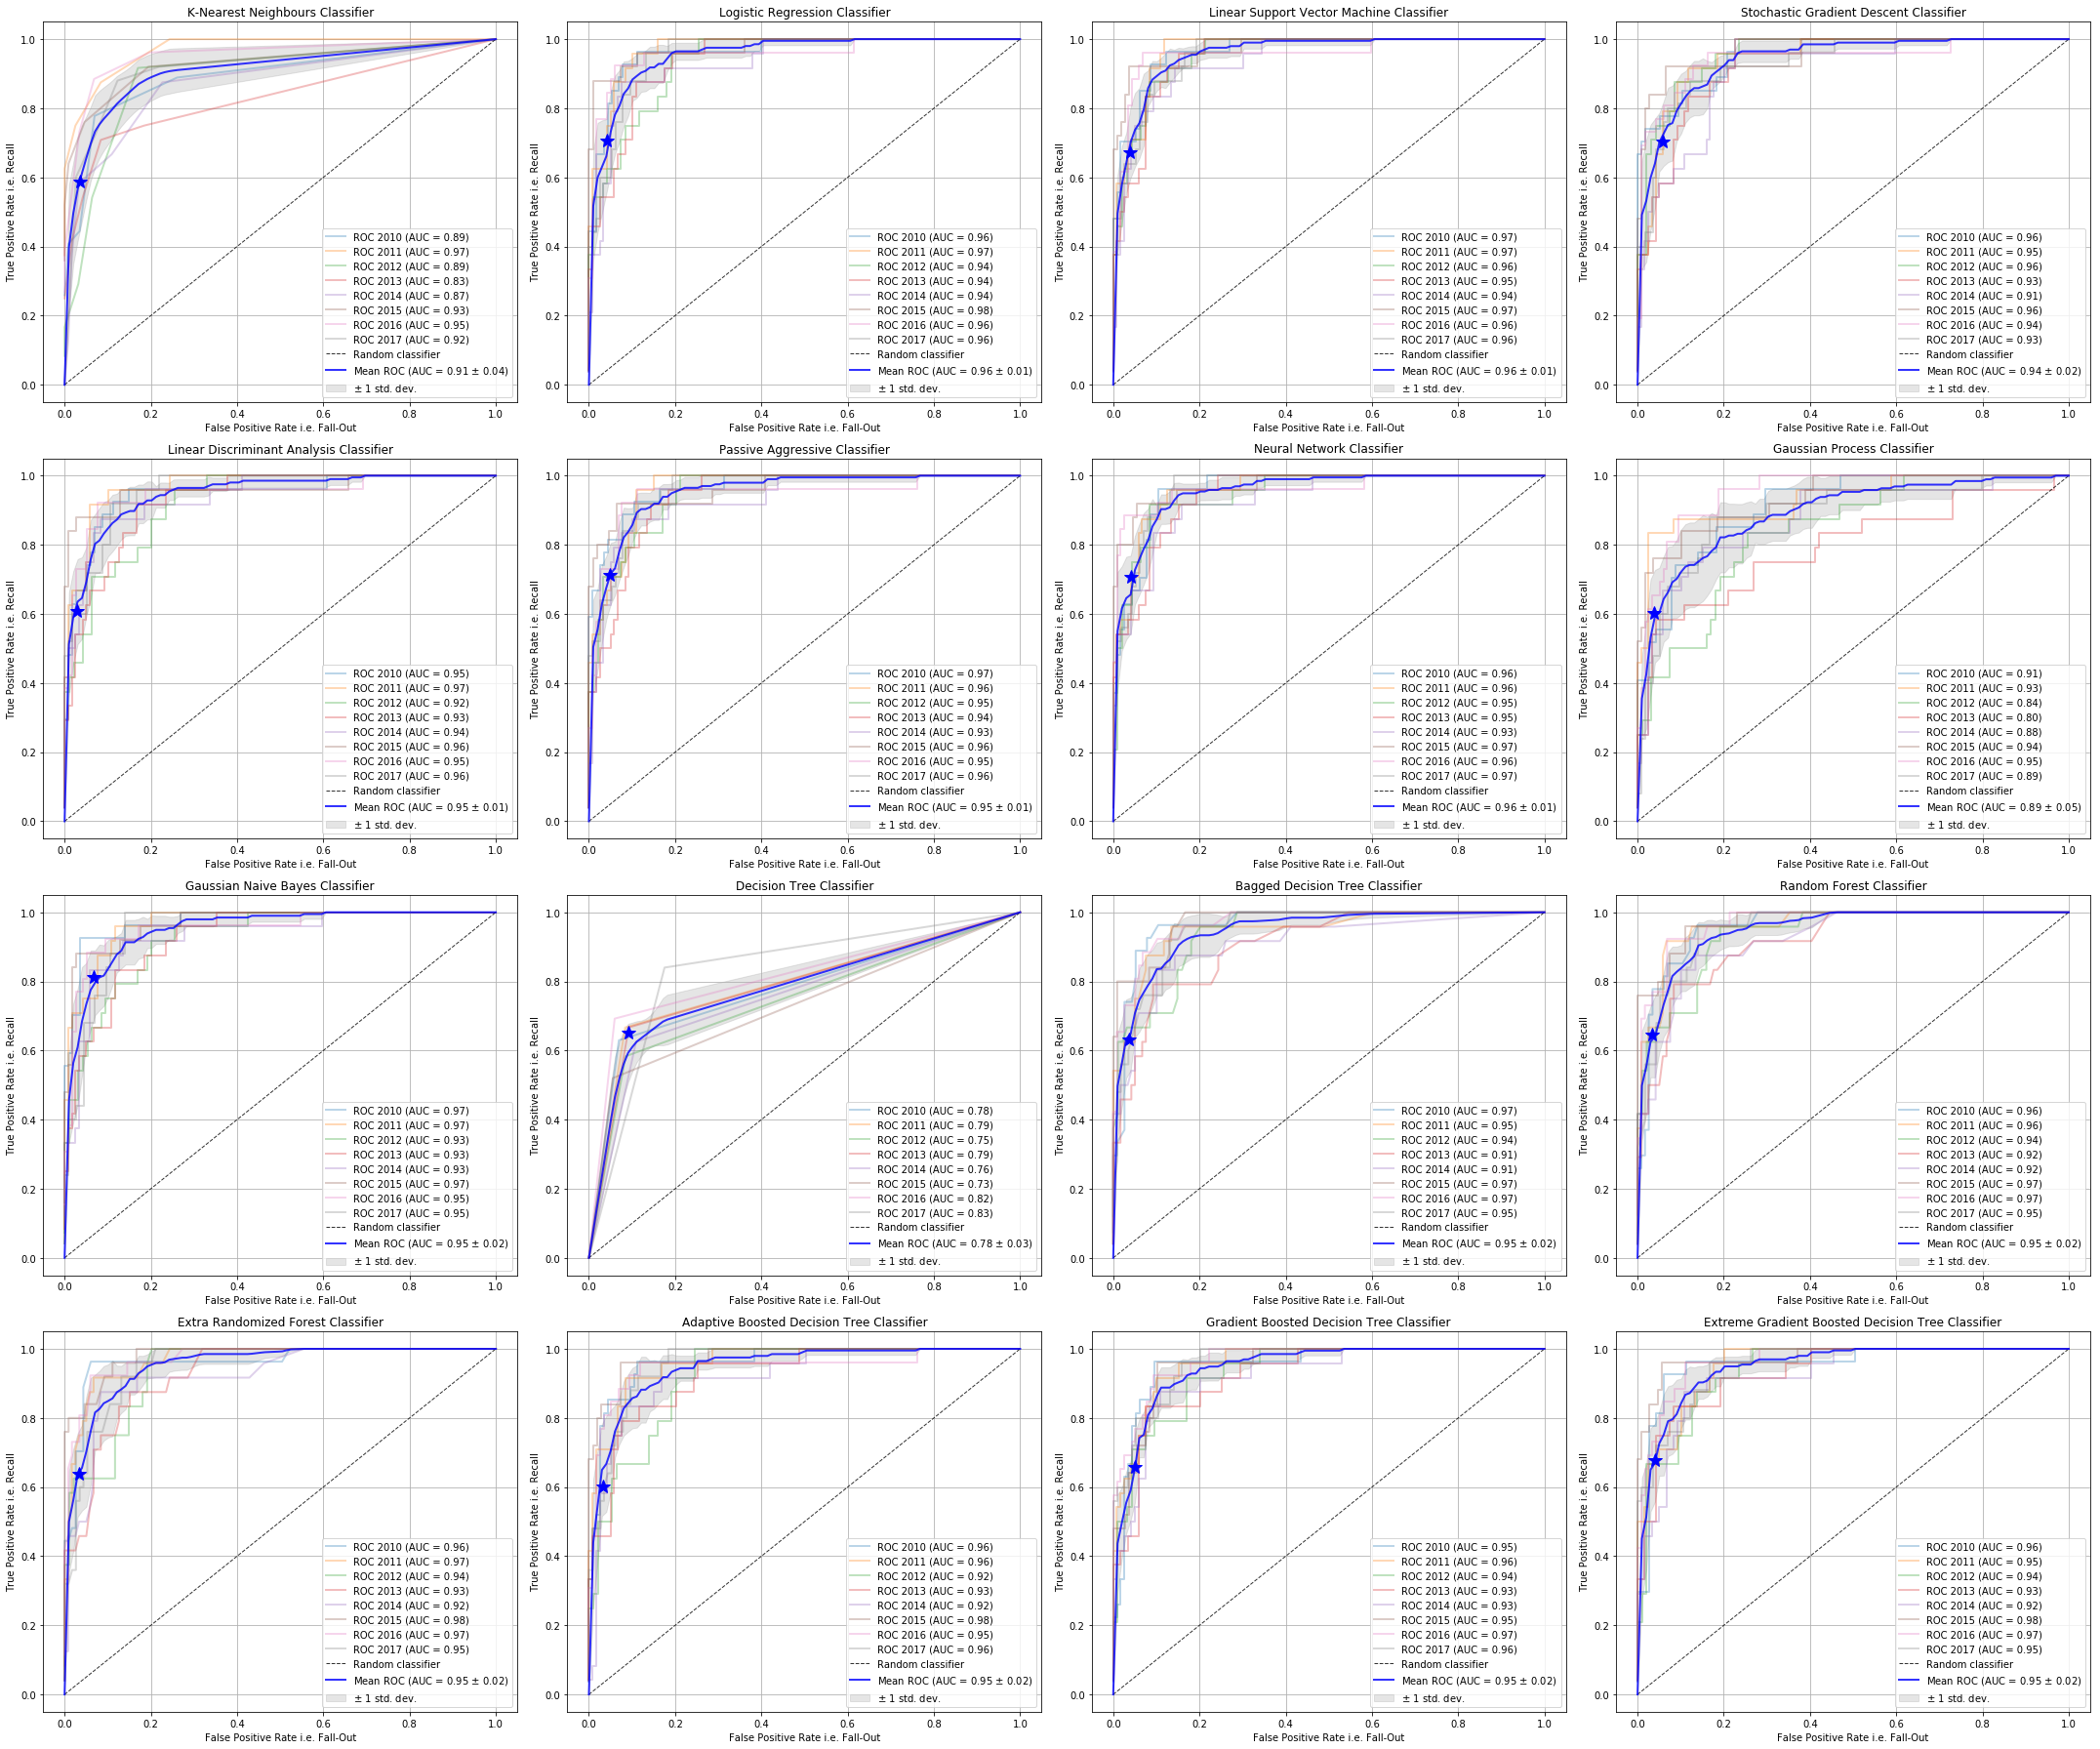

In [21]:
plt.figure(figsize=(30, 25))

for imodel, model in enumerate(models):

    plt.subplot(4, 4, imodel+1)
    
    tpr_linspaces = []
    fpr_linspace = np.linspace(0, 1, 100)
    
    for i in range(len(train_years)):
        
        tpr_linspaces.append(np.interp(fpr_linspace, model.FPR_ROC_cvgroups[i], model.TPR_ROC_cvgroups[i]))
        tpr_linspaces[-1][0] = 0.0
        plt.plot(model.FPR_ROC_cvgroups[i], model.TPR_ROC_cvgroups[i], lw=2, alpha=0.3, 
                 label="ROC {:d} (AUC = {:.2f})".format(train_years[i], model.AUC_ROC_cvgroups[i]))
        
    plt.plot([0, 1], [0, 1], linestyle='--', lw=1, color='black', label="Random classifier", alpha=.8)

    plt.plot(np.mean(model.FPR_cvgroups), np.mean(model.REC_cvgroups), 
             marker='*', color='blue', markersize=15, zorder=20)
    
    mean_tpr_linspaces = np.mean(tpr_linspaces, axis=0)
    mean_tpr_linspaces[-1] = 1.0
    plt.plot(fpr_linspace, mean_tpr_linspaces, color='blue', lw=2, alpha=.8,
             label=r"Mean ROC (AUC = {:0.2f} $\pm$ {:0.2f})".format(np.mean(model.AUC_ROC_cvgroups), 
                                                                    np.std(model.AUC_ROC_cvgroups)))
    model.fpr_linspace       = fpr_linspace
    model.mean_tpr_linspaces = mean_tpr_linspaces
    
    std_tpr_linspaces = np.std(tpr_linspaces, axis=0)
    tpr_linspaces_upper = np.minimum(mean_tpr_linspaces + std_tpr_linspaces, 1)
    tpr_linspaces_lower = np.maximum(mean_tpr_linspaces - std_tpr_linspaces, 0)
    plt.fill_between(fpr_linspace, tpr_linspaces_lower, tpr_linspaces_upper, 
                     color='grey', alpha=.2, label=r"$\pm$ 1 std. dev.")

    plt.xlim([-0.05, 1.05])
    plt.ylim([-0.05, 1.05])
    plt.xlabel("False Positive Rate i.e. Fall-Out")
    plt.ylabel("True Positive Rate i.e. Recall")
    plt.title(model.estimator_name)
    plt.legend(loc='lower right')
    plt.grid(True)
    plt.tight_layout()

 Plot the Precision-Recall curves for all models:

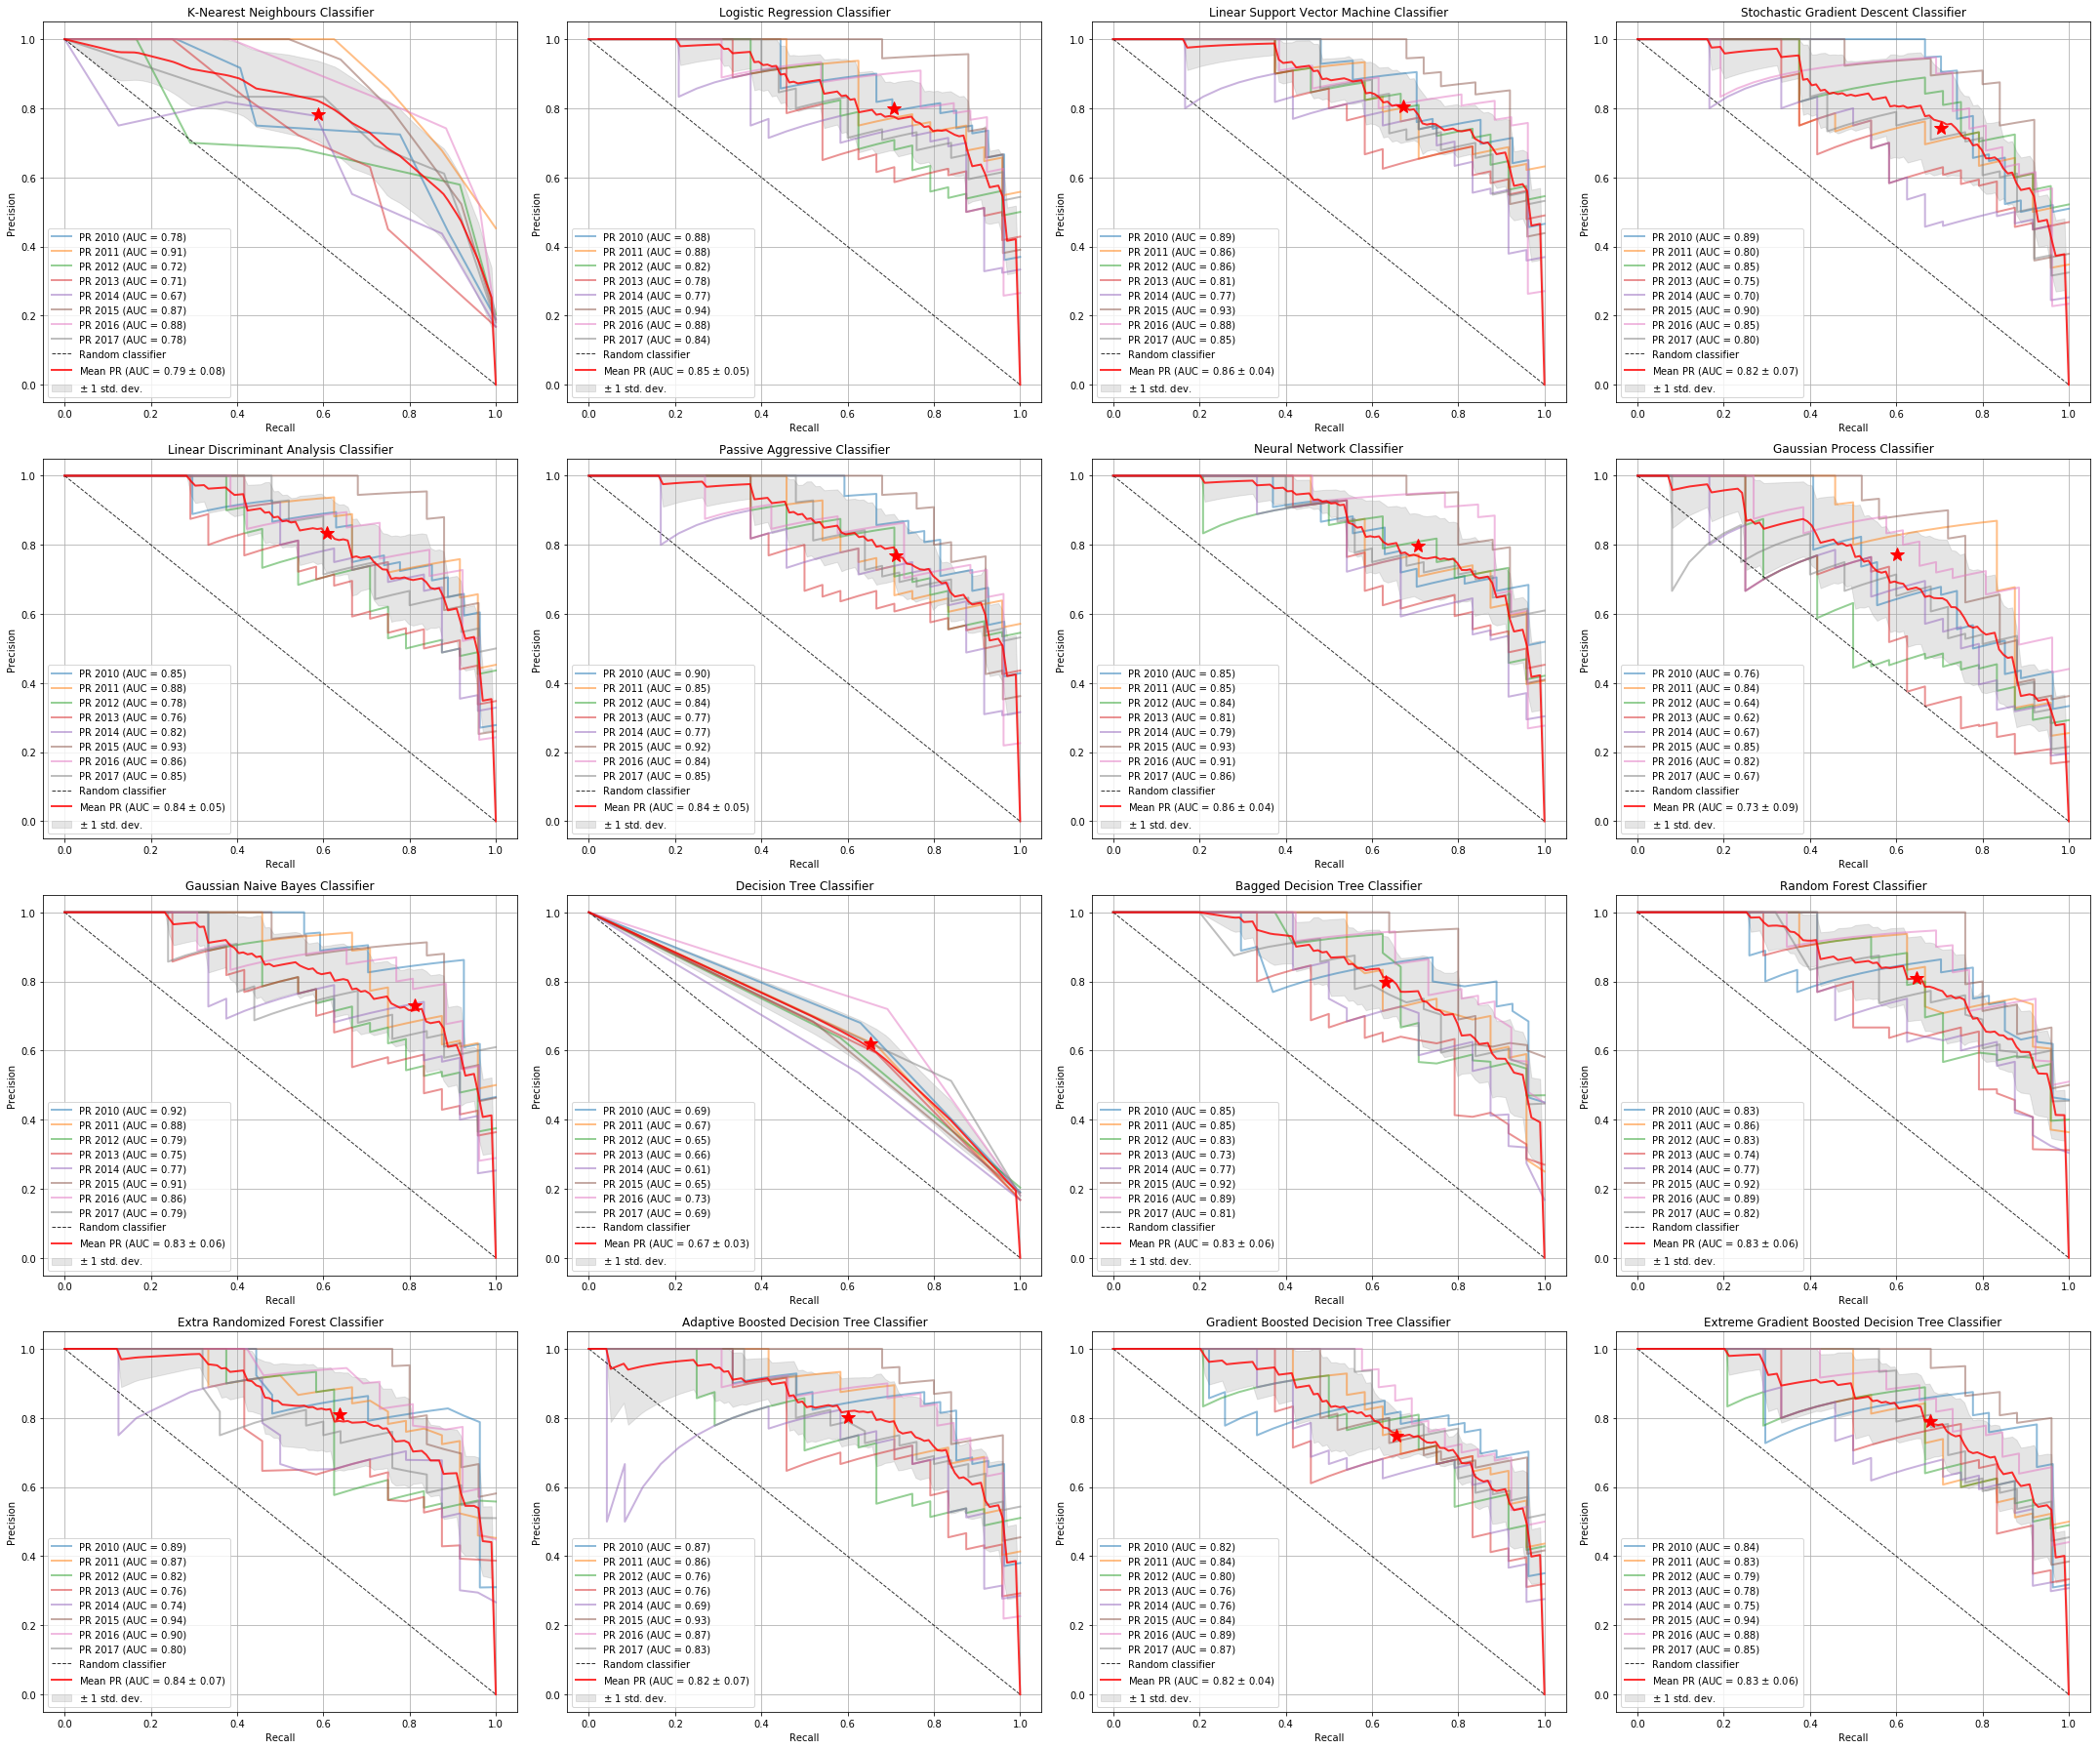

In [22]:
plt.figure(figsize=(30, 25))

for imodel, model in enumerate(models):

    plt.subplot(4, 4, imodel+1)
    
    pre_linspaces = []
    rec_linspace = np.linspace(0, 1, 100)
    
    for i in range(len(train_years)):
        
        pre_linspaces.append(np.interp(rec_linspace, model.REC_PR_cvgroups[i], model.PRE_PR_cvgroups[i]))
        pre_linspaces[-1][0] = 1.0
        plt.plot(model.REC_PR_cvgroups[i], model.PRE_PR_cvgroups[i], lw=2, alpha=0.5, 
                 label="PR {:d} (AUC = {:.2f})".format(train_years[i], model.AUC_PR_cvgroups[i]))
        
    plt.plot([0, 1], [1, 0], linestyle='--', lw=1, color='black', label="Random classifier", alpha=.8)

    plt.plot(np.mean(model.REC_cvgroups), np.mean(model.PRE_cvgroups), 
             marker='*', color='red', markersize=15, zorder=20)
    
    mean_pre_linspaces = np.mean(pre_linspaces, axis=0)
    mean_pre_linspaces[-1] = 0.0
    plt.plot(rec_linspace, mean_pre_linspaces, color='red', lw=2, alpha=.8,
             label=r"Mean PR (AUC = {:0.2f} $\pm$ {:0.2f})".format(np.mean(model.AUC_PR_cvgroups), 
                                                                    np.std(model.AUC_PR_cvgroups)))
    model.rec_linspace       = rec_linspace
    model.mean_pre_linspaces = mean_pre_linspaces

    std_pre_linspaces = np.std(pre_linspaces, axis=0)
    pre_linspaces_upper = np.minimum(mean_pre_linspaces + std_pre_linspaces, 1)
    pre_linspaces_lower = np.maximum(mean_pre_linspaces - std_pre_linspaces, 0)
    plt.fill_between(rec_linspace, pre_linspaces_lower, pre_linspaces_upper, 
                     color='grey', alpha=.2, label=r"$\pm$ 1 std. dev.")

    plt.xlim([-0.05, 1.05])
    plt.ylim([-0.05, 1.05])
    plt.xlabel("Recall")
    plt.ylabel("Precision")
    plt.title(model.estimator_name)
    plt.legend(loc="lower left")
    plt.grid(True)
    plt.tight_layout()

Plot the mean ROC and PR curves for all models in single plots for comparison:

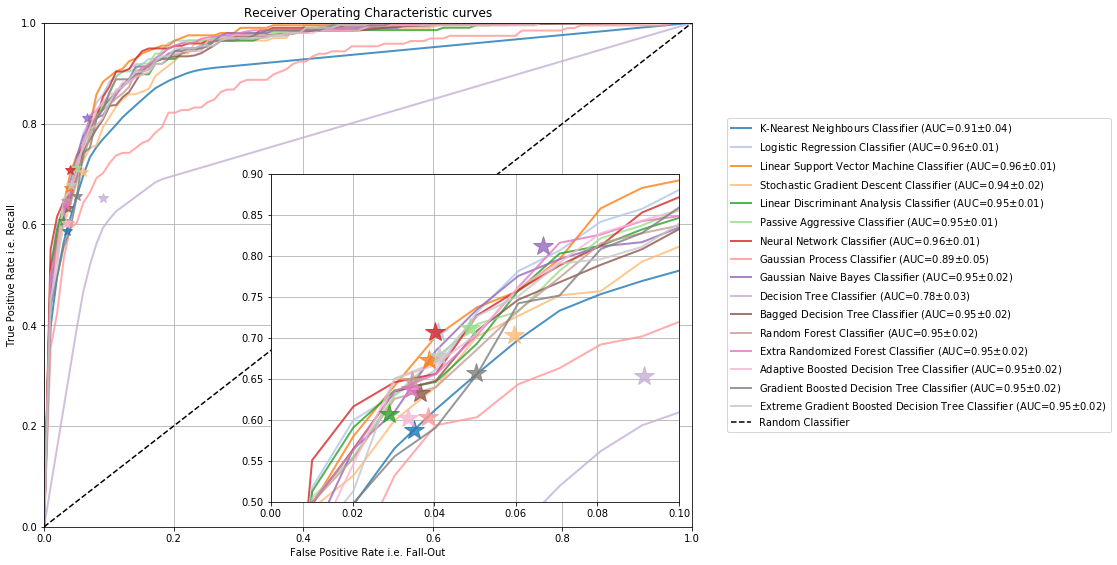

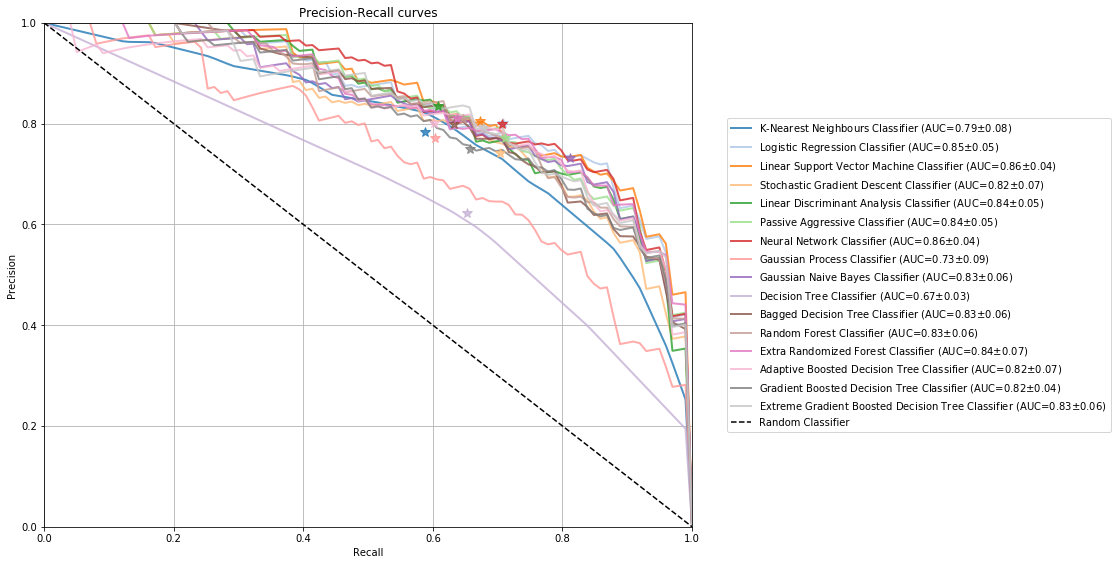

In [23]:
color = iter(plt.cm.tab20(np.linspace(0, 1, 20))) #len(models))))

fig1 = plt.figure(figsize=(9, 7))
fig2 = plt.figure(figsize=(9, 7))

ax1a = fig1.add_axes([0,0,1,1])
ax1b = fig1.add_axes([0.35, 0.05, 0.63, 0.65])
ax2  = fig2.add_axes([0,0,1,1])

for model in models:

    c=next(color)
                
    label = "{} (AUC={:.2f}$\pm${:.2f})".format(model.estimator_name, 
                                                np.mean(model.AUC_ROC_cvgroups), 
                                                np.std(model.AUC_ROC_cvgroups))
    
    ax1a.plot(model.fpr_linspace, model.mean_tpr_linspaces, color=c, lw=2, alpha=.8, label=label)
    ax1a.plot(np.mean(model.FPR_cvgroups), np.mean(model.REC_cvgroups), 
              marker='*', color=c, alpha=.8, markersize=10, zorder=20)
        
    ax1b.plot(model.fpr_linspace, model.mean_tpr_linspaces, color=c, lw=2, alpha=.8, label=label)
    ax1b.plot(np.mean(model.FPR_cvgroups), np.mean(model.REC_cvgroups),
              marker='*', color=c, alpha=.8, markersize=20, zorder=20)
    
    label = "{} (AUC={:.2f}$\pm${:.2f})".format(model.estimator_name, 
                                                np.mean(model.AUC_PR_cvgroups), 
                                                np.std(model.AUC_PR_cvgroups))
    
    ax2.plot(model.rec_linspace, model.mean_pre_linspaces, color=c, lw=2, alpha=.8, label=label)
    ax2.plot(np.mean(model.REC_cvgroups), np.mean(model.PRE_cvgroups),
             marker='*', color=c, alpha=.8, markersize=10, zorder=20)

ax1a.plot([0, 1], [0, 1], color='black', linestyle='--', label='Random Classifier')
ax1a.set_xlim(0, 1)
ax1a.set_ylim(0, 1)
ax1a.set_xlabel('False Positive Rate i.e. Fall-Out')
ax1a.set_ylabel('True Positive Rate i.e. Recall')
ax1a.set_title('Receiver Operating Characteristic curves')
ax1a.legend(loc='center', bbox_to_anchor=(1.35,0.5), numpoints=1)
ax1a.grid(True)
    
ax1b.set_xlim(0.0, 0.1)
ax1b.set_ylim(0.5, 0.9)
ax1b.grid(True)

ax2.plot([0, 1], [1, 0], color='black', linestyle='--', label='Random Classifier')
ax2.set_xlim(0, 1)
ax2.set_ylim(0, 1)
ax2.set_xlabel('Recall')
ax2.set_ylabel('Precision')
ax2.set_title('Precision-Recall curves')
ax2.legend(loc='center', bbox_to_anchor=(1.35,0.5), numpoints=1)
ax2.grid(True)

Create interactive Bokeh plot with ROC and P-R curves which can be muted by clicking on the legend labels:

In [24]:
fig1 = figure(plot_width=900, plot_height=700, tools=tools, toolbar_location='above')
fig1.title.text = "Receiver Operating Characteristic curves with mutable legend"
fig1.background_fill_color = '#dddddd'
fig1.grid.grid_line_color = 'white'   
fig1.xaxis.axis_label = "False Positive Rate i.e. Fall-Out"
fig1.yaxis.axis_label = "True Positive Rate i.e. Recall"

fig2 = figure(plot_width=900, plot_height=700, tools=tools, toolbar_location='above')
fig2.title.text = "Precision-Recall curves with mutable legend"
fig2.background_fill_color = '#dddddd'
fig2.grid.grid_line_color = 'white'   
fig2.xaxis.axis_label = "Recall"
fig2.yaxis.axis_label = "Precision"

for imodel, model in enumerate(models):

    color = Category20[len(models)][imodel]

    label = "{} (AUC={:.2f}+/-{:.2f})".format(model.estimator_name, 
                                                np.mean(model.AUC_ROC_cvgroups), 
                                                np.std(model.AUC_ROC_cvgroups))
    
    fig1.line(x=model.fpr_linspace, y=model.mean_tpr_linspaces, 
              line_width=3, color=color, alpha=0.9, 
              muted_color=color, muted_alpha=0.1, legend=label)

    label = "{} (AUC={:.2f}+/-{:.2f})".format(model.estimator_name, 
                                                np.mean(model.AUC_PR_cvgroups), 
                                                np.std(model.AUC_PR_cvgroups))

    fig2.line(x=model.rec_linspace, y=model.mean_pre_linspaces, 
              line_width=3, color=color, alpha=0.9, 
              muted_color=color, muted_alpha=0.1, legend=label)

fig1.line([0, 1], [0, 1], color='black', alpha=0.8, muted_color='black', muted_alpha=0.2, 
          line_dash='dashed', legend='Random Classifier')

fig2.line([0, 1], [1, 0], color='black', alpha=0.8, muted_color='black', muted_alpha=0.2, 
          line_dash='dashed', legend='Random Classifier')

fig1.legend.location = 'bottom_right'
fig1.legend.click_policy = 'mute'

fig2.legend.location = 'bottom_left'
fig2.legend.click_policy = 'mute'

layout = layout(fig1, fig2)

show(layout, notebook_handle=True);

#### Conclusion: 

The cross-validation metrics indicate that all classifiers included in this analysis are stable and have a reasonable performance, e.g. precision scores are 70-80%, recall scores are 60-70%. The only exception is perhaps the *Decision Tree Classifier*, which is slightly less powerful than the other models tested in this analysis.

In [25]:
rejected_models = [9] # i.e. DT

Calculate feature importances of all fitted Decision Tree ensemble models (e.g. Random Forest):

In [26]:
df_importances = pd.DataFrame() #index=feature_names, columns=model_names)

for model in models:
    
    if hasattr(model.estimator, "feature_importances_"):
    
        #print("--> Calculating feature importances for", model.estimator_name, "...")
        
        cv_importances = model.cv_importances
        
        df_cv_importances = pd.DataFrame(cv_importances, columns=feature_names)
                        
        mean_cv_importances = np.mean(df_cv_importances, axis=0)
        std_cv_importances  = np.std (df_cv_importances, axis=0)
        
        for i in range(n_features):
            df_importances.loc[feature_names[i], model.estimator_name] = \
                "{:.2f} $\pm$ {:.2f}".format((mean_cv_importances[i]*100), (std_cv_importances[i]*100))

#print("")
print("--> Feature importances of all models (mean +/- std over all CV years):")
df_importances.dropna(axis=1, how='all', inplace=True)
display(df_importances)

--> Feature importances of all models (mean +/- std over all CV years):


Decision Tree Classifier Random Forest Classifier  \
G               1.38 $\pm$ 0.52          1.63 $\pm$ 0.15   
GS              2.76 $\pm$ 1.60          1.97 $\pm$ 0.20   
MP/G            8.09 $\pm$ 3.82          7.83 $\pm$ 0.74   
PTS/48         25.88 $\pm$ 8.22         13.88 $\pm$ 0.85   
PER             9.97 $\pm$ 7.97         16.50 $\pm$ 0.51   
TS%             3.34 $\pm$ 1.17          2.57 $\pm$ 0.16   
TRB%            2.51 $\pm$ 1.56          3.02 $\pm$ 0.15   
AST%            6.48 $\pm$ 1.83          4.17 $\pm$ 0.39   
STL%            2.82 $\pm$ 0.74          2.28 $\pm$ 0.16   
BLK%            2.49 $\pm$ 1.15          1.95 $\pm$ 0.20   
USG%            5.85 $\pm$ 6.44          8.72 $\pm$ 0.68   
OWS/48          4.46 $\pm$ 1.64          6.26 $\pm$ 0.69   
DWS/48          8.69 $\pm$ 1.12          4.99 $\pm$ 0.42   
OBPM            4.42 $\pm$ 1.46          6.24 $\pm$ 0.50   
DBPM            1.28 $\pm$ 1.23          2.64 $\pm$ 0.16   
VORP            6.47 $\pm$ 6.12         11.07 $\pm$ 1.10   
TW              3.10 $\pm$ 0.92          4.27 $\pm$ 0.54   

       Extra Randomized Forest Classifier  \
G                         2.41 $\pm$ 0.12   
GS                        2.92 $\pm$ 0.12   
MP/G                      7.79 $\pm$ 0.58   
PTS/48                   10.60 $\pm$ 0.47   
PER                      14.77 $\pm$ 0.98   
TS%                       3.50 $\pm$ 0.19   
TRB%                      3.11 $\pm$ 0.10   
AST%                      4.58 $\pm$ 0.30   
STL%                      2.95 $\pm$ 0.12   
BLK%                      2.71 $\pm$ 0.08   
USG%                      9.60 $\pm$ 0.65   
OWS/48                    7.24 $\pm$ 0.28   
DWS/48                    4.54 $\pm$ 0.27   
OBPM                      6.75 $\pm$ 0.38   
DBPM                      3.13 $\pm$ 0.22   
VORP                      8.61 $\pm$ 0.63   
TW                        4.81 $\pm$ 0.31   

       Adaptive Boosted Decision Tree Classifier  \
G                                0.50 $\pm$ 1.32   
GS                               4.00 $\pm$ 1.66   
MP/G                            15.88 $\pm$ 2.37   
PTS/48                           8.00 $\pm$ 2.00   
PER                             13.75 $\pm$ 1.56   
TS%                              0.00 $\pm$ 0.00   
TRB%                             2.62 $\pm$ 1.93   
AST%                             6.75 $\pm$ 1.92   
STL%                             0.88 $\pm$ 1.17   
BLK%                             0.00 $\pm$ 0.00   
USG%                             8.38 $\pm$ 3.20   
OWS/48                           0.62 $\pm$ 0.99   
DWS/48                           9.50 $\pm$ 4.03   
OBPM                             4.88 $\pm$ 3.10   
DBPM                             2.25 $\pm$ 1.79   
VORP                             3.12 $\pm$ 0.60   
TW                              18.88 $\pm$ 1.62   

       Gradient Boosted Decision Tree Classifier  \
G                                1.07 $\pm$ 0.62   
GS                               1.91 $\pm$ 0.54   
MP/G                            15.95 $\pm$ 1.31   
PTS/48                          10.09 $\pm$ 1.48   
PER                             11.59 $\pm$ 1.55   
TS%                              5.79 $\pm$ 1.51   
TRB%                             4.85 $\pm$ 1.63   
AST%                             5.52 $\pm$ 0.99   
STL%                             3.10 $\pm$ 0.60   
BLK%                             2.06 $\pm$ 0.66   
USG%                             5.11 $\pm$ 0.41   
OWS/48                           3.01 $\pm$ 0.96   
DWS/48                          10.26 $\pm$ 1.36   
OBPM                             5.63 $\pm$ 1.34   
DBPM                             4.65 $\pm$ 0.79   
VORP                             3.88 $\pm$ 0.86   
TW                               5.52 $\pm$ 0.71   

       Extreme Gradient Boosted Decision Tree Classifier  
G                                        2.08 $\pm$ 1.03  
GS                                       4.32 $\pm$ 0.62  
MP/G                                    16.62 $\pm$ 2.05  
PTS/4

Calculate feature coefficients of all fitted linear models (e.g. Logistic Regression):

In [27]:
df_coefficients = pd.DataFrame() #index=feature_names, columns=model_names)

for model in models:
    
    if hasattr(model.estimator, "coef_"):
    
        #print("--> Calculating feature coefficients for", model.estimator_name, "...")
        
        cv_coefficients = model.cv_coefficients
        
        df_cv_coefficients = pd.DataFrame(cv_coefficients, columns=feature_names)
                        
        mean_cv_coefficients = np.mean(df_cv_coefficients, axis=0)
        std_cv_coefficients  = np.std (df_cv_coefficients, axis=0)
        
        for i in range(n_features):
            df_coefficients.loc[feature_names[i], model.estimator_name] = \
                "{:.2f} $\pm$ {:.2f}".format((mean_cv_coefficients[i]), (std_cv_coefficients[i]))

#print("")
print("--> Feature coefficients of all models (mean +/- std over all CV years):")
df_coefficients.dropna(axis=1, how='all', inplace=True)
display(df_coefficients)

--> Feature coefficients of all models (mean +/- std over all CV years):


Logistic Regression Classifier  \
G                    -0.04 $\pm$ 0.01   
GS                    0.08 $\pm$ 0.02   
MP/G                  0.43 $\pm$ 0.04   
PTS/48                0.31 $\pm$ 0.03   
PER                   0.40 $\pm$ 0.02   
TS%                  -0.02 $\pm$ 0.04   
TRB%                  0.08 $\pm$ 0.03   
AST%                  0.26 $\pm$ 0.04   
STL%                 -0.11 $\pm$ 0.03   
BLK%                 -0.01 $\pm$ 0.03   
USG%                  0.43 $\pm$ 0.02   
OWS/48                0.24 $\pm$ 0.03   
DWS/48                0.28 $\pm$ 0.03   
OBPM                  0.04 $\pm$ 0.02   
DBPM                  0.02 $\pm$ 0.02   
VORP                  0.31 $\pm$ 0.03   
TW                    0.35 $\pm$ 0.02   

       Linear Support Vector Machine Classifier  \
G                              -0.58 $\pm$ 0.05   
GS                              0.70 $\pm$ 0.07   
MP/G                            0.41 $\pm$ 0.06   
PTS/48                         -0.32 $\pm$ 0.11   
PER                             0.71 $\pm$ 0.14   
TS%                             0.12 $\pm$ 0.03   
TRB%                           -0.08 $\pm$ 0.05   
AST%                            0.09 $\pm$ 0.02   
STL%                           -0.13 $\pm$ 0.03   
BLK%                           -0.02 $\pm$ 0.05   
USG%                            0.46 $\pm$ 0.12   
OWS/48                         -0.07 $\pm$ 0.11   
DWS/48                          0.24 $\pm$ 0.06   
OBPM                           -0.31 $\pm$ 0.11   
DBPM                           -0.29 $\pm$ 0.11   
VORP                            0.34 $\pm$ 0.14   
TW                              0.24 $\pm$ 0.04   

           Stochastic Gradient Descent Classifier  \
G       -17614992683893.76 $\pm$ 4165259181800.48   
GS       18560765270187.72 $\pm$ 4314042048689.14   
MP/G     21789854170251.25 $\pm$ 3784062364522.84   
PTS/48    -947690106170.94 $\pm$ 3056944298706.64   
PER      15479858767349.83 $\pm$ 2974529250815.36   
TS%       1199158533340.68 $\pm$ 3928095341333.93   
TRB%        98497010811.65 $\pm$ 3185529588321.88   
AST%     11729454044335.63 $\pm$ 3271055168262.18   
STL%     -2842234974565.94 $\pm$ 3642938972383.23   
BLK%       662365358191.93 $\pm$ 3033428313786.91   
USG%     10271660911408.16 $\pm$ 3147270566996.34   
OWS/48    2007193054795.59 $\pm$ 3274658292225.38   
DWS/48   11282292763526.03 $\pm$ 4517673934675.50   
OBPM     -5120768579917.62 $\pm$ 2992980654745.51   
DBPM     -2939377101462.19 $\pm$ 3610266041540.31   
VORP      3722169624292.83 $\pm$ 4988835195318.54   
TW        7480034601304.08 $\pm$ 4305003895744.12   

       Linear Discriminant Analysis Classifier Passive Aggressive Classifier  
G                             -0.34 $\pm$ 0.05              -0.18 $\pm$ 0.04  
GS                            -0.15 $\pm$ 0.04               0.19 $\pm$ 0.07  
MP/G                           0.05 $\pm$ 0.11               0.54 $\pm$ 0.07  
PTS/48                        -0.28 $\pm$ 0.42               0.06 $\pm$ 0.05  
PER                            0.34 $\pm$ 0.36               0.36 $\pm$ 0.03  
TS%                           -0.36 $\pm$ 0.07               0.05 $\pm$ 0.05  
TRB%                          -0.33 $\pm$ 0.10               0.03 $\pm$ 0.07  
AST%                           0.21 $\pm$ 0.06               0.29 $\pm$ 0.03  
STL%                          -0.10 $\pm$ 0.10              -0.07 $\pm$ 0.06  
BLK%                          -0.13 $\pm$ 0.12               0.03 $\pm$ 0.05  
USG%                           1.83 $\pm$ 0.49               0.31 $\pm$ 0.04  
OWS/48                         1.91 $\pm$ 0.28               0.09 $\pm$ 0.04  
DWS/48                         0.31 $\pm$ 0.17               0.27 $\pm$ 0.06  
OBPM                          -3.99 $\pm$ 0.21              -0.12 $\pm$ 0.06  
DBPM                          -1.73 $\pm$ 0.18              -0.08 $\pm$ 0.05  
VORP                           4.39 $\pm$ 0.31               0.14 $\pm$ 0.07  
TW                             0.49 $\pm$ 0.09     

## Model training and predictions

Fit all models to training data and use fitted models to predict the NBA All-Stars from *test_year*:

In [28]:
scores_list = []

for model in models:
    
    classifier = model.estimator

    #print("--> Fitting", model.estimator_name, "...")
    
    classifier.fit(X_train, y_train)          # Fit model to training data

    y_prediction = classifier.predict(X_test) # Predict test data
    model.set_y_prediction(y_prediction)
    
    if test_year_truth_is_known:

        y_truth = y_test.tolist()
        model.set_y_truth(y_truth)
    
        CM = confusion_matrix(y_truth, y_prediction) # defined as: rows -> truth, columns -> prediction
        model.set_CM(CM)
    
        scores_list.append({'Estimator' : model.estimator_name, 
                            'TP'        : model.CM.TP, 
                            'FP'        : model.CM.FP, 
                            'FN'        : model.CM.FN, 
                            'TN'        : model.CM.TN, 
                            'Precision' : model.CM.precision.round(3)*100, 
                            'Recall'    : model.CM.recall.round(3)*100, 
                            'F1'        : model.CM.f1.round(3)*100, 
                            'Accuracy'  : model.CM.accuracy.round(3)*100,
                            'FPR'       : model.CM.fpr.round(3)*100})
    
    '''
    print("")
    print("--> Confusion matrix {}:".format(test_year))
    print(CM)
    print("")

    TN = CM[0,0] # defined as: 0 = negative, 1 = positive
    FN = CM[1,0] # defined as: 0 = negative, 1 = positive
    FP = CM[0,1] # defined as: 0 = negative, 1 = positive
    TP = CM[1,1] # defined as: 0 = negative, 1 = positive

    TOT = TP + FP + FN + TN

    print("--> TP = {}, FP = {}, FN = {}, TN = {}".format(TP, FP ,FN , TN))
    print("")
    print("--> True  Positive Rate i.e. Recall   (TP/(TP+FN)) = {:5.1%}".format(TP/(TP+FN)))
    print("--> False Positive Rate i.e. Fall-Out (FP/(FP+TN)) = {:5.1%}".format(FP/(FP+TN)))
    print("")

    precision = precision_score(y_test, y_prediction)
    recall    = recall_score   (y_test, y_prediction)
    f1        = f1_score       (y_test, y_prediction)
    accuracy  = accuracy_score (y_test, y_prediction)
    
    print("--> Precision score (TP/(TP+FP)) : {:.1%}".format(precision) + note1)
    print("--> Recall score    (TP/(TP+FN)) : {:.1%}".format(recall   ) + note2)
    print("--> F1 score                     : {:.1%}".format(f1       ) + note3)
    print("--> Accuracy score ((TP+TN)/TOT) : {:.1%}".format(accuracy ) + note4)
    print("")
    '''

if test_year_truth_is_known:
    #print("")
    print("--> Classification scores of all models for", test_year, ":")
    columnorder = ['Estimator', 'TP', 'FP', 'FN', 'TN', 'Precision', 'Recall', 'F1', 'Accuracy', 'FPR']
    df_scores = pd.DataFrame(scores_list, columns=columnorder)
    display(df_scores)

--> Classification scores of all models for 2018 :


Estimator  TP  FP  FN   TN  \
0                     K-Nearest Neighbours Classifier  20   5   8  108   
1                      Logistic Regression Classifier  19   5   9  108   
2            Linear Support Vector Machine Classifier  17   4  11  109   
3              Stochastic Gradient Descent Classifier  12   4  16  109   
4             Linear Discriminant Analysis Classifier  16   3  12  110   
5                       Passive Aggressive Classifier  16   2  12  111   
6                           Neural Network Classifier  19   5   9  108   
7                         Gaussian Process Classifier  19   3   9  110   
8                     Gaussian Naive Bayes Classifier  22   8   6  105   
9                            Decision Tree Classifier  21   6   7  107   
10                    Bagged Decision Tree Classifier  19   5   9  108   
11                           Random Forest Classifier  21   4   7  109   
12                 Extra Randomized Forest Classifier  20   3   8  110   
13          Adaptive Boosted Decision Tree Classifier  17   2  11  111   
14          Gradient Boosted Decision Tree Classifier  17   5  11  108   
15  Extreme Gradient Boosted Decision Tree Classifier  18   3  10  110   

    Precision  Recall    F1  Accuracy  FPR  
0        80.0    71.4  75.5      90.8  4.4  
1        79.2    67.9  73.1      90.1  4.4  
2        81.0    60.7  69.4      89.4  3.5  
3        75.0    42.9  54.5      85.8  3.5  
4        84.2    57.1  68.1      89.4  2.7  
5        88.9    57.1  69.6      90.1  1.8  
6        79.2    67.9  73.1      90.1  4.4  
7        86.4    67.9  76.0      91.5  2.7  
8        73.3    78.6  75.9      90.1  7.1  
9        77.8    75.0  76.4      90.8  5.3  
10       79.2    67.9  73.1      90.1  4.4  
11       84.0    75.0  79.2      92.2  3.5  
12       87.0    71.4  78.4      92.2  2.7  
13       89.5    60.7  72.3      90.8  1.8  
14       77.3    60.7  68.0      88.7  4.4  
15       85.7    64.3  73.5      90.8  2.7

Plot Confusion Matrices for all fitted models:

Print classification reports for all fitted models:

In [29]:
if test_year_truth_is_known:

    for model in models:
    
        print("--> {} classification report {}:".format(model.estimator_name, test_year))
        print("")
        class_names = ['Non-All-Stars (truth)', 'All-Stars (truth)']
        print(classification_report(model.y_truth, model.y_prediction, target_names=class_names))
else:
    print("--> The NBA All-Stars for {} have not been selected yet".format(test_year))

--> K-Nearest Neighbours Classifier classification report 2018:

                       precision    recall  f1-score   support

Non-All-Stars (truth)       0.93      0.96      0.94       113
    All-Stars (truth)       0.80      0.71      0.75        28

          avg / total       0.91      0.91      0.91       141

--> Logistic Regression Classifier classification report 2018:

                       precision    recall  f1-score   support

Non-All-Stars (truth)       0.92      0.96      0.94       113
    All-Stars (truth)       0.79      0.68      0.73        28

          avg / total       0.90      0.90      0.90       141

--> Linear Support Vector Machine Classifier classification report 2018:

                       precision    recall  f1-score   support

Non-All-Stars (truth)       0.91      0.96      0.94       113
    All-Stars (truth)       0.81      0.61      0.69        28

          avg / total       0.89      0.89      0.89       141

--> Stochastic Gradient Descent 

Calculate feature importances of all fitted Decision Tree ensemble models (e.g. Random Forest):

In [30]:
df_importances = pd.DataFrame() #index=feature_names, columns=model_names)

for model in models:

    #print("--> Calculating feature importances for", model.estimator_name, "...")
    #print("")
    
    if hasattr(model.estimator, "feature_importances_"):
    
        importances = model.estimator.feature_importances_
        #indices = np.argsort(importances)[::-1]
    
        for i in range(n_features):
            #print("----> Feature importance ({:>2}) {:6} : {:.3f}".format(i + 1, feature_names[indices[i]], importances[indices[i]]))
            df_importances.loc[feature_names[i], model.estimator_name] = (importances[i]*100).round(1)
        
        #print("")
                
#print("")
print("--> Feature importances of all models:")
df_importances.dropna(axis=1, how='all', inplace=True)
cm = sns.diverging_palette(240, 10, n=9, as_cmap=True)
df_importances_style = df_importances.style.background_gradient(cmap=cm, axis=0)
display(df_importances_style)

--> Feature importances of all models:


Calculate feature coefficients of all fitted linear models (e.g. Logistic Regression):

In [31]:
df_coefficients = pd.DataFrame(index=feature_names, columns=model_names)

for model in models:

    #print("--> Calculating feature coefficients for", model.estimator_name, "...")
    #print("")
    
    if hasattr(model.estimator, "coef_"):
    
        coefficients = model.estimator.coef_.ravel()
    
        #for feature_name, coefficient in zip(feature_names, coefficients):
        #    print("----> Model coefficient {:6} ({:2}) = {:>6.3f}".format(feature_name, counter, coefficient))
        
        for i in range(n_features):
            df_coefficients.loc[feature_names[i], model.estimator_name] = coefficients[i].round(2)
        
        #print("")

#print("")
print("--> Feature coefficients of all models:")
df_coefficients.dropna(axis=1, how='all', inplace=True)
display(df_coefficients)

--> Feature coefficients of all models:


Logistic Regression Classifier  \
G                               -0.05   
GS                               0.09   
MP/G                             0.46   
PTS/48                           0.31   
PER                              0.41   
TS%                             -0.02   
TRB%                             0.08   
AST%                             0.27   
STL%                            -0.11   
BLK%                            -0.01   
USG%                             0.44   
OWS/48                           0.24   
DWS/48                            0.3   
OBPM                             0.03   
DBPM                             0.01   
VORP                             0.31   
TW                               0.36   

       Linear Support Vector Machine Classifier  \
G                                         -0.62   
GS                                         0.75   
MP/G                                       0.41   
PTS/48                                    -0.34   
PER                                        0.72   
TS%                                        0.11   
TRB%                                      -0.09   
AST%                                       0.09   
STL%                                      -0.13   
BLK%                                      -0.02   
USG%                                       0.47   
OWS/48                                    -0.07   
DWS/48                                     0.24   
OBPM                                       -0.3   
DBPM                                       -0.3   
VORP                                       0.34   
TW                                         0.24   

       Stochastic Gradient Descent Classifier  \
G                                   -2.14e+13   
GS                                   1.51e+13   
MP/G                                 1.94e+13   
PTS/48                              -3.03e+12   
PER                                  1.33e+13   
TS%                                  6.93e+12   
TRB%                                 -2.4e+12   
AST%                                 3.86e+12   
STL%                                 -1.2e+11   
BLK%                                 1.58e+12   
USG%                                 6.01e+12   
OWS/48                                4.8e+12   
DWS/48                               6.79e+12   
OBPM                                -1.08e+13   
DBPM                                -8.76e+12   
VORP                                -5.37e+12   
TW                                    8.9e+12   

       Linear Discriminant Analysis Classifier Passive Aggressive Classifier  
G                                        -0.34                         -0.28  
GS                                       -0.15                          0.14  
MP/G                                      0.05                          0.47  
PTS/48                                   -0.31                          0.05  
PER                                       0.33                          0.35  
TS%                                      -0.36                          0.16  
TRB%                                     -0.33                          0.01  
AST%                                       0.2                          0.18  
STL%                                      -0.1                         -0.09  
BLK%                                     -0.12                         -0.04  
USG%                                      1.86                          0.29  
OWS/48                                    1.92                          0.14  
DWS/48                                    0.32                          0.24  
OBPM                                     -3.96                         -0.19  
DBPM                                     -1.73                         -0.18  
VORP                                      4.36                            -0  
TW                                        0.48                          0.33

Plot Logistic Curves for each feature for the fitted Logistic Regression Classifier:

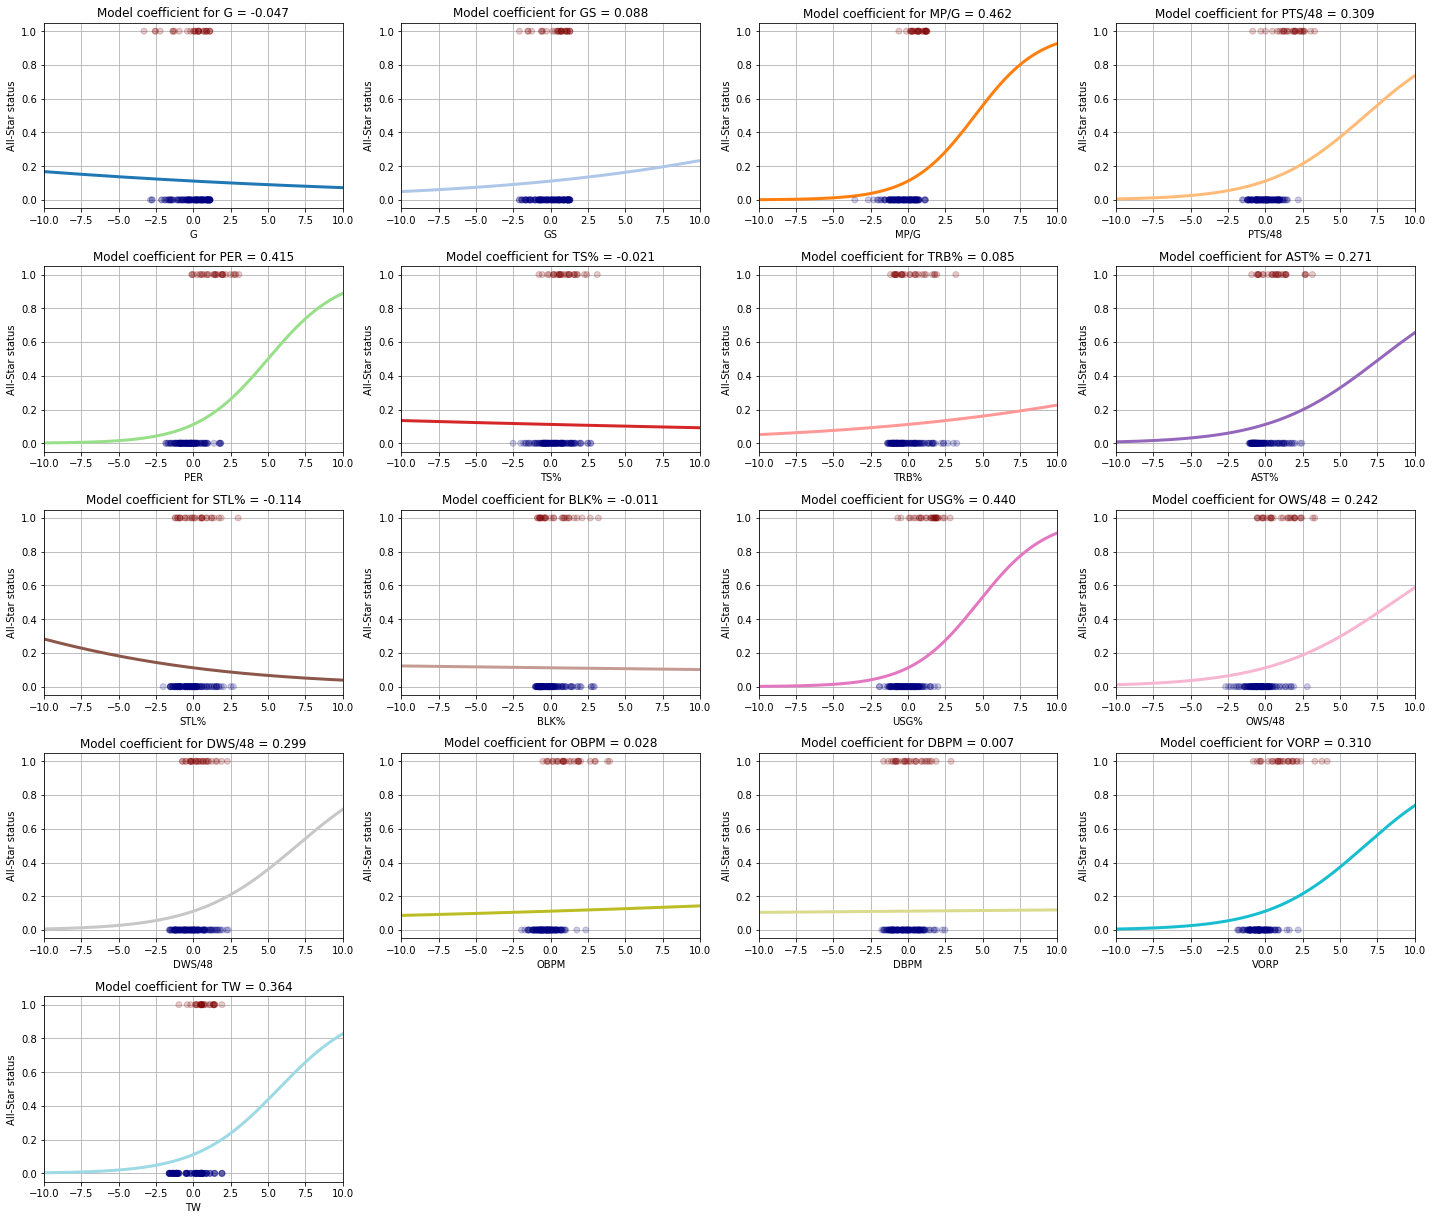

In [32]:
model = models[1].estimator # Logistic Regression Classifier

color=iter(plt.cm.tab20(np.linspace(0, 1, n_features)))    

feature_linspace = np.linspace(-10, 10, 300)

plt.figure(figsize=(20, 20))

for i, (feature_name, coefficient) in enumerate(zip(feature_names, model.coef_.ravel())):
    
    plt.subplot(6, 4, i+1)

    feature_data  = X_test[:,i]
    ASstatus_data = y_test.ravel()
    
    plt.scatter(feature_data, ASstatus_data, c=ASstatus_data, cmap='jet', alpha=.2, zorder=20)
        
    logfunc = NBAanalysissetup.logistic_function(feature_linspace*coefficient + model.intercept_).ravel()

    plt.plot(feature_linspace, logfunc, color=next(color), linewidth=3, label=feature_name)

    plt.xlim([-10, 10])
    plt.ylim([-0.05, 1.05])
    plt.title("Model coefficient for {} = {:.3f}".format(feature_name, coefficient))
    plt.xlabel(feature_name)
    plt.ylabel('All-Star status')
    plt.grid(True)
    plt.tight_layout()

Plot decision function values / probability scores in 2-D feature space for all models:

Data features: G, GS, MP/G, PTS/48, PER, TS%, TRB%, AST%, STL%, BLK%, USG%, OWS/48, DWS/48, OBPM, DBPM, VORP, TW, PCA1, PCA2
--> Probability score / Decision function contours in PER-VORP space for all models:


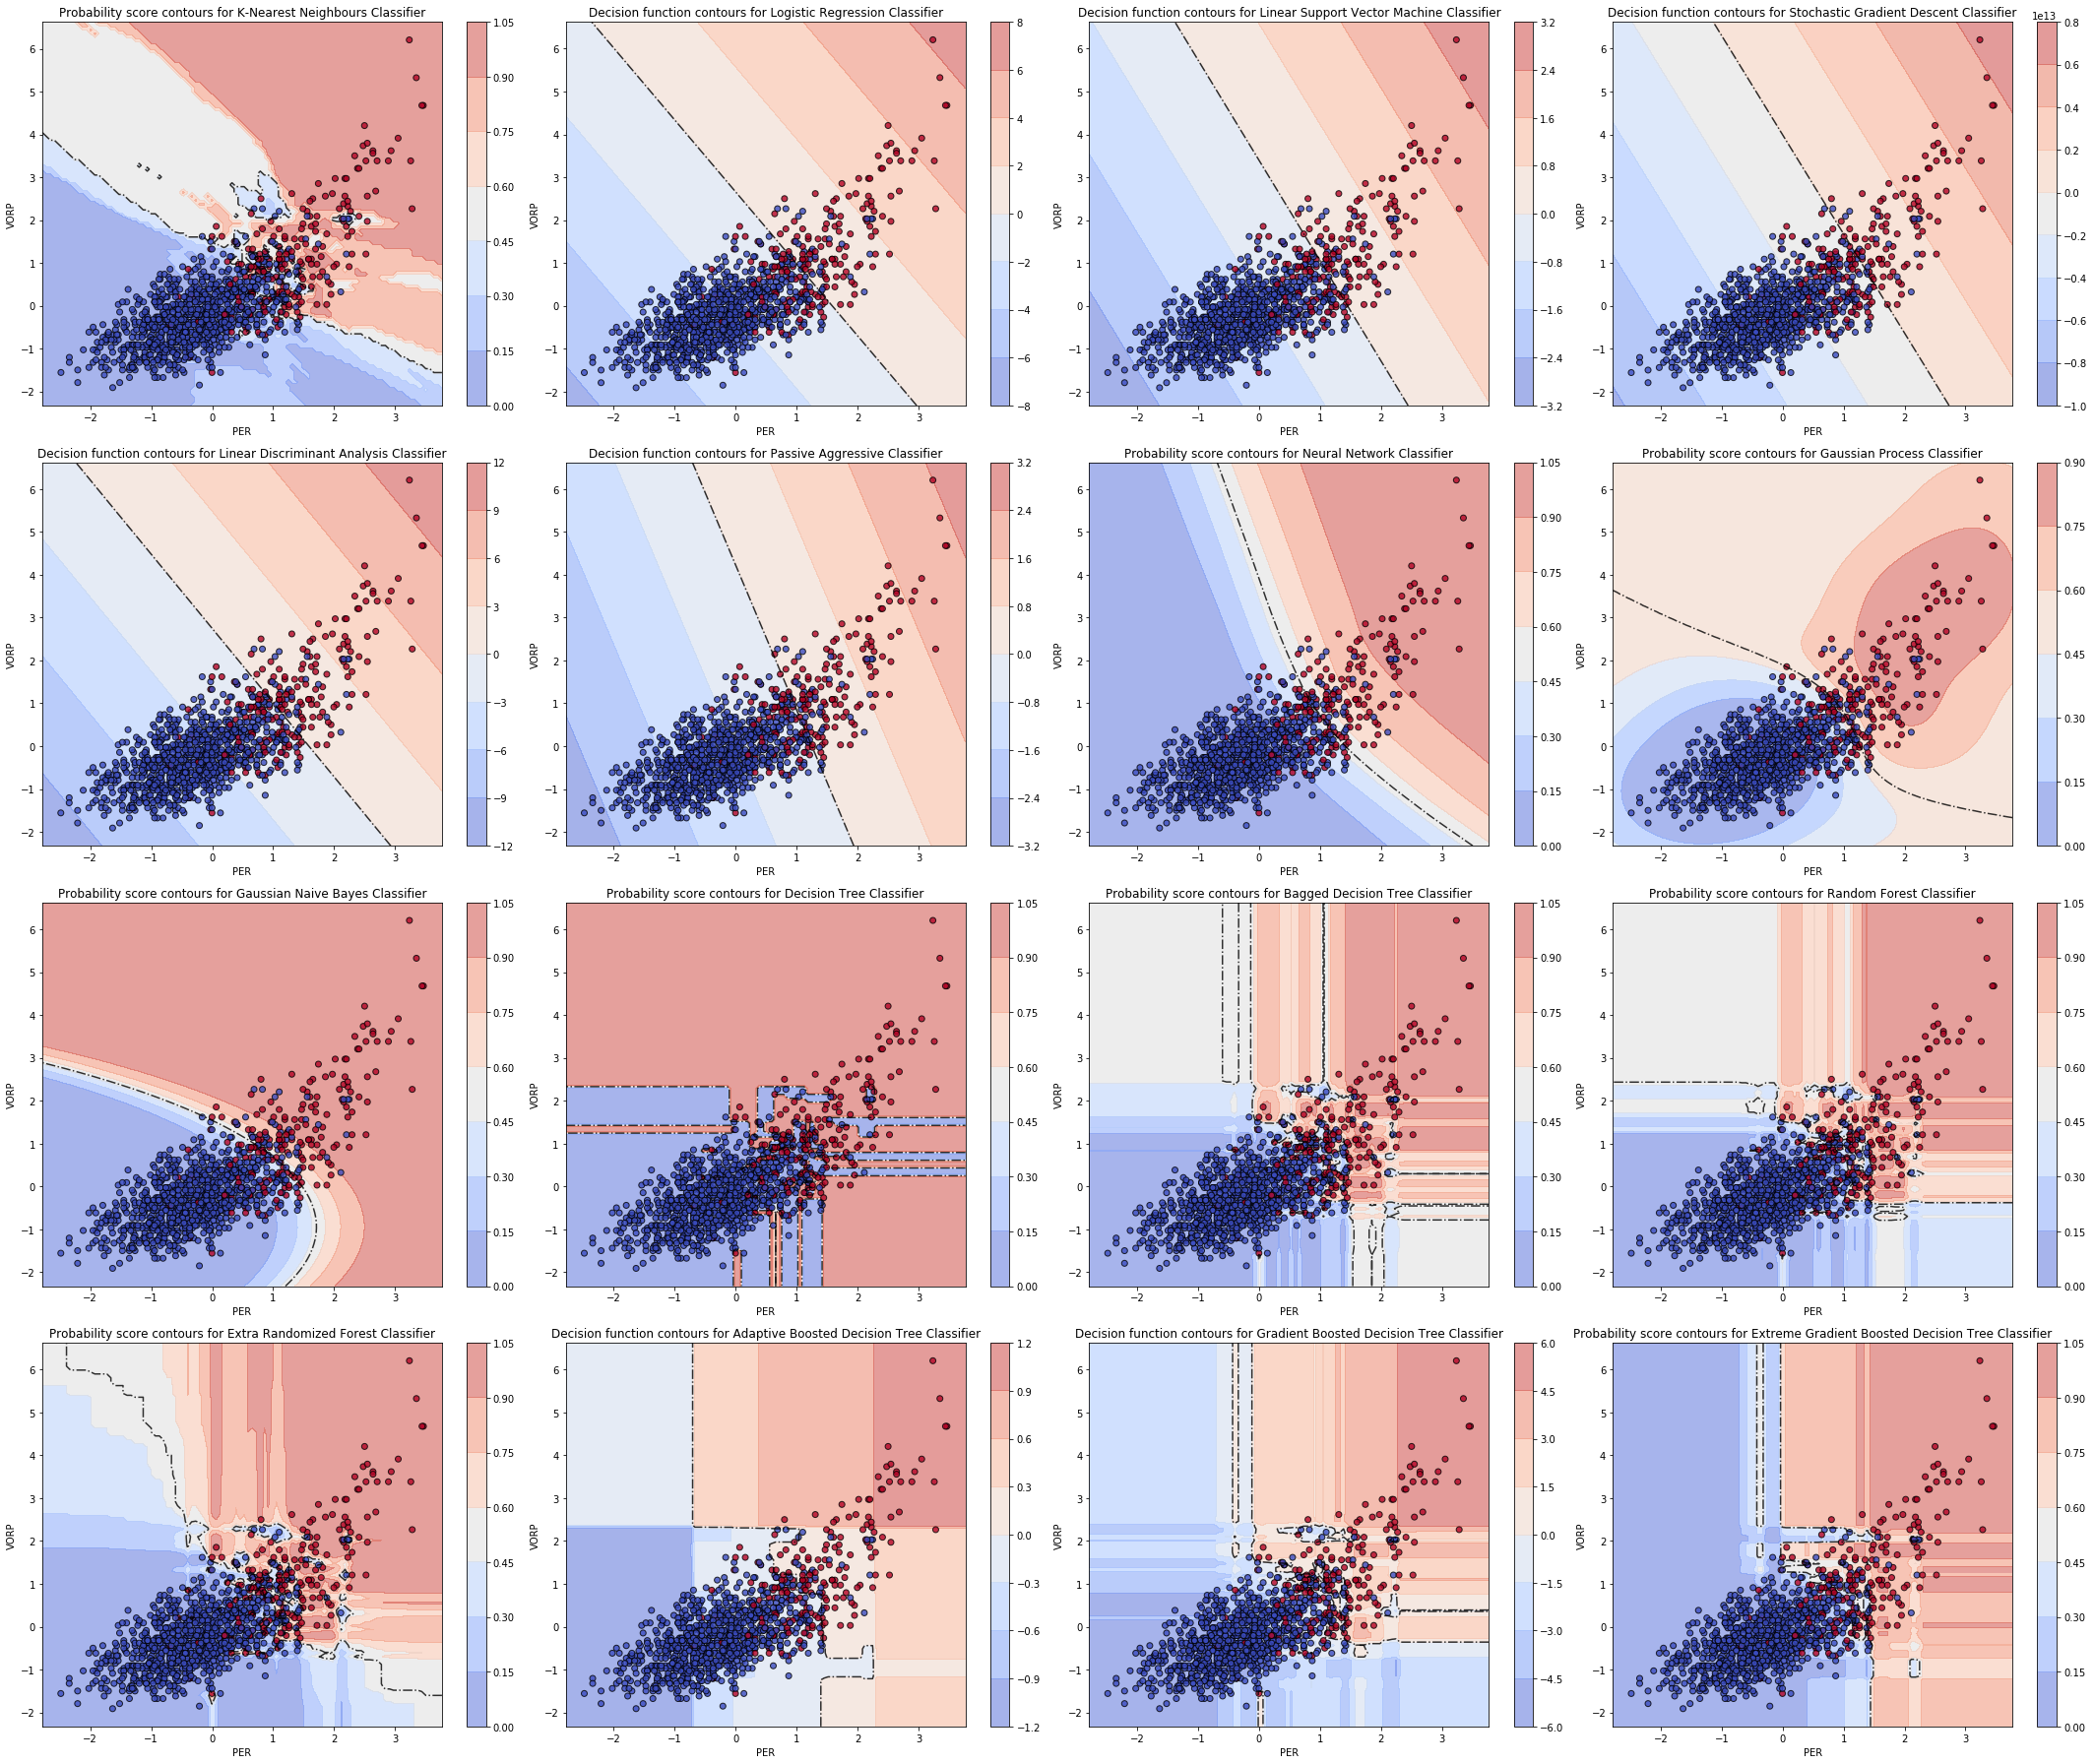

In [33]:
# Create numpy array with original data features and PCA variables:

X_train_all = np.c_[X_train, X_train_PCA[:, 0], X_train_PCA[:, 1]]
X_test_all  = np.c_[X_test,  X_test_PCA [:, 0], X_test_PCA [:, 1]]

feature_names_list = list(feature_names)
feature_names_list.append('PCA1')
feature_names_list.append('PCA2')

# Choose two features to explore:

print("Data features: ", end='')
print(*feature_names_list, sep=", ")

if (includeadvancedstats):
    feature_x = 4  # i.e. PER
    feature_y = 15 # i.e. VORP
    #feature_x = 24 # i.e. PCA1
    #feature_y = 25 # i.e. PCA2
else:
    feature_x = 2 # i.e. MP/G
    feature_y = 3 # i.e. PTS/48
    #feature_x = 17 # i.e. PCA1
    #feature_y = 18 # i.e. PCA2

# Create 2-D array of chosen features:

X_train_2D = X_train_all[:, [feature_x, feature_y]]
X_test_2D  = X_test_all [:, [feature_x, feature_y]]

# Loop over all models:

plt.figure(figsize=(30,25))

colormap = plt.cm.coolwarm

for i, model in enumerate(models, 1):

    plt.subplot(4, 4, i)    
    
    # Create a copy of the classifier, and fit using 2-D features array:
        
    classifier = copy.deepcopy(model.estimator)

    classifier.fit(X_train_2D, y_train)

    # Plot data:
    
    plt.scatter(X_train_2D[:, 0], X_train_2D[:, 1], c=y_train, 
                cmap=colormap, edgecolors='k', marker='o', alpha=0.8)
    #plt.scatter(X_test_2D[:, 0], X_test_2D[:, 1], c=y_test, 
    #            cmap=colormap, edgecolors='k', marker='o', alpha=0.8)

    # Create grid to calculate the decision function / probability score of the model:

    ax = plt.gca()
    xlim = ax.get_xlim()
    ylim = ax.get_ylim()
    xx = np.linspace(xlim[0], xlim[1], 100)
    yy = np.linspace(ylim[0], ylim[1], 100)
    YY, XX = np.meshgrid(yy, xx)        # create 2D grid of evaluation points
    seq = np.c_[XX.ravel(), YY.ravel()] # convert 2D grid into sequence of points
    if hasattr(classifier, "decision_function"):
        Z = classifier.decision_function(seq)
        title = "Decision function contours for {}".format(model.estimator_name)
        boundary = 0
    else:
        Z = classifier.predict_proba(seq)[:, 1]
        title = "Probability score contours for {}".format(model.estimator_name)
        boundary = 0.5
    Z = Z.reshape(XX.shape) # convert Z back into shape of 2D grid of evaluation points
    
    # Plot decision function contours and boundary:

    cf = plt.contourf(XX, YY, Z, cmap=colormap, alpha=.5, zorder=0)
    plt.colorbar(cf)
    plt.contour(XX, YY, Z, colors='black', levels=[boundary], alpha=0.8, linestyles=['-.'])

    plt.title(title)
    plt.xlabel(feature_names_list[feature_x])
    plt.ylabel(feature_names_list[feature_y])
    plt.tight_layout()
    
#print("")
print("--> Probability score / Decision function contours in {}-{} space for all models:".format(
    feature_names_list[feature_x], feature_names_list[feature_y]))

Check which players are All-Stars according to each fitted model:

In [34]:
for model in models:

    y_prediction = model.y_prediction
    
    print("==> Checking which players are All-Stars in {} according to {} ...".format(test_year, 
                                                                                      model.estimator_name))
    print("")

    if test_year_truth_is_known:

        y_truth = model.y_truth

        TN_players = []
        FP_players = []
        FN_players = []
        TP_players = []
    
        for i in range(n_players_test):
    
            player_name = df_test.iat[i,0] # 0-th column in df is player name
    
            if ((y_truth[i] == 0) and (y_prediction[i] == 0)):   # TN
                TN_players.append(player_name)
            elif ((y_truth[i] == 0) and (y_prediction[i] == 1)): # FP
                FP_players.append(player_name)
            elif ((y_truth[i] == 1) and (y_prediction[i] == 0)): # FN
                FN_players.append(player_name)
            else:                                                # TP
                TP_players.append(player_name)
        
        print("--> # of     All-Stars predicted to be     All-Stars = {:>3} (TP)".format(len(TP_players)))
        print("--> # of     All-Stars predicted to be non-All-Stars = {:>3} (FN)".format(len(FN_players)))
        print("--> # of non-All-Stars predicted to be     All-Stars = {:>3} (FP)".format(len(FP_players)))
        print("--> # of non-All-Stars predicted to be non-All-Stars = {:>3} (TN)".format(len(TN_players)))
        print("")
        print("--> Deserved All-Stars     : ", end='')
        print(*TP_players, sep=', ')
        print("")
        print("--> Questionable All-Stars : ", end='')
        print(*FN_players, sep=', ')
        print("")
        print("--> Snubbed non-All-Stars  : ", end='')
        print(*FP_players, sep=', ')
        print("")
    
    else:
        
        Predicted_All_Stars = []
    
        for i in range(n_players_test):    
            player_name = df_test.iat[i,0] # 0-th column in df is player name
            if (y_prediction[i] == 1):
                Predicted_All_Stars.append(player_name)
                
        print("--> Predicted All-Stars : ", end='')
        print(*Predicted_All_Stars, sep=', ')
        print("")

==> Checking which players are All-Stars in 2018 according to K-Nearest Neighbours Classifier ...

--> # of     All-Stars predicted to be     All-Stars =  20 (TP)
--> # of     All-Stars predicted to be non-All-Stars =   8 (FN)
--> # of non-All-Stars predicted to be     All-Stars =   5 (FP)
--> # of non-All-Stars predicted to be non-All-Stars = 108 (TN)

--> Deserved All-Stars     : LaMarcus Aldridge, Giannis Antetokounmpo, Jimmy Butler, DeMarcus Cousins, Stephen Curry, Anthony Davis, DeMar DeRozan, Andre Drummond, Kevin Durant, Joel Embiid, James Harden, Al Horford, Kyrie Irving, LeBron James, Damian Lillard, Kevin Love, Kyle Lowry, Victor Oladipo, Klay Thompson, Russell Westbrook

--> Questionable All-Stars : Bradley Beal, Goran Dragic, Paul George, Draymond Green, Kristaps Porzingis, Karl-Anthony Towns, Kemba Walker, John Wall

--> Snubbed non-All-Stars  : Pau Gasol, Blake Griffin, Nikola Jokic, Chris Paul, Ben Simmons

==> Checking which players are All-Stars in 2018 according to Lo

## Ensemble model

Create an ensemble model of all non-rejected ML classifiers using *VotingClassifier* class with majority voting:

In [35]:
print("--> Classifiers included in the ensemble model:")
print("")

classification_algs = []

for imodel, model in enumerate(models, 0):
    if imodel in rejected_models:
        continue
    print("-----> {:2} : {}".format(imodel, model.estimator_name))
    clf_tuple = (model.estimator_name, model.estimator)
    classification_algs.append(clf_tuple)
    
ensemble = VotingClassifier(estimators=classification_algs, voting='hard')

--> Classifiers included in the ensemble model:

----->  0 : K-Nearest Neighbours Classifier
----->  1 : Logistic Regression Classifier
----->  2 : Linear Support Vector Machine Classifier
----->  3 : Stochastic Gradient Descent Classifier
----->  4 : Linear Discriminant Analysis Classifier
----->  5 : Passive Aggressive Classifier
----->  6 : Neural Network Classifier
----->  7 : Gaussian Process Classifier
----->  8 : Gaussian Naive Bayes Classifier
-----> 10 : Bagged Decision Tree Classifier
-----> 11 : Random Forest Classifier
-----> 12 : Extra Randomized Forest Classifier
-----> 13 : Adaptive Boosted Decision Tree Classifier
-----> 14 : Gradient Boosted Decision Tree Classifier
-----> 15 : Extreme Gradient Boosted Decision Tree Classifier


Cross-validate ensemble model:

In [36]:
note1 = " (Answers the question: How many predicted All-Stars are true All-Stars?)"
note2 = " (Answers the question: How many true All-Stars have been predicted?)"
note3 = " (i.e. the harmonic mean of Precision and Recall)"
note4 = " (Answers the question: How many AS and non-AS have been correctly predicted?)"

cv_logo = logo.split(X_train, y_train, groups=cv_groups)

scoring_list = ['precision', 'recall', 'f1', 'accuracy']

rts = False

scores = cross_validate(ensemble, X_train, y_train, cv=cv_logo, scoring=scoring_list, return_train_score=rts) #, n_jobs=-1)

print("--> Total fit   time = {:5.1f} secs".format(scores['fit_time'  ].sum()))
print("--> Total score time = {:5.1f} secs".format(scores['score_time'].sum()))
print("")    
print("--> Cross-val years  :", ["{:6d}".format(yr) for yr in train_years])
print("")
print("--> Precision scores :", ["{:6.1%}".format(i) for i in scores['test_precision']])
print("--> Recall    scores :", ["{:6.1%}".format(i) for i in scores['test_recall'   ]])
print("--> F1        scores :", ["{:6.1%}".format(i) for i in scores['test_f1'       ]])
print("--> Accuracy  scores :", ["{:6.1%}".format(i) for i in scores['test_accuracy' ]])
print("")
print("--> Precision score : {:5.1%} +/- {:5.1%}".format(np.mean(scores['test_precision']), 
                                                         np.std (scores['test_precision'])) + note1)
print("--> Recall    score : {:5.1%} +/- {:5.1%}".format(np.mean(scores['test_recall'   ]), 
                                                         np.std (scores['test_recall'   ])) + note2)
print("--> F1 score        : {:5.1%} +/- {:5.1%}".format(np.mean(scores['test_f1'       ]), 
                                                         np.std (scores['test_f1'       ])) + note3)
print("--> Accuracy score  : {:5.1%} +/- {:5.1%}".format(np.mean(scores['test_accuracy' ]), 
                                                         np.std (scores['test_accuracy' ])) + note4)

--> Total fit   time =  53.3 secs
--> Total score time =   4.2 secs

--> Cross-val years  : ['  2010', '  2011', '  2012', '  2013', '  2014', '  2015', '  2016', '  2017']

--> Precision scores : [' 85.7%', ' 78.3%', ' 91.7%', ' 68.4%', ' 71.4%', ' 95.2%', ' 86.4%', ' 73.1%']
--> Recall    scores : [' 66.7%', ' 75.0%', ' 45.8%', ' 54.2%', ' 62.5%', ' 80.0%', ' 73.1%', ' 76.0%']
--> F1        scores : [' 75.0%', ' 76.6%', ' 61.1%', ' 60.5%', ' 66.7%', ' 87.0%', ' 79.2%', ' 74.5%']
--> Accuracy  scores : [' 91.5%', ' 92.3%', ' 88.1%', ' 88.1%', ' 89.5%', ' 95.5%', ' 93.0%', ' 90.6%']

--> Precision score : 81.3% +/-  9.3% (Answers the question: How many predicted All-Stars are true All-Stars?)
--> Recall    score : 66.7% +/- 11.1% (Answers the question: How many true All-Stars have been predicted?)
--> F1 score        : 72.6% +/-  8.6% (i.e. the harmonic mean of Precision and Recall)
--> Accuracy score  : 91.1% +/-  2.4% (Answers the question: How many AS and non-AS have been correctly 

Fit ensemble model to training data and check which players are All-Stars according to the ensemble model:

In [37]:
ensemble.fit(X_train, y_train)          # Fit ensemble to training data

y_prediction = ensemble.predict(X_test) # Use fitted ensemble to predict test data

if test_year_truth_is_known:

    y_truth = y_test.tolist()

    TN_players = []
    FP_players = []
    FN_players = []
    TP_players = []
    
    for i in range(n_players_test):
    
        player_name = df_test.iat[i, 0] # 0-th column in df is player name
    
        if ((y_truth[i] == 0)   and (y_prediction[i] == 0)): # TN
            TN_players.append(player_name)
        elif ((y_truth[i] == 0) and (y_prediction[i] == 1)): # FP
            FP_players.append(player_name)
        elif ((y_truth[i] == 1) and (y_prediction[i] == 0)): # FN
            FN_players.append(player_name)
        else:                                                # TP
            TP_players.append(player_name)
        
    print("--> # of     All-Stars predicted to be     All-Stars = {:>3} (TP)".format(len(TP_players)))
    print("--> # of     All-Stars predicted to be non-All-Stars = {:>3} (FN)".format(len(FN_players)))
    print("--> # of non-All-Stars predicted to be     All-Stars = {:>3} (FP)".format(len(FP_players)))
    print("--> # of non-All-Stars predicted to be non-All-Stars = {:>3} (TN)".format(len(TN_players)))
    print("")
    print("--> Deserved All-Stars     : ", end='')
    print(*TP_players, sep=', ')
    print("")
    print("--> Questionable All-Stars : ", end='')
    print(*FN_players, sep=', ')
    print("")
    print("--> Snubbed non-All-Stars  : ", end='')
    print(*FP_players, sep=', ')

else:
        
    Predicted_All_Stars = []
    
    for i in range(n_players_test):    
        player_name = df_test.iat[i,0] # 0-th column in df is player name
        if (y_prediction[i] == 1):
            Predicted_All_Stars.append(player_name)
                
    print("--> Predicted All-Stars : ", end='')
    print(*Predicted_All_Stars, sep=', ')

--> # of     All-Stars predicted to be     All-Stars =  18 (TP)
--> # of     All-Stars predicted to be non-All-Stars =  10 (FN)
--> # of non-All-Stars predicted to be     All-Stars =   4 (FP)
--> # of non-All-Stars predicted to be non-All-Stars = 109 (TN)

--> Deserved All-Stars     : LaMarcus Aldridge, Giannis Antetokounmpo, Jimmy Butler, DeMarcus Cousins, Stephen Curry, Anthony Davis, DeMar DeRozan, Andre Drummond, Kevin Durant, Joel Embiid, James Harden, Kyrie Irving, LeBron James, Damian Lillard, Kyle Lowry, Victor Oladipo, Karl-Anthony Towns, Russell Westbrook

--> Questionable All-Stars : Bradley Beal, Goran Dragic, Paul George, Draymond Green, Al Horford, Kevin Love, Kristaps Porzingis, Klay Thompson, Kemba Walker, John Wall

--> Snubbed non-All-Stars  : Blake Griffin, Nikola Jokic, Chris Paul, Ben Simmons


Create helper dictionaries:

In [38]:
AS_index = 51 if includeadvancedstats else 31 # AS index in df_test

player_index_dict = {}
player_AS_dict    = {}
for i in range(n_players_test):
    player_name = df_test.iat[i, 0]
    player_index_dict[player_name] = i
    if df_test.iat[i, AS_index] == 1:
        player_AS_dict[player_name] = 'YES'
    else: # df_test.iat[i, AS_index] == 0:
        if test_year_truth_is_known:
            player_AS_dict[player_name] = 'NO'
        else:
            player_AS_dict[player_name] = 'N.A.'

Check classification results per classifier in the ensemble model:

In [39]:
y_classification = ensemble.transform(X_test) # Class labels predicted per classifier in ensemble

player_scores_dict    = {}
player_sumscores_dict = {}
        
for i in range(n_players_test):
    
    classification_list = y_classification[i]
    classification_sum  = np.sum(classification_list)
    player_name = df_test.iat[i, 0]
    player_scores_dict   [player_name] = classification_list
    player_sumscores_dict[player_name] = classification_sum

sorted_player_sumscores_dict = sorted(player_sumscores_dict.items(), key=operator.itemgetter(1), reverse=True)

print_limit = 50

print("--> Top-{} players with highest voting sum of all ML classifiers in {}:".format(print_limit, test_year))
print("")

printed_line = False
for i, (key, value) in enumerate(dict(sorted_player_sumscores_dict[:print_limit]).items(), 1):
    if (value <= ((len(models)-len(rejected_models))/2) and not printed_line):
        print("***************************************************************************************")
        printed_line = True
    if (value == 0):
        continue
    print("--> {:3}: {:24} = {:2d} {} (All-Star: {})".format(
        i, key, value, player_scores_dict[key], player_AS_dict[key]))

--> Top-50 players with highest voting sum of all ML classifiers in 2018:

-->   1: Giannis Antetokounmpo    = 15 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1] (All-Star: YES)
-->   2: Jimmy Butler             = 15 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1] (All-Star: YES)
-->   3: Anthony Davis            = 15 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1] (All-Star: YES)
-->   4: Kevin Durant             = 15 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1] (All-Star: YES)
-->   5: Joel Embiid              = 15 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1] (All-Star: YES)
-->   6: James Harden             = 15 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1] (All-Star: YES)
-->   7: Kyrie Irving             = 15 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1] (All-Star: YES)
-->   8: Damian Lillard           = 15 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1] (All-Star: YES)
-->   9: LaMarcus Aldridge        = 14 [1 1 1 0 1 1 1 1 1 1 1 1 1 1 1] (All-Star: YES)
-->  10: DeMarcus Cousins         = 14 [1 1 1 1 0 1 1 1 1 1 1 1 1 1 1] (All-Star: YES)
-->  11: Stephen Curry            = 14 [1 1 1 1 0 1 1 1

## Probability scores and final prediction

Calculate classification probability scores of test data for all models, and add scores and corresponding ranks to *df_test*:

In [40]:
print_limit = 50
    
for model in models:
        
    classifier = model.estimator
    
    # Calculate and save probability scores:
    
    if hasattr(classifier, "predict_proba"):
        prob_method = "predict_proba"
        y_score = classifier.predict_proba(X_test)[:, 1]
    else:
        prob_method = "decision_function"
        y_score = classifier.decision_function(X_test)
        value_threshold = - y_score.min() / (y_score.max() - y_score.min())
        y_score = (y_score - y_score.min()) / (y_score.max() - y_score.min())
    
    model_acronym = ''.join(c for c in model.estimator_name if c.isupper())
    column_name_score = '{} score'.format(model_acronym)
    df_test[column_name_score] = y_score
    
    model.set_y_score(y_score)
    
    # Calculate and save corresponding scoring ranks:
    
    player_score_dict = {}    
    for i in range(n_players_test):
        if hasattr(classifier, "predict_proba"):
            player_score_dict[df_test.iat[i,0]] = y_score[i]
        else:
            player_score_dict[df_test.iat[i,0]] = y_score[i]
        
    sorted_player_score_dict = sorted(player_score_dict.items(), key=operator.itemgetter(1), reverse=True)
    
    column_name_rank = '{} rank'.format(model_acronym)
    df_rank = pd.DataFrame(columns=['Player', column_name_rank], index=range(0, n_players_test))

    print("==> {} scores for top-{} players in {} ({}):".format(
    model.estimator_name, print_limit, test_year, prob_method))
    print("")

    printed_line = False
    
    previous_rank  = 0
    previous_score = 1e10
    rank_increment = 0
    
    for i, (key, value) in enumerate(dict(sorted_player_score_dict).items(), 1):
        
        if (value < previous_score):
            rank = previous_rank + 1 + rank_increment
            rank_increment = 0
        else:
            rank = previous_rank
            rank_increment += 1
        previous_rank  = rank
        previous_score = value
        
        df_rank.loc[player_index_dict[key], 'Player'        ] = key
        df_rank.loc[player_index_dict[key], column_name_rank] = rank
        
        if (i <= print_limit):
            if hasattr(classifier, "predict_proba"):
                if (value < 0.5 and not printed_line):
                    print("*************************************************************")
                    printed_line = True
            else:
                if (value < value_threshold and not printed_line):
                    print("*************************************************************")
                    printed_line = True
            print("----> {:3}: {:24} = {:6.3f} (All-Star: {})".format(rank, key, value, player_AS_dict[key]))
            
    df_test = pd.merge(df_test, df_rank, how='right', left_on=['Player'], right_on=['Player'])    
    print("")

==> K-Nearest Neighbours Classifier scores for top-50 players in 2018 (predict_proba):

---->   1: LaMarcus Aldridge        =  1.000 (All-Star: YES)
---->   1: Giannis Antetokounmpo    =  1.000 (All-Star: YES)
---->   1: Anthony Davis            =  1.000 (All-Star: YES)
---->   1: Kevin Durant             =  1.000 (All-Star: YES)
---->   1: James Harden             =  1.000 (All-Star: YES)
---->   1: LeBron James             =  1.000 (All-Star: YES)
---->   1: Victor Oladipo           =  1.000 (All-Star: YES)
---->   1: Russell Westbrook        =  1.000 (All-Star: YES)
---->   9: Jimmy Butler             =  0.800 (All-Star: YES)
---->   9: DeMar DeRozan            =  0.800 (All-Star: YES)
---->   9: Andre Drummond           =  0.800 (All-Star: YES)
---->   9: Blake Griffin            =  0.800 (All-Star: NO)
---->   9: Al Horford               =  0.800 (All-Star: YES)
---->   9: Kyrie Irving             =  0.800 (All-Star: YES)
---->   9: Nikola Jokic             =  0.800 (All-Star: NO)

---->  15: Hassan Whiteside         =  0.821 (All-Star: NO)
---->  16: Clint Capela             =  0.813 (All-Star: NO)
*************************************************************
---->  17: LaMarcus Aldridge        =  0.793 (All-Star: YES)
---->  18: DeMar DeRozan            =  0.791 (All-Star: YES)
---->  19: Klay Thompson            =  0.785 (All-Star: YES)
---->  20: Kevin Love               =  0.785 (All-Star: YES)
---->  21: Blake Griffin            =  0.744 (All-Star: NO)
---->  22: LeBron James             =  0.743 (All-Star: YES)
---->  23: Devin Booker             =  0.733 (All-Star: NO)
---->  24: Karl-Anthony Towns       =  0.733 (All-Star: YES)
---->  25: Victor Oladipo           =  0.731 (All-Star: YES)
---->  26: Paul George              =  0.721 (All-Star: YES)
---->  27: J.J. Redick              =  0.712 (All-Star: NO)
---->  28: Reggie Jackson           =  0.712 (All-Star: NO)
---->  29: Gary Harris              =  0.711 (All-Star: NO)
---->  30: Khris Middleton    

---->  39: Kevin Love               =  0.145 (All-Star: YES)
---->  40: Jrue Holiday             =  0.133 (All-Star: NO)
---->  41: Kemba Walker             =  0.115 (All-Star: YES)
---->  42: Donovan Mitchell         =  0.091 (All-Star: NO)
---->  43: Steven Adams             =  0.088 (All-Star: NO)
---->  44: Eric Bledsoe             =  0.080 (All-Star: NO)
---->  45: Tobias Harris            =  0.080 (All-Star: NO)
---->  46: Harrison Barnes          =  0.077 (All-Star: NO)
---->  47: Serge Ibaka              =  0.070 (All-Star: NO)
---->  48: Khris Middleton          =  0.062 (All-Star: NO)
---->  49: Dario Saric              =  0.053 (All-Star: NO)
---->  50: Marc Gasol               =  0.047 (All-Star: NO)

==> Gaussian Process Classifier scores for top-50 players in 2018 (predict_proba):

---->   1: DeMar DeRozan            =  0.625 (All-Star: YES)
---->   2: LaMarcus Aldridge        =  0.572 (All-Star: YES)
---->   3: LeBron James             =  0.570 (All-Star: YES)
---->   4:


==> Bagged Decision Tree Classifier scores for top-50 players in 2018 (predict_proba):

---->   1: James Harden             =  1.000 (All-Star: YES)
---->   2: Russell Westbrook        =  0.970 (All-Star: YES)
---->   3: Giannis Antetokounmpo    =  0.960 (All-Star: YES)
---->   3: LeBron James             =  0.960 (All-Star: YES)
---->   5: Damian Lillard           =  0.950 (All-Star: YES)
---->   6: Anthony Davis            =  0.940 (All-Star: YES)
---->   7: Victor Oladipo           =  0.910 (All-Star: YES)
---->   8: Kevin Durant             =  0.900 (All-Star: YES)
---->   9: LaMarcus Aldridge        =  0.840 (All-Star: YES)
---->  10: DeMar DeRozan            =  0.830 (All-Star: YES)
---->  11: Jimmy Butler             =  0.820 (All-Star: YES)
---->  12: Kyrie Irving             =  0.720 (All-Star: YES)
---->  13: DeMarcus Cousins         =  0.700 (All-Star: YES)
---->  14: Joel Embiid              =  0.670 (All-Star: YES)
---->  15: Stephen Curry            =  0.620 (All-Star: Y

==> Adaptive Boosted Decision Tree Classifier scores for top-50 players in 2018 (predict_proba):

---->   1: James Harden             =  0.693 (All-Star: YES)
---->   2: Russell Westbrook        =  0.684 (All-Star: YES)
---->   3: LeBron James             =  0.672 (All-Star: YES)
---->   4: Damian Lillard           =  0.650 (All-Star: YES)
---->   5: Anthony Davis            =  0.580 (All-Star: YES)
---->   6: Kevin Durant             =  0.569 (All-Star: YES)
---->   7: Giannis Antetokounmpo    =  0.568 (All-Star: YES)
---->   8: Victor Oladipo           =  0.561 (All-Star: YES)
---->   9: DeMarcus Cousins         =  0.558 (All-Star: YES)
---->  10: Chris Paul               =  0.557 (All-Star: NO)
---->  11: Kyrie Irving             =  0.555 (All-Star: YES)
---->  12: Jimmy Butler             =  0.544 (All-Star: YES)
---->  13: LaMarcus Aldridge        =  0.541 (All-Star: YES)
---->  14: Karl-Anthony Towns       =  0.540 (All-Star: YES)
---->  15: Stephen Curry            =  0.533 (All

Plot predicted score distributions and probability calibration curves for all models, averaged over all cross-validation groups:

--> Predicted score distributions and probability calibration curves for all models on training data:


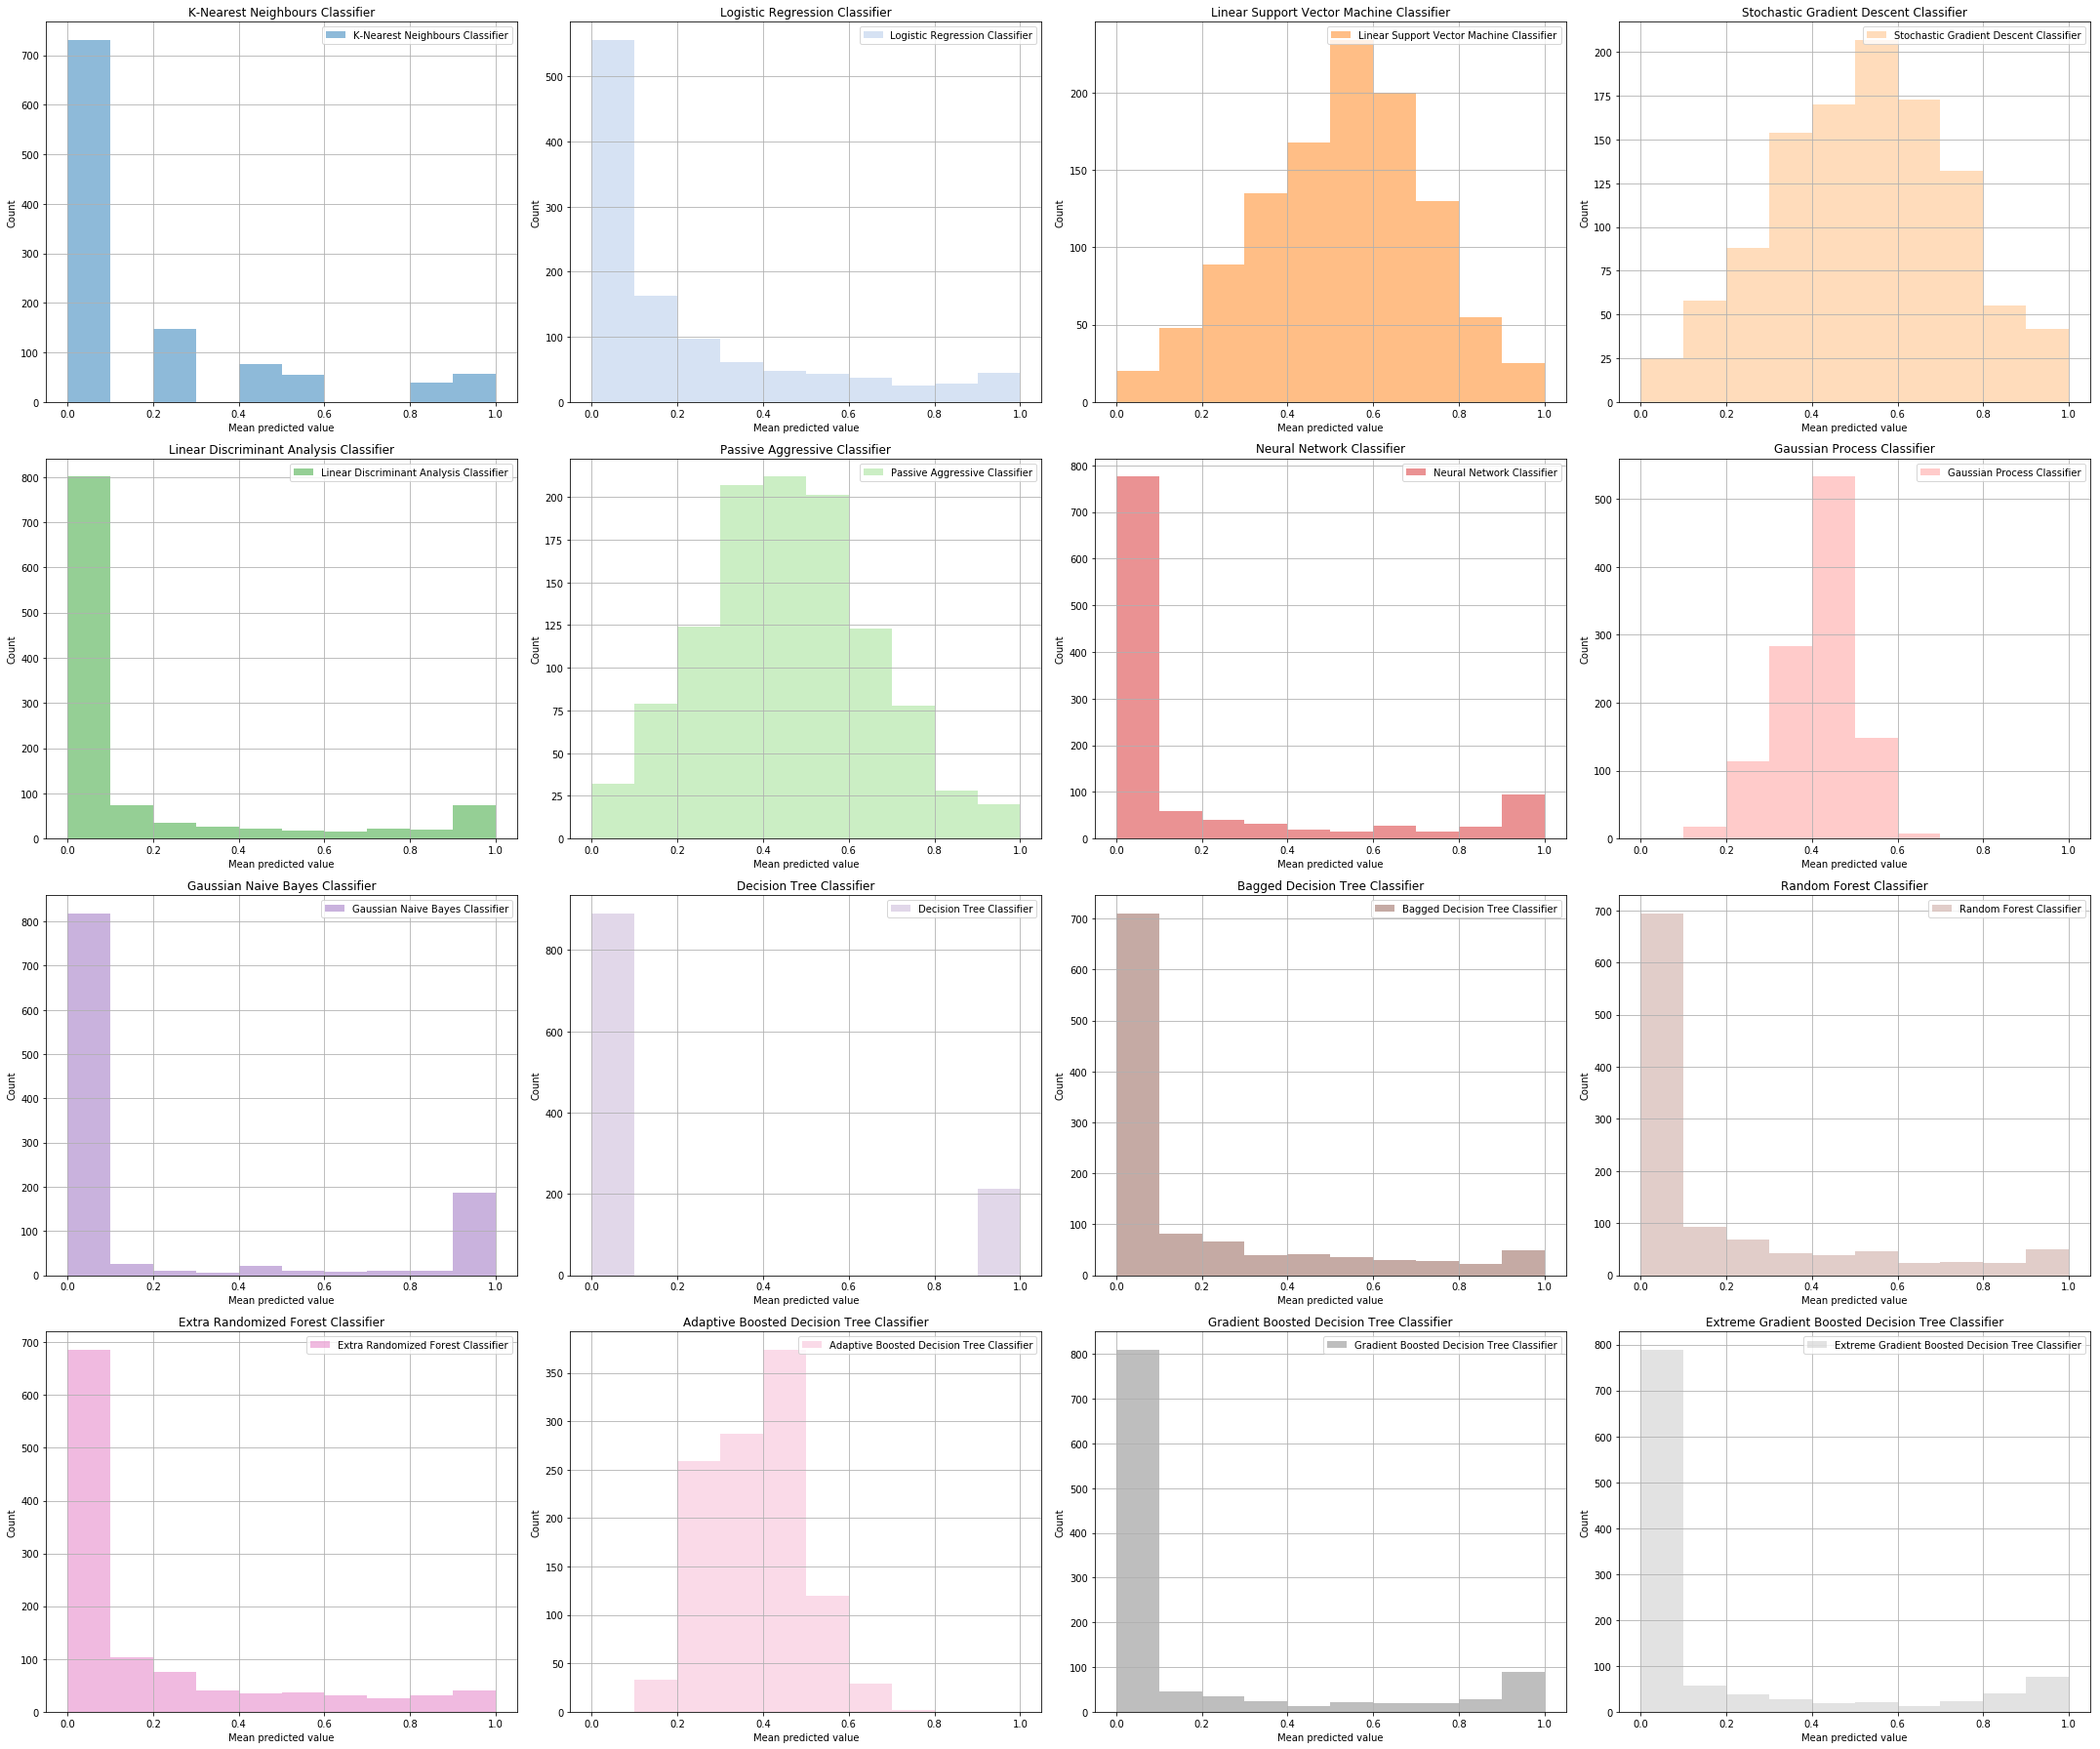

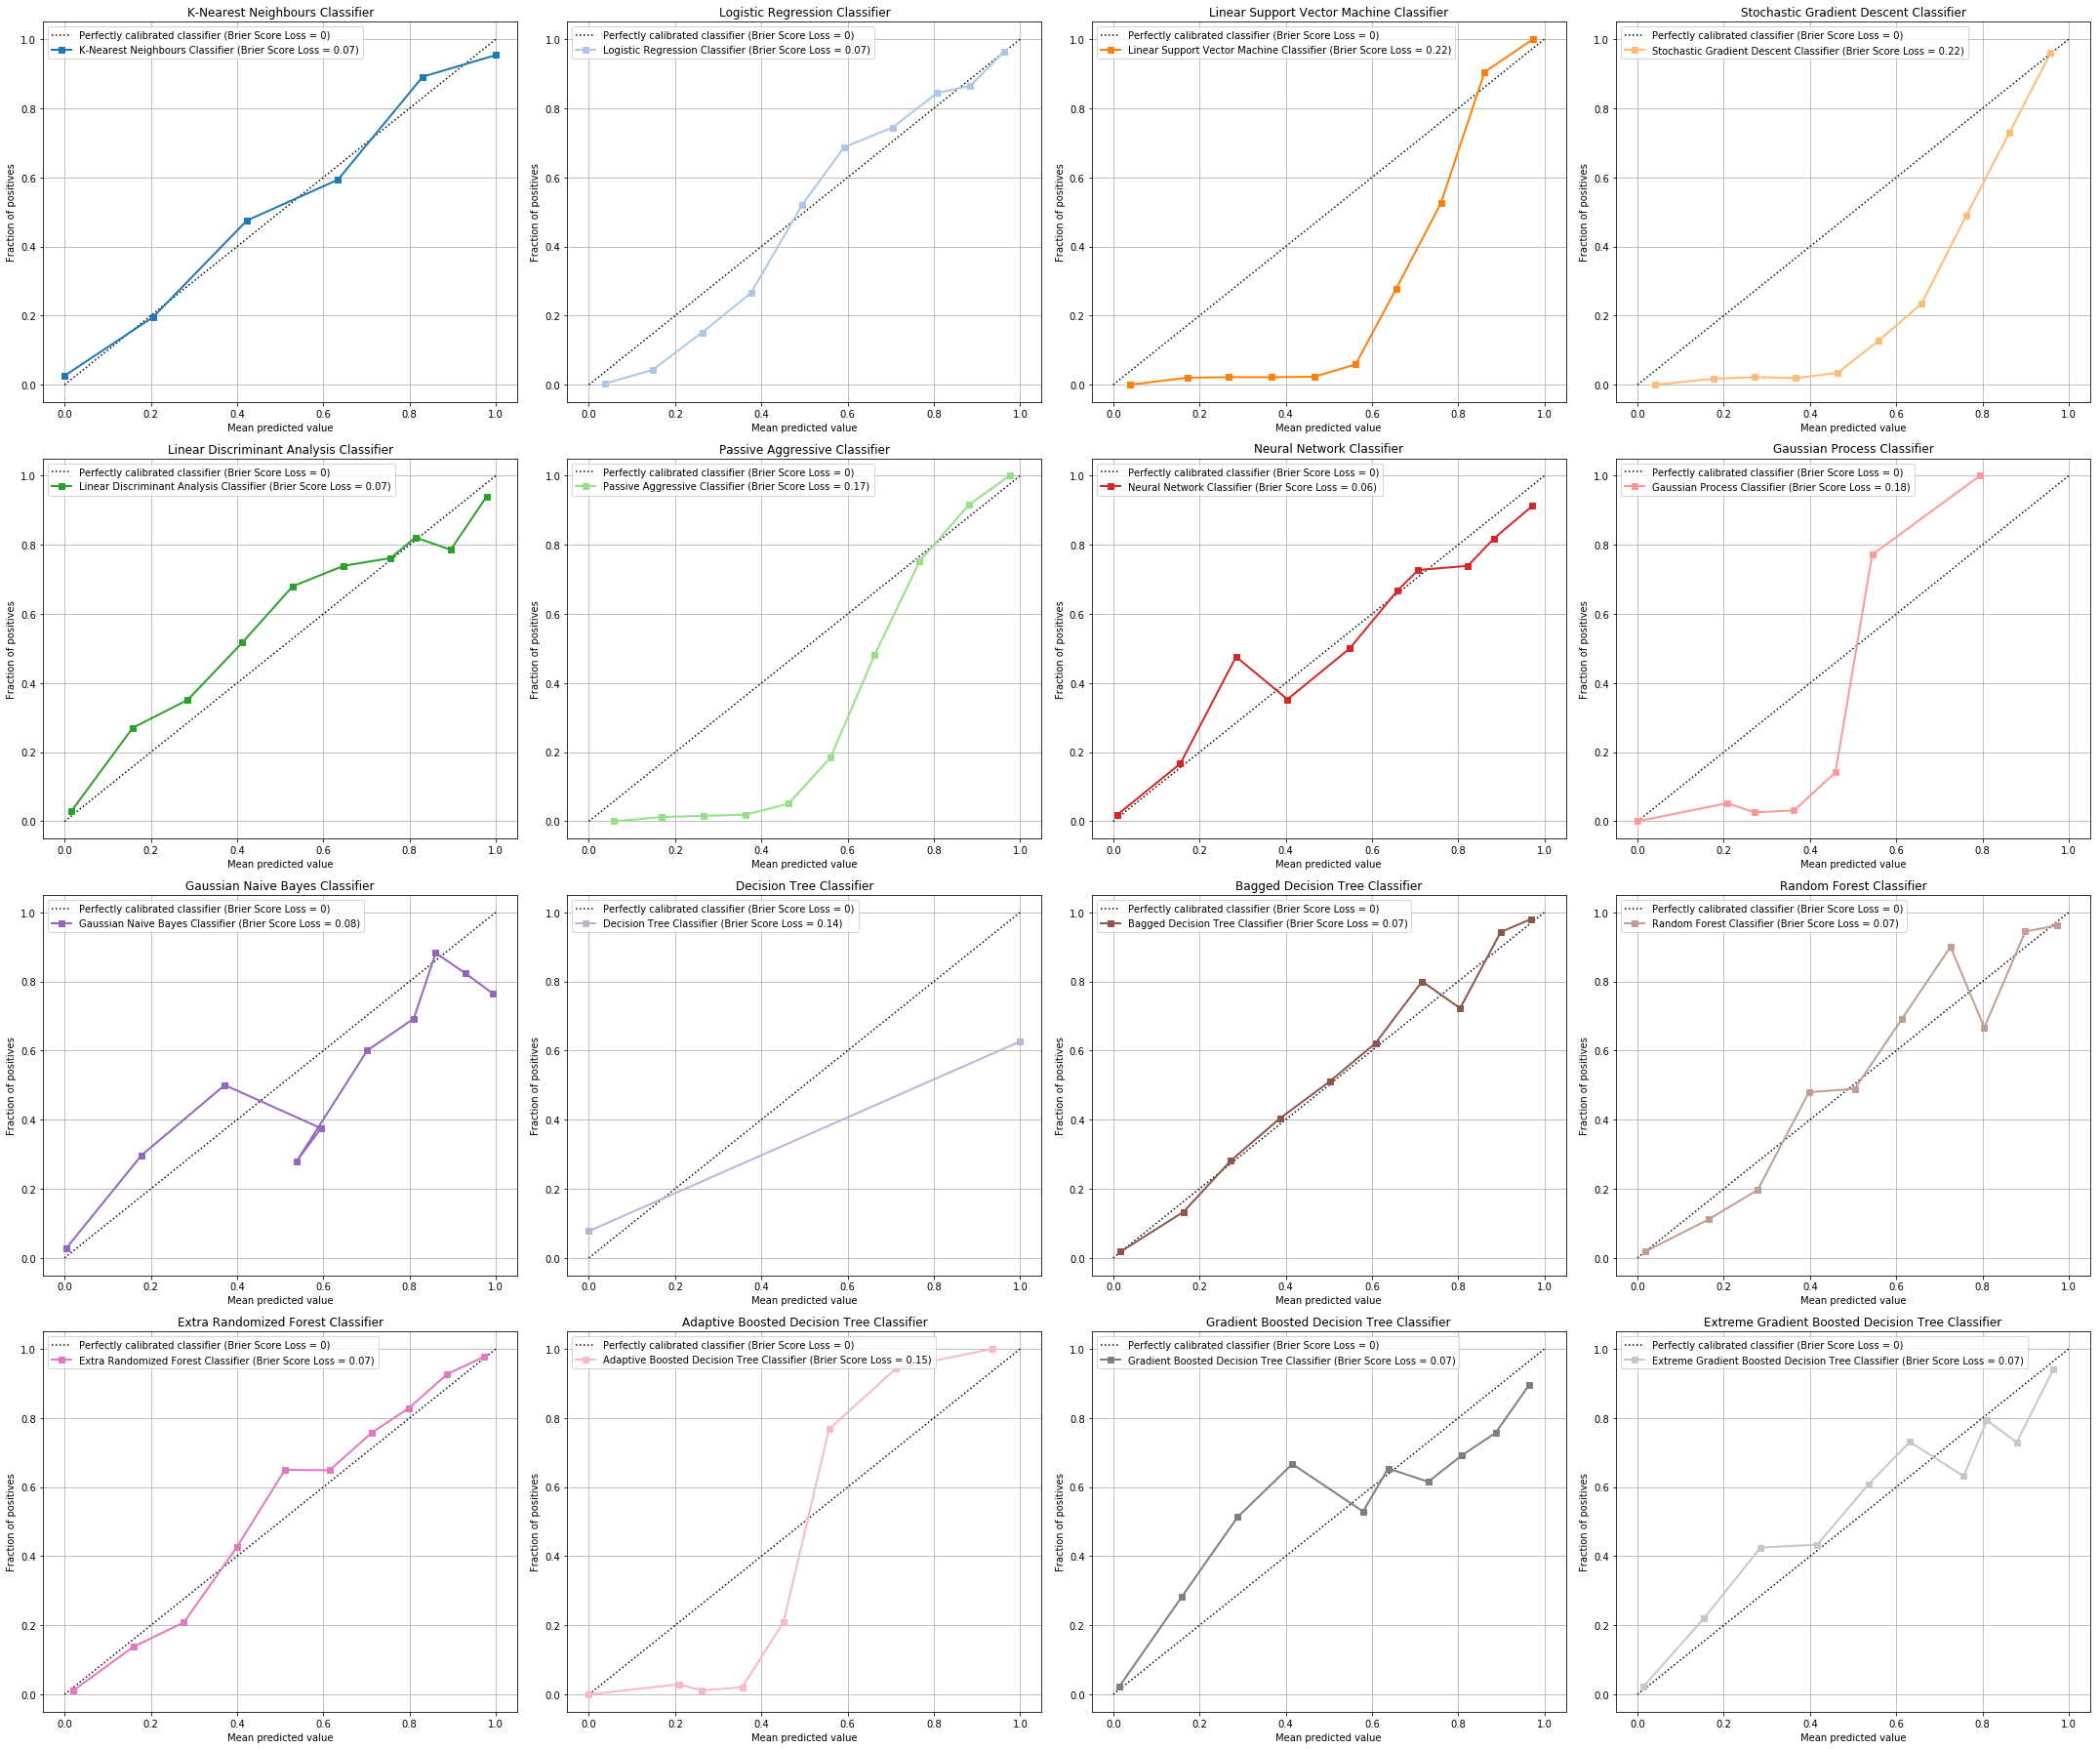

In [41]:
color = iter(plt.cm.tab20(np.linspace(0, 1, 20))) #len(models))))

n_bins = 10

plt.figure(1, figsize=(30, 25))
plt.figure(2, figsize=(30, 25))

for imodel, model in enumerate(models):

    #print("-->", model.estimator_name)
    
    cv_y_test  = model.cv_y_test
    cv_y_score = model.cv_y_score
    
    cv_bin_sums  = range(n_bins + 1)
    cv_bin_true  = range(n_bins + 1)
    cv_bin_total = range(n_bins + 1)
    
    for y_t, y_s in zip(cv_y_test, cv_y_score):
            
        y_true = column_or_1d(y_t)
        y_prob = column_or_1d(y_s)

        bins = np.linspace(0., 1. + 1e-8, n_bins + 1)
        binids = np.digitize(y_prob, bins) - 1

        bin_sums  = np.bincount(binids, weights=y_prob, minlength=len(bins))
        bin_true  = np.bincount(binids, weights=y_true, minlength=len(bins))
        bin_total = np.bincount(binids, minlength=len(bins))

        cv_bin_sums  += bin_sums
        cv_bin_true  += bin_true
        cv_bin_total += bin_total

    fraction_of_positives = []
    mean_predicted_value  = []
        
    for i in range(n_bins+1):
            
        f_o_p = cv_bin_true[i]/cv_bin_total[i] if cv_bin_total[i] != 0 else 0
        m_p_v = cv_bin_sums[i]/cv_bin_total[i] if cv_bin_total[i] != 0 else 0
            
        fraction_of_positives.append(f_o_p)
        mean_predicted_value .append(m_p_v)
        
    cv_y_score_all = []
    cv_y_test_all  = []
    for i in range(len(cv_y_score)):
        for j in range(len(cv_y_score[i])):
            cv_y_score_all.append(cv_y_score[i][j])
            cv_y_test_all .append(cv_y_test [i][j])
    
    brier_score_l = brier_score_loss(cv_y_test_all, cv_y_score_all, pos_label=1)
    
    c=next(color)
    
    plt.figure(1)
    plt.subplot(4, 4, imodel+1)

    plt.hist(cv_y_score_all, range=(0, 1), bins=n_bins, histtype="stepfilled", color=c, lw=2, alpha=0.5, 
             label=model.estimator_name)
    
    plt.title(model.estimator_name)
    plt.xlabel("Mean predicted value")
    plt.ylabel("Count")
    plt.legend(loc="upper right")    
    plt.grid(True)
    plt.tight_layout()
    
    plt.figure(2)
    plt.subplot(4, 4, imodel+1)

    fraction_of_positives = fraction_of_positives[:-1]
    mean_predicted_value  = mean_predicted_value [:-1]
        
    n_problembins = 0
    for i in range(n_bins):
        if ((fraction_of_positives[i] > 0.999) and (mean_predicted_value[i] > 0.999)):
            n_problembins += 1
            fraction_of_positives.insert(0, fraction_of_positives.pop(i))
            mean_predicted_value .insert(0, mean_predicted_value .pop(i))
            
    fraction_of_positives = fraction_of_positives[n_problembins:]
    mean_predicted_value  = mean_predicted_value [n_problembins:]

    plt.plot([0, 1], [0, 1], "k:", label="Perfectly calibrated classifier (Brier Score Loss = 0)")    
    plt.plot(mean_predicted_value, fraction_of_positives, "s-", color=c, lw=2,
             label="{} (Brier Score Loss = {:.2f})".format(model.estimator_name, brier_score_l))

    plt.title(model.estimator_name)
    plt.xlabel("Mean predicted value")
    plt.ylabel("Fraction of positives")
    plt.ylim([-0.05, 1.05])
    plt.legend(loc="upper left")
    plt.grid(True)
    plt.tight_layout()

print("--> Predicted score distributions and probability calibration curves for all models on training data:")

Calculate calibrated classification probability scores of test data for all models, and add calibrated scores and corresponding ranks to *df_test*:

In [42]:
print_limit = 50

for imodel, model in enumerate(models):
    
    clf = model.estimator

    # Calculate and save calibrated probability scores:
    
    cv_logo = logo.split(X_train, y_train, groups=cv_groups)

    clf_calib = CalibratedClassifierCV(clf, cv=cv_logo, method='isotonic') # method='sigmoid'
    clf_calib.fit(X_train, y_train)
    y_score_calib = clf_calib.predict_proba(X_test)[:, 1]

    model_acronym = ''.join(c for c in model.estimator_name if c.isupper())
    column_name_score = '{} calibrated score'.format(model_acronym)
    df_test[column_name_score] = y_score_calib

    model.set_y_score_calib(y_score_calib)
    
    # Calculate and save corresponding calibrated scoring ranks:

    player_score_dict = {}    
    for i in range(n_players_test):
        player_score_dict[df_test.iat[i,0]] = y_score_calib[i]
        
    sorted_player_score_dict = sorted(player_score_dict.items(), key=operator.itemgetter(1), reverse=True)
        
    column_name_rank = '{} calibrated rank'.format(model_acronym)
    df_rank = pd.DataFrame(columns=['Player', column_name_rank], index=range(0, n_players_test))    

    printed_line = False
    
    print("==> {} calibrated scores for top-{} players in {}:".format(
        model.estimator_name, print_limit, test_year))
    print("")
    
    previous_rank  = 0
    previous_score = 1e10
    rank_increment = 0
    
    for i, (key, value) in enumerate(dict(sorted_player_score_dict).items(), 1):
         
        if (value < previous_score):
            rank = previous_rank + 1 + rank_increment
            rank_increment = 0
        else:
            rank = previous_rank
            rank_increment += 1
        previous_rank  = rank
        previous_score = value

        df_rank.loc[player_index_dict[key], 'Player'        ] = key
        df_rank.loc[player_index_dict[key], column_name_rank] = rank        
        
        if (i <= print_limit):
        
            if (value < 0.5 and not printed_line):
                print("*************************************************************")
                printed_line = True
            print("----> {:3}: {:24} = {:6.3f} (All-Star: {})".format(rank, key, value, player_AS_dict[key]))

    df_test = pd.merge(df_test, df_rank, how='right', left_on=['Player'], right_on=['Player'])    
    print("")

==> K-Nearest Neighbours Classifier calibrated scores for top-50 players in 2018:

---->   1: LaMarcus Aldridge        =  0.955 (All-Star: YES)
---->   1: Giannis Antetokounmpo    =  0.955 (All-Star: YES)
---->   1: Anthony Davis            =  0.955 (All-Star: YES)
---->   1: Kevin Durant             =  0.955 (All-Star: YES)
---->   1: James Harden             =  0.955 (All-Star: YES)
---->   1: LeBron James             =  0.955 (All-Star: YES)
---->   1: Victor Oladipo           =  0.955 (All-Star: YES)
---->   1: Russell Westbrook        =  0.955 (All-Star: YES)
---->   9: Andre Drummond           =  0.913 (All-Star: YES)
---->  10: DeMar DeRozan            =  0.888 (All-Star: YES)
---->  10: Kyrie Irving             =  0.888 (All-Star: YES)
---->  10: Nikola Jokic             =  0.888 (All-Star: NO)
---->  13: Jimmy Butler             =  0.857 (All-Star: YES)
---->  14: Ben Simmons              =  0.843 (All-Star: NO)
---->  15: Damian Lillard           =  0.817 (All-Star: YES)
----

---->  38: Jonas Valanciunas        =  0.147 (All-Star: NO)
---->  40: Steven Adams             =  0.132 (All-Star: NO)
---->  40: Jusuf Nurkic             =  0.132 (All-Star: NO)
---->  42: Goran Dragic             =  0.110 (All-Star: YES)
---->  43: Devin Booker             =  0.094 (All-Star: NO)
---->  44: Tobias Harris            =  0.084 (All-Star: NO)
---->  45: Draymond Green           =  0.081 (All-Star: YES)
---->  46: Donovan Mitchell         =  0.075 (All-Star: NO)
---->  47: DeAndre Jordan           =  0.072 (All-Star: NO)
---->  47: Enes Kanter              =  0.072 (All-Star: NO)
---->  49: Jeff Teague              =  0.045 (All-Star: NO)
---->  50: J.J. Redick              =  0.036 (All-Star: NO)

==> Stochastic Gradient Descent Classifier calibrated scores for top-50 players in 2018:

---->   1: DeMarcus Cousins         =  1.000 (All-Star: YES)
---->   1: Anthony Davis            =  1.000 (All-Star: YES)
---->   1: James Harden             =  1.000 (All-Star: YES)
----


==> Neural Network Classifier calibrated scores for top-50 players in 2018:

---->   1: Giannis Antetokounmpo    =  1.000 (All-Star: YES)
---->   1: Anthony Davis            =  1.000 (All-Star: YES)
---->   1: Kevin Durant             =  1.000 (All-Star: YES)
---->   1: James Harden             =  1.000 (All-Star: YES)
---->   1: LeBron James             =  1.000 (All-Star: YES)
---->   1: Russell Westbrook        =  1.000 (All-Star: YES)
---->   7: Damian Lillard           =  0.991 (All-Star: YES)
---->   8: Kyrie Irving             =  0.979 (All-Star: YES)
---->   9: LaMarcus Aldridge        =  0.961 (All-Star: YES)
---->  10: Stephen Curry            =  0.931 (All-Star: YES)
---->  11: DeMar DeRozan            =  0.921 (All-Star: YES)
---->  12: Ben Simmons              =  0.869 (All-Star: NO)
---->  13: Victor Oladipo           =  0.866 (All-Star: YES)
---->  14: DeMarcus Cousins         =  0.842 (All-Star: YES)
---->  15: Joel Embiid              =  0.809 (All-Star: YES)
---->  1

==> Decision Tree Classifier calibrated scores for top-50 players in 2018:

---->   1: James Harden             =  0.622 (All-Star: YES)
---->   1: Damian Lillard           =  0.622 (All-Star: YES)
---->   1: Victor Oladipo           =  0.622 (All-Star: YES)
---->   1: Russell Westbrook        =  0.622 (All-Star: YES)
---->   5: Kevin Durant             =  0.565 (All-Star: YES)
---->   5: C.J. McCollum            =  0.565 (All-Star: NO)
---->   7: DeMar DeRozan            =  0.557 (All-Star: YES)
---->   8: Anthony Davis            =  0.550 (All-Star: YES)
---->   9: LeBron James             =  0.548 (All-Star: YES)
---->  10: Jimmy Butler             =  0.506 (All-Star: YES)
*************************************************************
---->  11: Stephen Curry            =  0.498 (All-Star: YES)
---->  12: Dennis Schroder          =  0.491 (All-Star: NO)
---->  13: DeMarcus Cousins         =  0.487 (All-Star: YES)
---->  14: LaMarcus Aldridge        =  0.484 (All-Star: YES)
---->  15:


==> Extra Randomized Forest Classifier calibrated scores for top-50 players in 2018:

---->   1: Anthony Davis            =  1.000 (All-Star: YES)
---->   1: Kevin Durant             =  1.000 (All-Star: YES)
---->   1: James Harden             =  1.000 (All-Star: YES)
---->   1: LeBron James             =  1.000 (All-Star: YES)
---->   1: Russell Westbrook        =  1.000 (All-Star: YES)
---->   6: Giannis Antetokounmpo    =  0.989 (All-Star: YES)
---->   7: LaMarcus Aldridge        =  0.982 (All-Star: YES)
---->   8: Victor Oladipo           =  0.945 (All-Star: YES)
---->   9: Jimmy Butler             =  0.938 (All-Star: YES)
---->   9: Damian Lillard           =  0.938 (All-Star: YES)
---->  11: DeMar DeRozan            =  0.937 (All-Star: YES)
---->  12: Stephen Curry            =  0.900 (All-Star: YES)
---->  13: Kyrie Irving             =  0.835 (All-Star: YES)
---->  14: DeMarcus Cousins         =  0.830 (All-Star: YES)
---->  15: Karl-Anthony Towns       =  0.745 (All-Star: YES

==> Extreme Gradient Boosted Decision Tree Classifier calibrated scores for top-50 players in 2018:

---->   1: Giannis Antetokounmpo    =  1.000 (All-Star: YES)
---->   1: DeMarcus Cousins         =  1.000 (All-Star: YES)
---->   1: Anthony Davis            =  1.000 (All-Star: YES)
---->   1: James Harden             =  1.000 (All-Star: YES)
---->   1: LeBron James             =  1.000 (All-Star: YES)
---->   1: Damian Lillard           =  1.000 (All-Star: YES)
---->   1: Victor Oladipo           =  1.000 (All-Star: YES)
---->   1: Russell Westbrook        =  1.000 (All-Star: YES)
---->   9: Kevin Durant             =  0.995 (All-Star: YES)
---->  10: LaMarcus Aldridge        =  0.937 (All-Star: YES)
---->  11: Jimmy Butler             =  0.850 (All-Star: YES)
---->  12: DeMar DeRozan            =  0.818 (All-Star: YES)
---->  13: Kyrie Irving             =  0.765 (All-Star: YES)
---->  14: Chris Paul               =  0.740 (All-Star: NO)
---->  15: Karl-Anthony Towns       =  0.654 (

Plot predicted score distributions and probability calibration curves for all calibrated models for test data:

--> Predicted score distributions and probability calibration curves for all calibrated models on test data:


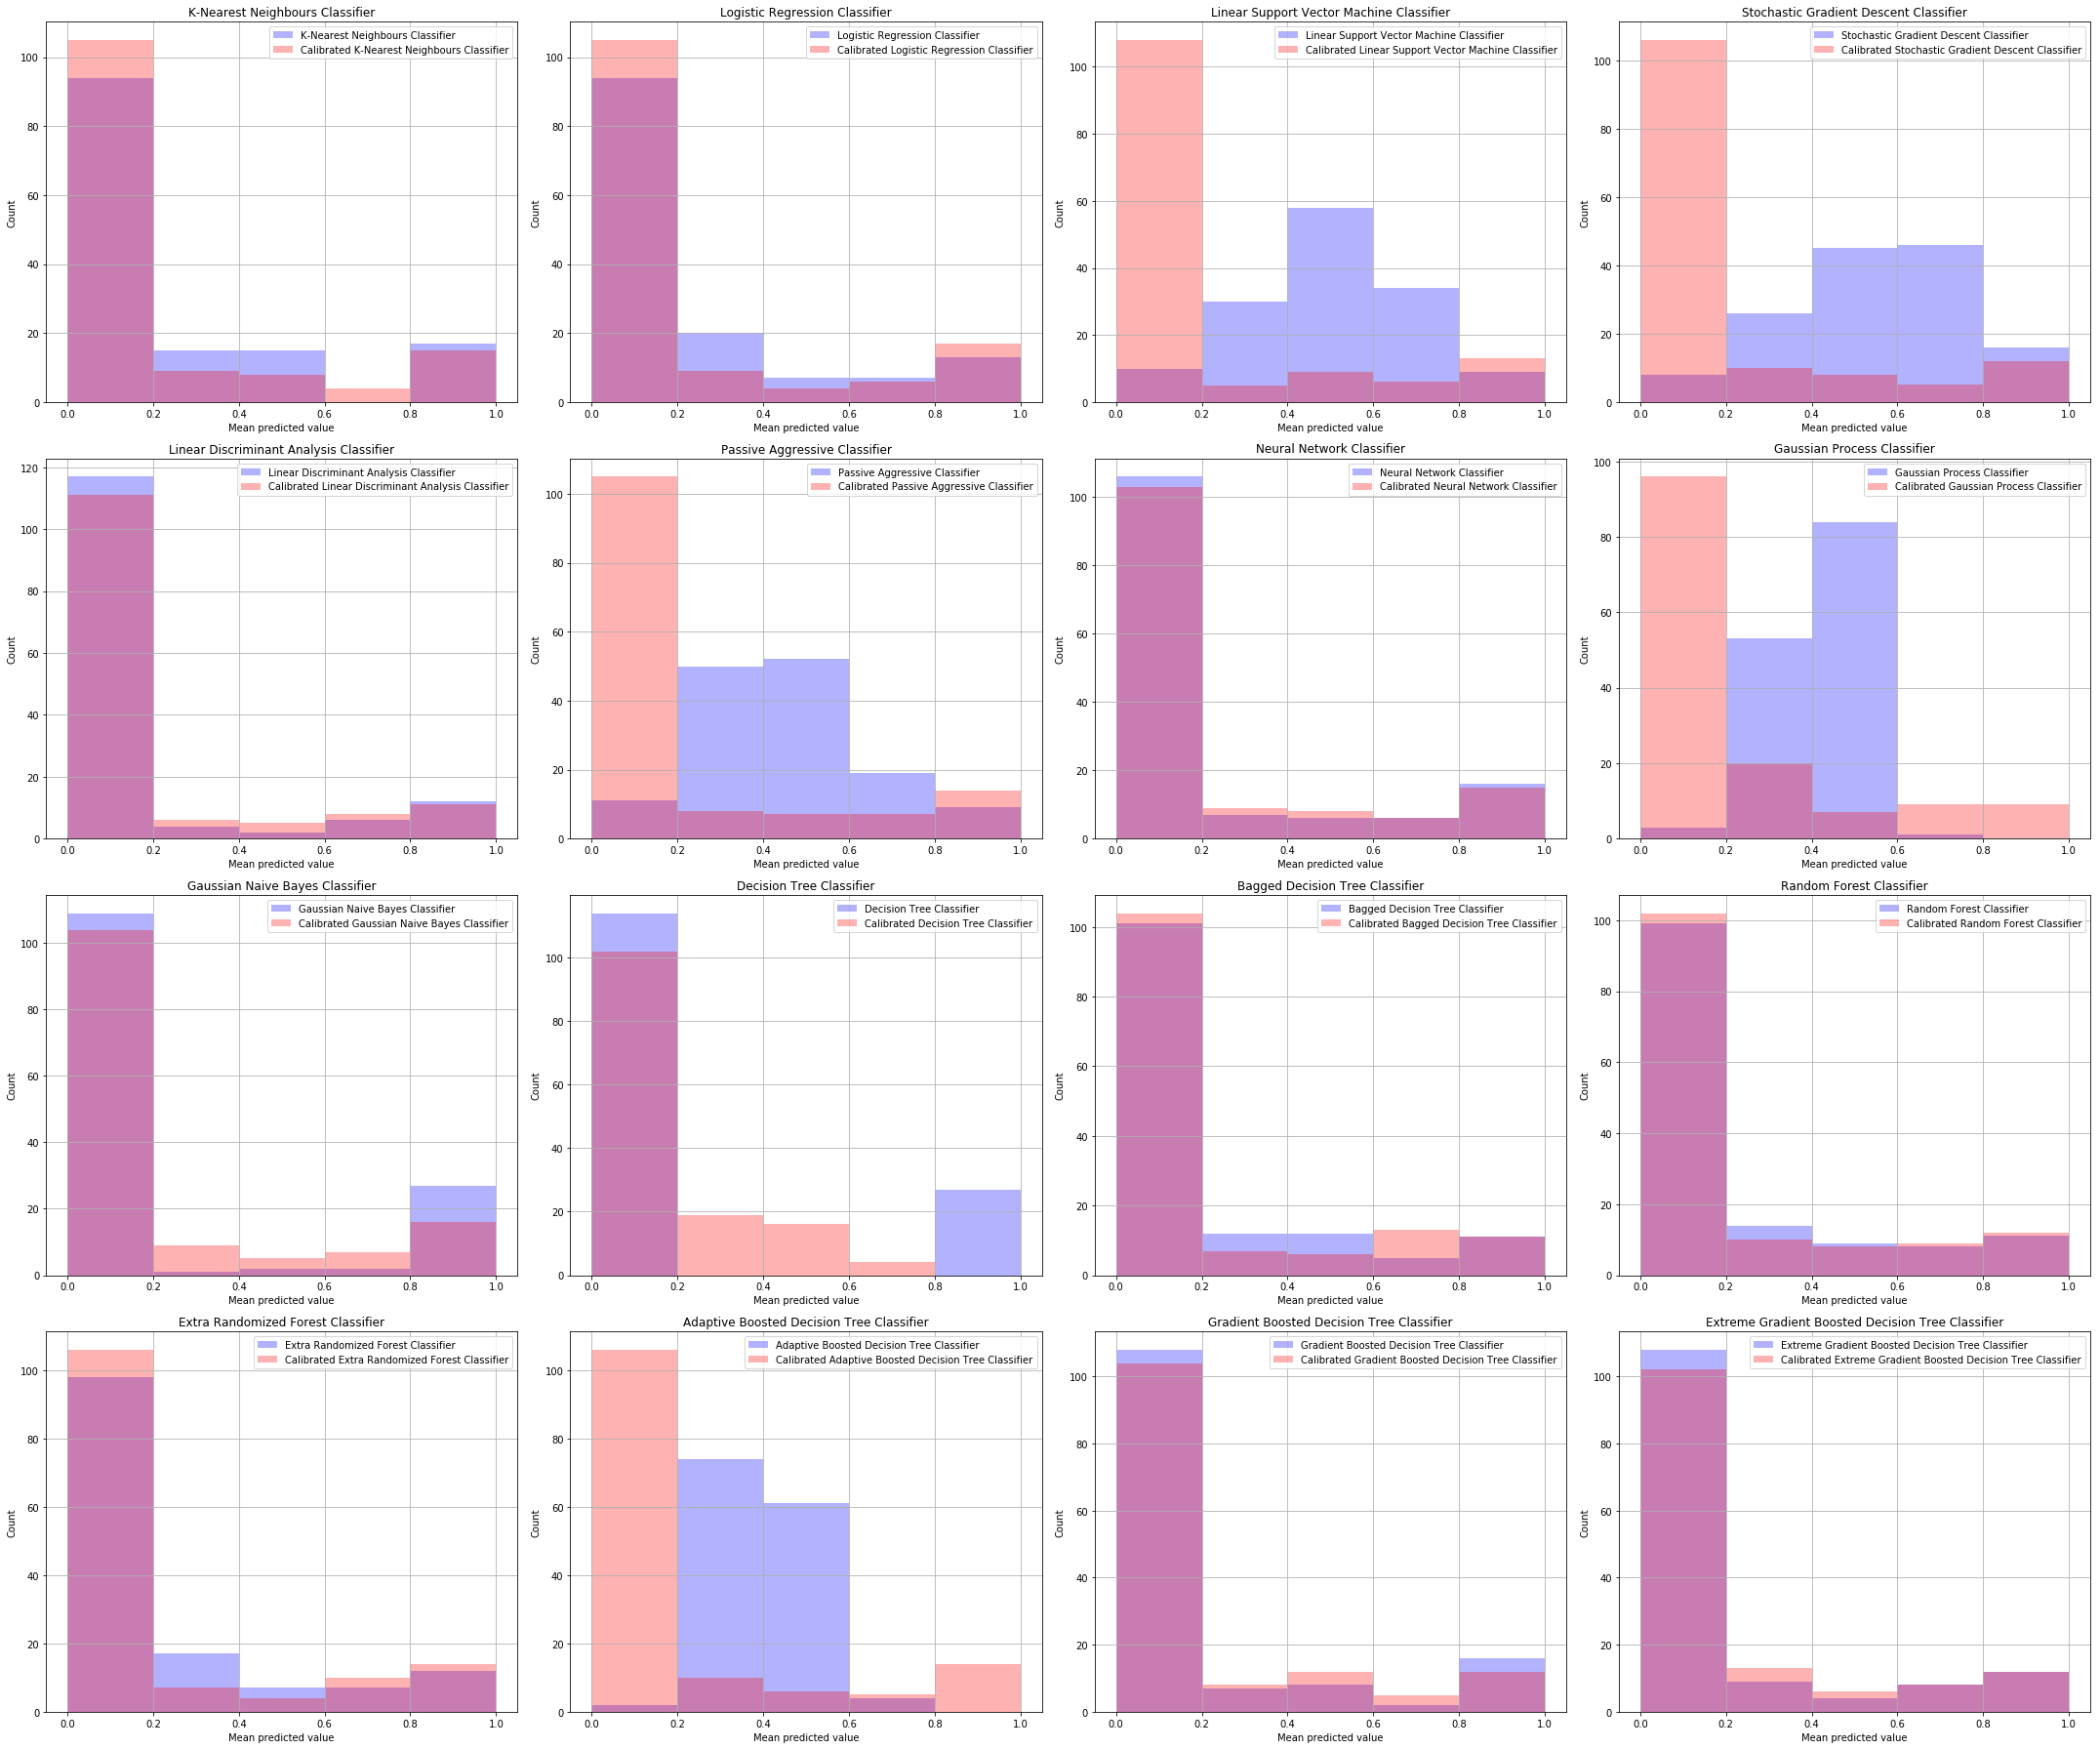

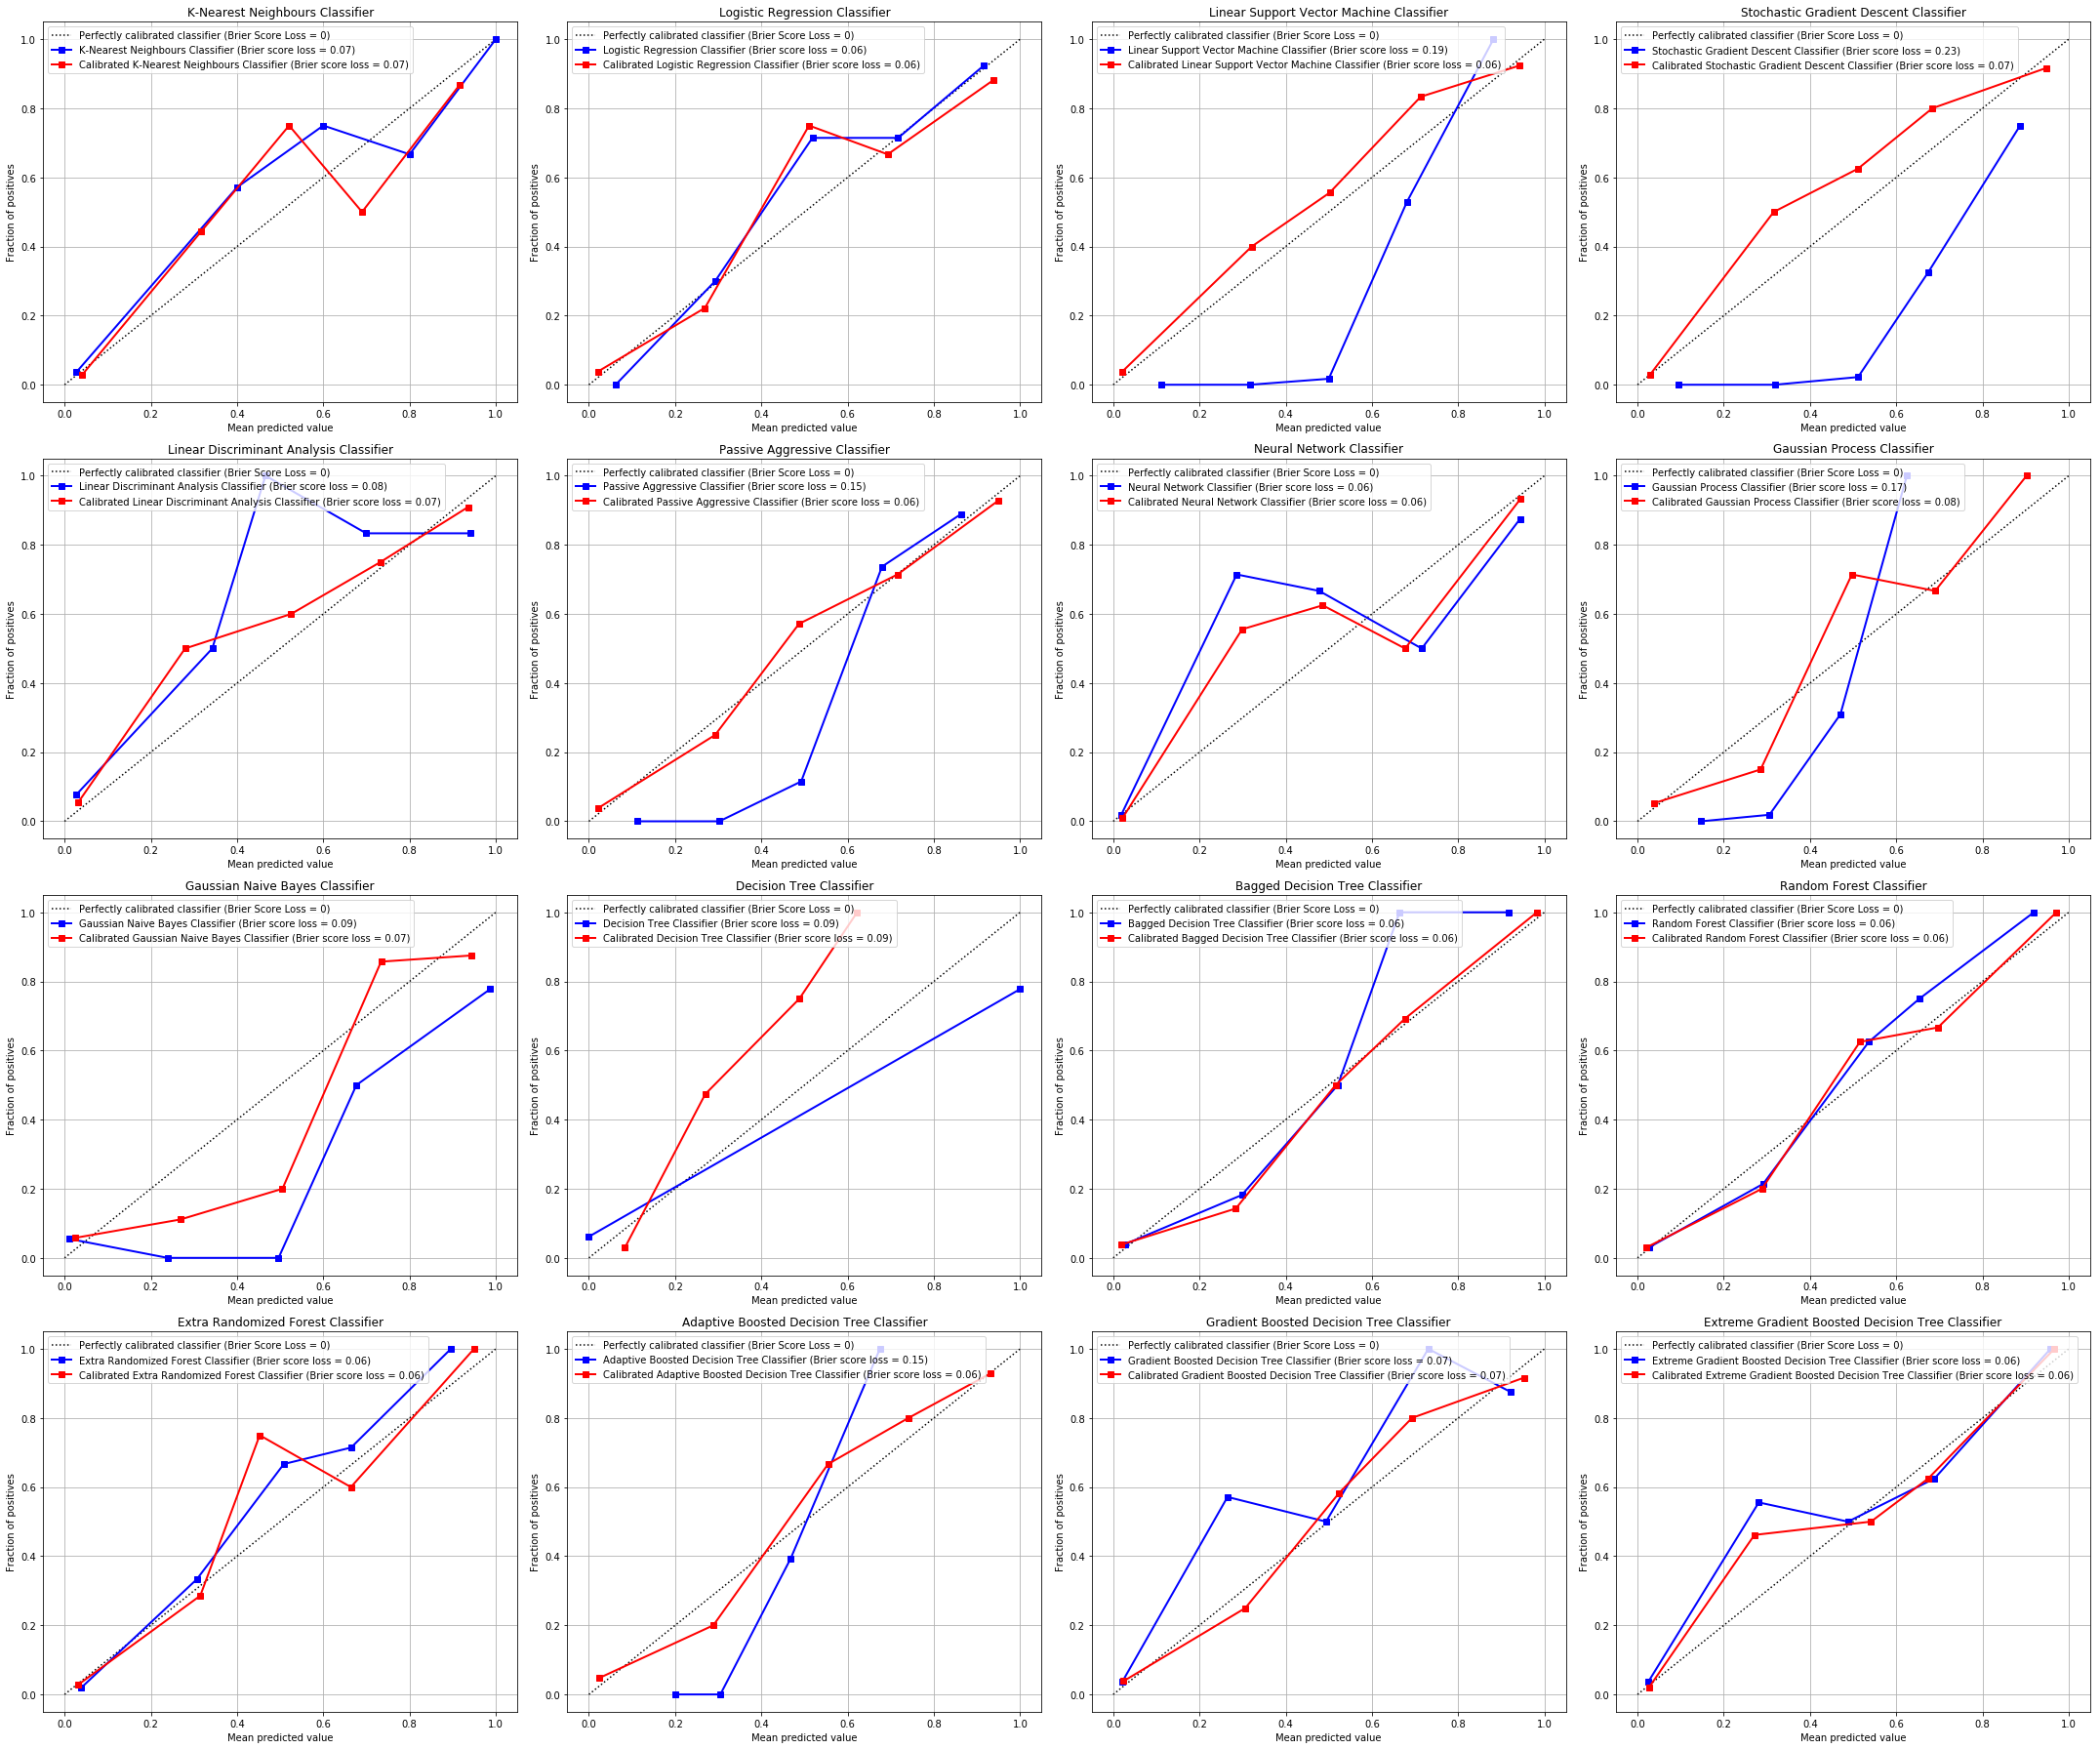

In [43]:
plt.figure(1, figsize=(30, 25))
plt.figure(2, figsize=(30, 25))

n_bins = 5

for imodel, model in enumerate(models):
    
    #print("-->", model.estimator_name)
    
    y_score       = model.y_score
    y_score_calib = model.y_score_calib

    fraction_of_positives,       mean_predicted_value       = calibration_curve(y_test, y_score,       n_bins=n_bins)
    fraction_of_positives_calib, mean_predicted_value_calib = calibration_curve(y_test, y_score_calib, n_bins=n_bins)

    brier_score_l       = brier_score_loss(y_test, y_score,       pos_label=1)
    brier_score_l_calib = brier_score_loss(y_test, y_score_calib, pos_label=1)
    
    plt.figure(1)
    plt.subplot(4, 4, imodel+1)

    plt.hist(y_score,       range=(0, 1), bins=n_bins, histtype="stepfilled", lw=2, alpha=0.3, color='b', 
             label='{}'           .format(model.estimator_name))
    plt.hist(y_score_calib, range=(0, 1), bins=n_bins, histtype="stepfilled", lw=2, alpha=0.3, color='r', #c, 
             label='Calibrated {}'.format(model.estimator_name))

    plt.title(model.estimator_name)
    plt.xlabel("Mean predicted value")
    plt.ylabel("Count")
    plt.legend(loc="upper right")    
    plt.grid(True)
    plt.tight_layout()
    
    plt.figure(2)
    plt.subplot(4, 4, imodel+1)
    
    plt.plot([0, 1], [0, 1], "k:", label="Perfectly calibrated classifier (Brier Score Loss = 0)")    

    plt.plot(mean_predicted_value, fraction_of_positives, "s-", lw=2, color='b',
             label="{} (Brier score loss = {:.2f})".format(model.estimator_name, brier_score_l))
    plt.plot(mean_predicted_value_calib, fraction_of_positives_calib, "s-", lw=2, color='r',
             label="Calibrated {} (Brier score loss = {:.2f})".format(model.estimator_name, brier_score_l_calib))

    plt.title(model.estimator_name)
    plt.xlabel("Mean predicted value")
    plt.ylabel("Fraction of positives")
    plt.ylim([-0.05, 1.05])
    plt.legend(loc="upper left")
    plt.grid(True)
    plt.tight_layout()

print("--> Predicted score distributions and probability calibration curves for all calibrated models on test data:")

Create dataframes with model scores and ranks for each conference separately, and sort them according to the median score/rank over all models:

In [44]:
score_column_names   = []
rank_column_names    = []
c_score_column_names = []
c_rank_column_names  = []
both_column_names    = []

for imodel in range(len(models)):
    
    if imodel in rejected_models:
        continue
        
    model_acronym = ''.join(c for c in models[imodel].estimator_name if c.isupper())
    score_column_names  .append("{} score"           .format(model_acronym))
    rank_column_names   .append("{} rank"            .format(model_acronym))
    c_score_column_names.append("{} calibrated score".format(model_acronym))
    c_rank_column_names .append("{} calibrated rank" .format(model_acronym))
    both_column_names   .append("{} score"           .format(model_acronym))
    both_column_names   .append("{} rank"            .format(model_acronym))
    both_column_names   .append("{} calibrated score".format(model_acronym))
    both_column_names   .append("{} calibrated rank" .format(model_acronym))

all_column_names = ['Player', 'Tm', 'G', 'TC']
all_column_names.extend(both_column_names)

df_scores = df_test.filter(all_column_names, axis=1)

'''
# Scale all probability scores between 0 and 1:

#scaler = MinMaxScaler(feature_range=(0, 1))

#df_scores[score_column_names] = scaler.fit_transform(df_scores[score_column_names])
'''
'''
# Scale all probability score ranks between 1 and n_players_test:

scaler = MinMaxScaler(feature_range=(1, n_players_test))

df_scores[rank_column_names] = scaler.fit_transform(df_scores[rank_column_names])
'''

# Calculate median score and median score rank of all models:

df_scores['Median score']            = df_scores[score_column_names]  .median(axis=1)
df_scores['Median rank']             = df_scores[rank_column_names]   .median(axis=1)
df_scores['Median calibrated score'] = df_scores[c_score_column_names].median(axis=1)
df_scores['Median calibrated rank']  = df_scores[c_rank_column_names] .median(axis=1)

# Create dataframes for each conference separately and sort according to median calibrated score / rank:

df_scores_WC = df_scores[df_scores['TC'] == 'WC']
df_scores_EC = df_scores[df_scores['TC'] == 'EC']

df_scores_WC = df_scores_WC.sort_values('Median calibrated score', ascending=False)
#df_scores_WC = df_scores_WC.sort_values('Median calibrated rank',  ascending=True)
df_scores_EC = df_scores_EC.sort_values('Median calibrated score', ascending=False)
#df_scores_EC = df_scores_EC.sort_values('Median calibrated rank',  ascending=True)

if test_year_truth_is_known:
    df_scores_WC['AS'] = df_test['AS']
    df_scores_EC['AS'] = df_test['AS']

df_scores_WC = df_scores_WC.reset_index(drop=True)
df_scores_EC = df_scores_EC.reset_index(drop=True)

df_scores_WC.index = np.arange(1, len(df_scores_WC) + 1)
df_scores_EC.index = np.arange(1, len(df_scores_EC) + 1)

Display scoring dataframes:

In [45]:
print_limit = 25
cm = sns.diverging_palette(240, 10, n=9, as_cmap=True)
subset_scores = ['Median score', *score_column_names, 'Median calibrated score', *c_score_column_names]
print("--> Scores and ranks for the predicted Western Conference All-Star candidate top-{}:".format(print_limit))
df_scores_WC_style = df_scores_WC[:print_limit].style.background_gradient(subset=subset_scores, cmap=cm, axis=0)
display(df_scores_WC_style)

--> Scores and ranks for the predicted Western Conference All-Star candidate top-25:


In [46]:
print("--> Scores and ranks for the predicted Eastern Conference All-Star candidate top-{}:".format(print_limit))
df_scores_EC_style = df_scores_EC[:print_limit].style.background_gradient(subset=subset_scores, cmap=cm, axis=0)
display(df_scores_EC_style)

--> Scores and ranks for the predicted Eastern Conference All-Star candidate top-25:


Print test features of a specific player:

Print a table of the predicted NBA All-Star top-25 for each conference:

In [47]:
print_limit = 25

TP_WC = []
FP_WC = []
FN_WC = []
P_WC  = []

print("--> Predicted Top-{} Western Conference All-Stars {} :".format(print_limit, test_year))
print("")

for index, row in df_scores_WC.iterrows():
    
    if test_year_truth_is_known:
        if ((index <= 12) and (row['AS'] > 0.5)):
            player_list_element = "{} ({})".format(row['Player'], row['Tm'])
            TP_WC.append(player_list_element)
        if ((index <= 12) and (row['AS'] < 0.5)):
            player_list_element = "{} ({})".format(row['Player'], row['Tm'])
            FP_WC.append(player_list_element)
        if ((index >  12) and (row['AS'] > 0.5)):
            player_list_element = "{} ({})".format(row['Player'], row['Tm'])
            FN_WC.append(player_list_element)

    else:
        if (index <= 12):
            player_list_element = "{} ({})".format(row['Player'], row['Tm'])
            P_WC.append(player_list_element)
        

    if (index <= print_limit):
        if test_year_truth_is_known:
            print("{:2}) {:24} ({}) Median calibrated score = {:.3f} (All-Star = {}, G = {:2})".format(
                index, row['Player'], row['Tm'], row['Median calibrated score'], row['AS'], row['G']))
        else:
            print("{:2}) {:24} ({}) Median calibrated score = {:.3f} (All-Star = N.A., G = {:2})".format(
                index, row['Player'], row['Tm'], row['Median calibrated score'], row['G']))
    if (index == 12):
        print("*****************************************************************************************************")
        
TP_EC = []
FP_EC = []
FN_EC = []
P_EC  = []

print("")
print("--> Predicted Top-{} Eastern Conference All-Stars {} :".format(print_limit, test_year))
print("")

for index, row in df_scores_EC.iterrows():
        
    if test_year_truth_is_known:
        if ((index <= 12) and (row['AS'] > 0.5)):
            player_list_element = "{} ({})".format(row['Player'], row['Tm'])
            TP_EC.append(player_list_element)
        if ((index <= 12) and (row['AS'] < 0.5)):
            player_list_element = "{} ({})".format(row['Player'], row['Tm'])
            FP_EC.append(player_list_element)
        if ((index >  12) and (row['AS'] > 0.5)):
            player_list_element = "{} ({})".format(row['Player'], row['Tm'])
            FN_EC.append(player_list_element)
    else:
        if (index <= 12):
            player_list_element = "{} ({})".format(row['Player'], row['Tm'])
            P_EC.append(player_list_element)
        
    if (index <= print_limit):
        if test_year_truth_is_known:
            print("{:2}) {:24} ({}) Median calibrated score = {:.3f} (All-Star = {}, G = {:2})".format(
                index, row['Player'], row['Tm'], row['Median calibrated score'], row['AS'], row['G']))
        else:
            print("{:2}) {:24} ({}) Median calibrated score = {:.3f} (All-Star = N.A., G = {:2})".format(
                index, row['Player'], row['Tm'], row['Median calibrated score'], row['G']))
    if (index == 12):        
        print("*****************************************************************************************************")

--> Predicted Top-25 Western Conference All-Stars 2018 :

 1) James Harden             (HOU) Median calibrated score = 1.000 (All-Star = 1, G = 72)
 2) Russell Westbrook        (OKC) Median calibrated score = 1.000 (All-Star = 1, G = 80)
 3) Anthony Davis            (NOP) Median calibrated score = 1.000 (All-Star = 1, G = 75)
 4) Kevin Durant             (GSW) Median calibrated score = 0.985 (All-Star = 1, G = 68)
 5) Damian Lillard           (POR) Median calibrated score = 0.984 (All-Star = 1, G = 73)
 6) LaMarcus Aldridge        (SAS) Median calibrated score = 0.928 (All-Star = 1, G = 75)
 7) Jimmy Butler             (MIN) Median calibrated score = 0.850 (All-Star = 1, G = 59)
 8) DeMarcus Cousins         (NOP) Median calibrated score = 0.830 (All-Star = 1, G = 48)
 9) Chris Paul               (HOU) Median calibrated score = 0.821 (All-Star = 0, G = 58)
10) Stephen Curry            (GSW) Median calibrated score = 0.809 (All-Star = 1, G = 51)
11) Karl-Anthony Towns       (MIN) Median 

## Conclusion

The supervised algorithms tested in this analysis are able to predict the NBA All-Stars reasonably well in terms of precision, recall, etc.

If the All-Star selection for *test_year* is not completed yet, there is simply one group of predicted All-Stars per conference, as shown above. If the All-Star selection for *test_year* is completed, each of these two groups can be further subdivided into three groups:

1. **Deserved All-Stars**     : Players that were selected and predicted as All-Stars
2. **Questionable All-Stars** : Players that were selected but not predicted as All-Stars
3. **Snubbed non-All-Stars**  : Players that are predicted but not selected as All-Stars

The players in these two/six groups are, in order of median calibrated probability score over all models:

In [48]:
if test_year_truth_is_known:
    print(" Western Conference All-Star Prediction {}:".format(test_year))
    print("----------------------------------------------")
    print("--> Deserved All-Stars     : ", end='')
    print(*TP_WC, sep=', ')
    print("--> Questionable All-Stars : ", end='')
    print(*FN_WC, sep=', ')
    print("--> Snubbed non-All-Stars  : ", end='')
    print(*FP_WC, sep=', ')
    print("")
    print(" Eastern Conference All-Star Prediction {}:".format(test_year))
    print("----------------------------------------------")
    print("--> Deserved All-Stars     : ", end='')
    print(*TP_EC, sep=', ')
    print("--> Questionable All-Stars : ", end='')
    print(*FN_EC, sep=', ')
    print("--> Snubbed non-All-Stars  : ", end='')
    print(*FP_EC, sep=', ')
else:
    print(" Western Conference All-Star Prediction {}:".format(test_year))
    print("----------------------------------------------")
    print("--> Predicted All-Stars : ", end='')
    print(*P_WC, sep=', ')
    print("")
    print(" Eastern Conference All-Star Prediction {}:".format(test_year))
    print("----------------------------------------------")
    print("--> Predicted All-Stars : ", end='')
    print(*P_EC, sep=', ')

 Western Conference All-Star Prediction 2018:
----------------------------------------------
--> Deserved All-Stars     : James Harden (HOU), Russell Westbrook (OKC), Anthony Davis (NOP), Kevin Durant (GSW), Damian Lillard (POR), LaMarcus Aldridge (SAS), Jimmy Butler (MIN), DeMarcus Cousins (NOP), Stephen Curry (GSW), Karl-Anthony Towns (MIN)
--> Questionable All-Stars : Paul George (OKC), Klay Thompson (GSW), Draymond Green (GSW)
--> Snubbed non-All-Stars  : Chris Paul (HOU), Nikola Jokic (DEN)

 Eastern Conference All-Star Prediction 2018:
----------------------------------------------
--> Deserved All-Stars     : Giannis Antetokounmpo (MIL), LeBron James (CLE), Kyrie Irving (BOS), Victor Oladipo (IND), DeMar DeRozan (TOR), Joel Embiid (PHI), Andre Drummond (DET), Kyle Lowry (TOR), Kemba Walker (CHO), Bradley Beal (WAS)
--> Questionable All-Stars : John Wall (WAS), Kevin Love (CLE), Kristaps Porzingis (NYK), Al Horford (BOS), Goran Dragic (MIA)
--> Snubbed non-All-Stars  : Ben Simmon

In [50]:
end = time.time()

print("--> Total processing time = {:.1f} secs".format((end - start)))

--> Total processing time = 535.3 secs
